# Variational Autoencoders

Instead of just learning a function representing the data ( a compressed representation) like autoencoders, variational autoencoders learn the parameters of a probability distribution representing the data. Since it learns to model the data, we can sample from the distribution and generate new input data samples. 

So we understand that the main difference comes from the fact that when the hidden layer parameters encode an actual probability distribution, then we can generate samples from this probability distribution.

Variational Autoencoder was introduced in 2014 by Diederik Kingma and Max Welling with intention how autoencoders can be generative.

VAE are generative autoencoders, meaning they can generate new instances that look similar to original dataset used for training.
As mentioned before, VAE learns probability distribution of the data whereas autoencoders learns a function to map each input to a number and decoder learns the reverse mapping.

**Think : Why cannot we generate samples when the hidden layer activations don't correspond to a probability distribution?**

## Why Variational Autoencoder



One reason why we need VI is that numerical integration scales very badly with dimension:
The reason this scales so badly is because of the curse of dimensionality.

The most common place we see Variational Inference is computing posterior distributions in Bayesian models. Recall Bayes' Theorem:

$$P(Z | X)=\frac{P(X, Z)}{\int_{Z} P(X, Z) d Z}$$

Computing the denominator of this fraction is sometimes very, very hard. For example, if Z is multidemensional, and the distributions are not conjugate, there are very limited ways to compute this integral.

Let's make the simplifying assumption that X and Z are independent. This gives us the simplifying assumption:

$$\int_{Z} P(X, Z) d Z=\int_{Z} P(X) P(Z) d Z$$

Obviously if we knew this in practice, we could simply find P(X) by factorising the joint distribution, however the important point here is to show how complex computing this integral is if we don't know an analytical simplification. Let's say $P(Z)$ is a multivariate standard Gaussian.

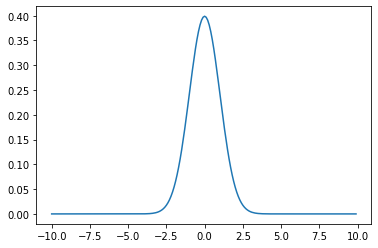

In [21]:
from scipy.stats import multivariate_normal 
x = np.arange(-10, 10, 0.1)
y = multivariate_normal.pdf(x, mean=np.zeros(1), cov=np.ones(1))
plt.plot(x,y)

In 1D this is a simple numeric integral.



In [22]:
import time

x = np.arange(-100, 100, 1)
dx = 1.0
area = 0
start = time.time()
for i in range(len(x)-1):
    h1 = multivariate_normal.pdf(x[i], mean=np.zeros(1), cov=np.ones(1))
    h2 = multivariate_normal.pdf(x[i+1], mean=np.zeros(1), cov=np.ones(1))
    av_h = 0.5*(h1+h2)
    area += av_h * dx
print(area, " - took:", time.time()-start)

1.0000000053505758  - took: 0.06035161018371582


Even in 2D, this starts to become harder



In [23]:
dx = 1.0
area = 0
start = time.time()
for i in range(len(x)-1):
    for j in range(len(x)-1):
        h1 = multivariate_normal.pdf(np.array([x[i], x[j]]), mean=np.zeros(2), cov=np.eye(2))
        h2 = multivariate_normal.pdf(np.array([x[i+1], x[j+1]]), mean=np.zeros(2), cov=np.eye(2))
        h3 = multivariate_normal.pdf(np.array([x[i], x[j+1]]), mean=np.zeros(2), cov=np.eye(2))
        h4 = multivariate_normal.pdf(np.array([x[i+1], x[j]]), mean=np.zeros(2), cov=np.eye(2))
        av_h = 0.25*(h1+h2+h3+h4)
        area += av_h * dx**2
print(area, " - took:", time.time()-start)

1.000000010701151  - took: 20.792203426361084


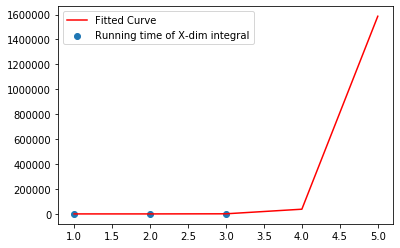

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

x = np.array([1,2,3])
x_new = np.linspace(1,5,5)
y = np.array([0.06,21,900])
popt, pcov = curve_fit(func, x, y)
plt.figure()
plt.scatter(x, y, label="Running time of X-dim integral")
plt.plot(x_new, func(x_new, *popt), 'r-', label="Fitted Curve")
plt.legend()
plt.show()

So we can see that in 5 dimensions, the integral computation might already take over 1.6 million seconds!?
The reason this scales so badly is because of the curse of dimensionality.


If we use numeric integration to find the n-dimensional volume, then we can approximate this by the average over all the values in n-dimensions multiplied by the grid-distance to the power of n.
As the dimension of the space becomes larger, the discrete volumes we compute with the numerical integral increase exponentially. So in $N-D$, we have to do amount of data points to the power of n evaluations.

If we have an array of 200 numbers, then 
- in 1-D, we have to do ~ 200 evaluations
- in 2d ~ 40,000 
- in 3d ~ 8 million


Let's not forget that this is a simple case too - an independant mulivariate gaussian with known mean and variance. This means, I only have to integrate over a small portion of the real line (-100 to 100 is ample). 

In general, we don't neccesarily know this - in high dimensions with a non analytical joint, we might have to integrate over a very large range to ensure we capture all the mass of Z.
Consider the example where Z is actually a mixture of many gaussians, with means equally spaced between -1e6 and + 1e6, giving us a 3d integral requiring 2e12 evaluations - a near impossible feat, and we are still only in 3D. Move this to 5 dimensions and it becomes 2e30 evaluations!!

**The aim of variational inference is to develop bounds in order to get a tractable approximation.**

In [5]:
import os
from IPython.display import Image
os.listdir("img")

['autoencoder_structure.PNG',
 'variational_autoencoder.png',
 'nn_all_combined_image.jpg']

## Understanding the Background Knowledge for Variational Autoencoder

In the previous post, I talked about different types of bounds we could have, and why we need to use them. As a quick recap, we are looking to compute the marginalization of a joint distribution in a general setting: $P(X)=\int_{Z} P(X, Z) d Z$

### Evidence
Evidence is the denominator  in the Bayes theorem and it is also called the distribution of the data $P(X)$.


### Deriving Variational Lower Bound Usig Jensen's Inequality
Previously, I showed how this can be an incredibly difficult thing to compute using standard methods, such as numerical integration, because of the curse of dimensionality.

$$\log P(X)=\log \left[\int_{Z} P(X, Z) d Z\right]$$
$$\log P(X)=\log \left[\int_{Z} P(X, Z) \frac{q(Z)}{q(Z)} d Z\right]=\log E_{q}\left[\frac{P(X, Z)}{q(Z)}\right]$$

Since [Jensen's inequality](https://en.wikipedia.org/wiki/Jensen%27s_inequality#Measure-theoretic_and_probabilistic_form) states
$$\log E_{q}\left[\frac{P(X, Z)}{q(Z)}\right] \geq E_{q}\left[\log \frac{P(X, Z)}{q(Z)}\right]$$

then

$$\begin{array}{l}{\log P(X)=\log E_{q}\left[\frac{P(X, Z)}{q(Z)}\right] \geq E_{q}\left[\log \frac{P(X, Z)}{q(Z)}\right]} \\ {\log P(X) \geq E_{q}\left[\log \frac{P(X, Z)}{q(Z)}\right]=\mathcal{L}}\end{array}
$$

#### Variational Lower Bound
$$\mathcal{L}=\int_{Z} q(Z) \log \frac{P(Z, X)}{q(Z)} d Z$$

From this, the role of the ELBO is obvious; it is a lower bound on the "evidence", P(X), so we can use this to get an approximation for the evidence.

### Deriving Variational Lower Bound using K-L Divergence
$$\begin{array}{l}{D_{K L}(q(Z) \| P(Z | X))=-E_{q}\left[\log \frac{P(Z | X)}{q(Z)}\right]=-E_{q}[\log P(Z | X)-\log q(Z)]} \\ {-E_{q}[\log P(Z | X)-\log q(Z)]=-E_{q}\left[\log \frac{P(Z, X)}{P(X)}-\log q(Z)\right]=} \\ {-E_{q}[\log P(Z, X)-\log P(X)-\log q(Z)]}\end{array}$$

Since $\log P(X)$ is independant of $Z$, so it's expectation under $q(Z)$ is itself. 
We can thus split the last step into two terms:

$$\begin{array}{l}{-E_{q}[\log P(Z, X)-\log P(X)-\log q(Z)]=-E_{q}[\log P(Z, X)-\log q(Z)]} \\ {+E_{q}[\log P(X)]}\end{array}$$

Therefore, we arrive at;

$$D_{K L}(q(z) \| P(Z | X))=-E_{q}[\log P(Z, X)-\log q(Z)]+\log P(X)$$


The expectation term is the same as the term we called $\mathcal{L}$ in the previous section, so rewriting;

$$D_{K L}(q(z) \| P(Z | X))=-\mathcal{L}+\log P(X)$$


The original goal was to find an approximation $q(z)$ that is close to the true posterior. So we are varying $q$ in order to minimise the KL-Divergence between it and the posterior. 
The log evidence is independent of $q$, so it doesn't matter how we vary $q$, it is just a constant term. 

So to minimise the LHS, we have to minimise $−\mathcal{L}$, which is equivalent to maximising $\mathcal{L}$.

Looking at the **ELBO** from this perspective, we see that 

**the q that maximises the ELBO also minimises the KL-Divergence between itself and the true posterior**

### Summary of ELBO or Variational Lower Bound
From the above two angles, we can see the roles that the component parts of the ELBO play. The ELBO itself is a lower bound on the evidence, whilst the distribution q serves as the approximation of the true posterior.

### Reparametrization Trick and Why Should Sampling be Differentiable

[Resource](https://chrisorm.github.io/VI-reparam.html)

[Where the idea was popularized](https://arxiv.org/pdf/1312.6114.pdf)

[Typical reparametrization trick is based on this](https://en.wikipedia.org/wiki/Location%E2%80%93scale_family)

Recall the variational lower bound $$\mathcal{L}=\int_{Z} q(Z) \log \frac{P(Z, X)}{q(Z)} d Z$$

Using Monte Carlo sampling, one can estimate that integral using a sum, and the distribution $q(Z)$ by sampling.

The important thing to remember, is that when we take the gradient with respect to the parameters of the ELBO , it is easy to not incorporate the effect of the parameters on the expectation.

#### Example
Consider sampling from a uniform distribution $U \left[a,b\right]$. 
If we change the values of $a$ and $b$, then obviously this will change our samples! If we generate samples from this distribution outside of our simulation program, this gradient information will be lost.

#### Example of Reparametrization Trick Using Inverse CDF
If the pdf we wish to sample from has a tractable inverse CDF (quantile function), we can use this 
to transform a $U[0,1]$ sample to a sample from the target distribution, and the gradient will be properly accounted for.

Rayleigh Distribution CDF  $ C=1-\exp \frac{x^{2}}{2 \sigma^{2}}$

If we can generate values for $C$ from the standard Uniform distribution, then the inverse of this CDF has Rayleigh Distribution.
This was based on the assumption that the distribution has a well-defined CDF.
$$\begin{array}{l}{1-C=\exp \frac{x^{2}}{2 \sigma^{2}}} \\ {\ln (1-C)=\frac{x^{2}}{2 \sigma^{2}}} \\ {\sigma \sqrt{2 \ln (1-C)}=x}\end{array}$$
As a check if we apply the Rayleigh CDF to $x$, this will result in obtaining the $C$, which is the CDF for Rayleigh distribution, so $$x  \sim Rayleigh$$

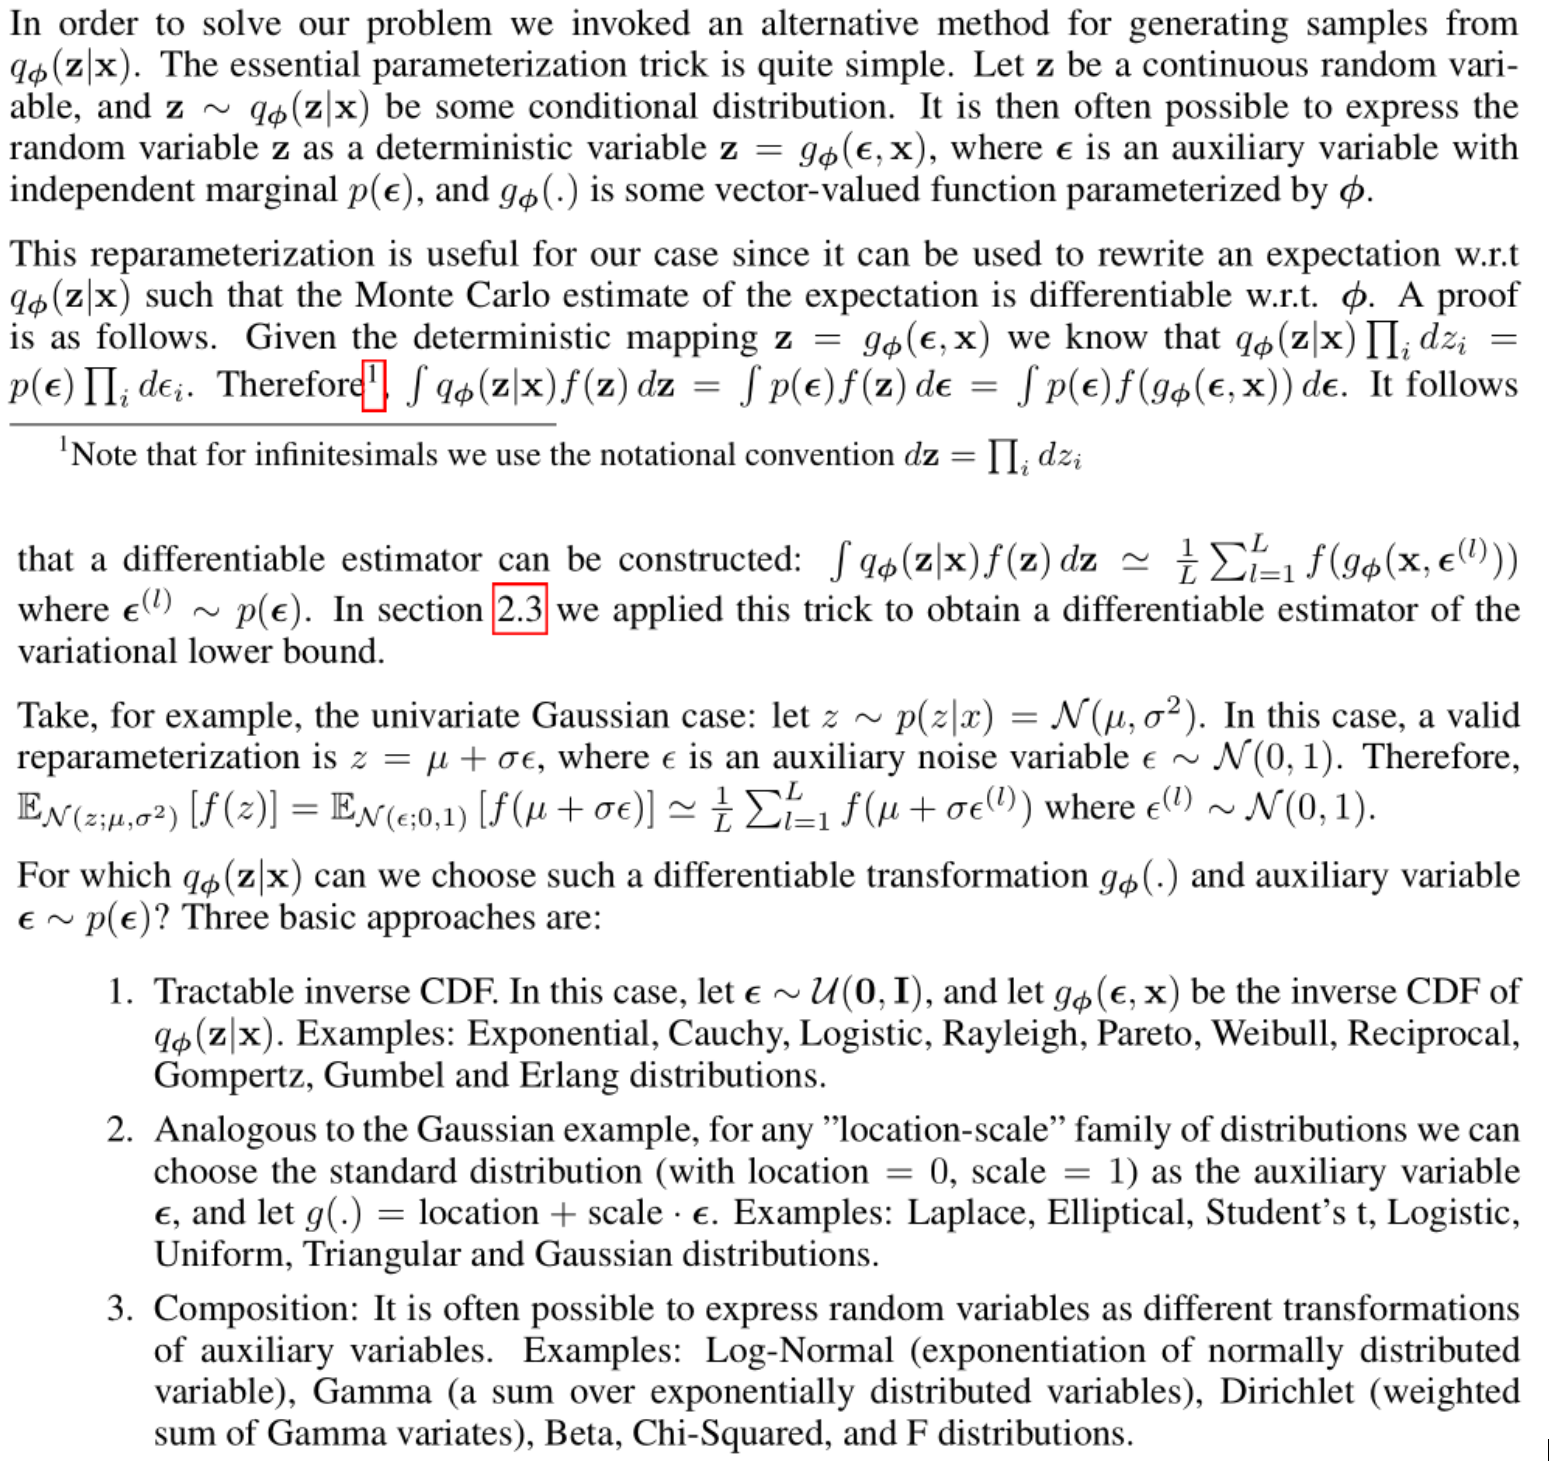

In [54]:
from IPython.display import Image
Image("img/reparametrization.PNG")

# Variational Inference 
## Intrduction
[Resource](https://chrisorm.github.io/VI-to-VAE.html)
In previous posts, we have had a fixed model, and are looking to compute an approximate posterior, often because this is computationally hard to do exactly. To do this, we derived the ELBO, which revolves around the KL-divergence to measure the 'closeness' of the true and approximate posteriors. Let's denote the parameters of our approximate posterior as $\varphi$.
$$\mathcal{L} = E_{q}[log \ \frac{P(X,Z)}{q(Z)}] = E_{q}[log \ P(X,Z) - log \ q_{\phi}(Z)]$$
In order to find our approximation, $q$, we solve: $max_{\phi}(\mathcal{L})$

### Variational Inference : Learning the True Joint 
The natural question to ask is "what if we don't know the model for the joint distribution?". Let's first imagine that we do have a form for the model - e.g. it is normally distributed, but we don't know the parameters of this model. We can use maximum likelihood to learn the parameters of our true model, which we will denote as $\theta$.

So, if we want to learn both the model and the approximate posterior, we can rewrite the above objective as:

$$max_{\phi}max_{\theta} \ E_{p_{D}}[ \mathcal{L}] = max_{\phi, \theta} E_{p_{D}}[E_{q}[log \ P_{\theta}(X,Z) - log \ q_{\phi}(Z)]]$$

where $p_D(X)$ denotes the distribution of the data. In practice, we have some data, $X$, and we minimise the mean of the loss function over this data.

This represents a very minor change to the previous framework, and this is quite natural to handle in modern autodiff framworks.



### From Variational Inference to Variational Autoencoders 
One final step brings us to Variational Autoencoders. The problem with doing simple maximum likelihood as outlined before, is that it is very constraining. If I want to learn a model over Gaussians, it's fine, but if I want to learn a model of the distribution of images that contain zebras, specifying the model is a problem!

To solve this problem, VAEs replace the explicit model with a neural network. Firstly, we make the near trivial extension that the approximate posterior is given by $q(z \mid x)$. The original paper took the posterior as:
$$q(z \mid X) \sim N(\mu_{q \mid X}, \Sigma_{q \mid X})$$

The notation here means that every x value has its own mean and variance associated with it - so if we have n data points, we learn n means and n covariances.

We also specify the joint as a prior on $Z$ and a likelihood term on $x$. The prior is a unit gaussian.

$P(Z) \sim N(0,I)$

The form of $ P(X \mid Z)$ is either a Gaussian or Bernoulli, depending on the data.

### Distributions from Neural Networks

In order to have both the approximate posterior and likelihood terms, we use neural networks to learn the form. In the case of the likelihood, we have a neural network that takes a sample from $P(Z)$ as input, and outputs a mean and a variance of the likelihood distribution if it is Gaussian, or the Bernoulli parameter if not.

The approximate posterior is parameterised by a neural network that takes a sample of our data as input, and outputs a mean and variance for the approximate posterior at this $X$ value.

In short, the neural networks act a bit like lookup tables - we pass in an input value and get the parameters of the distribution out. From there, everything is much the same as before - we maximise the ELBO.

Let's assume that the likelihood is given be a Gaussian:

$$P(X \mid Z) \sim N(f(Z), g(Z))$$

Where $f$ and $g$ are our neural network. Assuming we don't use a trivial network (e.g. no hidden layers or no non-linearities), f and g are likely to be far from linear. This means the joint is no longer a Gaussian, but this is a good thing! If the network is sufficiently flexible, it can learn very complex joints that are not at all similar to a Gaussian.

### Some complications to be aware of
One obvious problem comes from the posterior - whereas before we had to only learn a single posterior, now we learn one for each data point. This means if we have lots of data, this may be a problem!

$$q(z \mid X) \sim N(h(X), k(X))$$

Another, more subtle issue comes from the ELBO itself.

$$\mathcal{L} = E_{q}[log \ \frac{P(X,Z)}{q(Z \mid X)}]$$

We encounter problems if the support of the distributions P and q are different. If there is some point where the distribution under P is non-zero, but the distribution under q is very small, the bound becomes very large. If there is a point where q is actually or numerically zero, the bound is infinite.

As the bound becomes very large, the gradient signal we get becomes smaller and smaller, and so we may well encounter convergence issues. 

## What does a Variational Autoencoder look like?

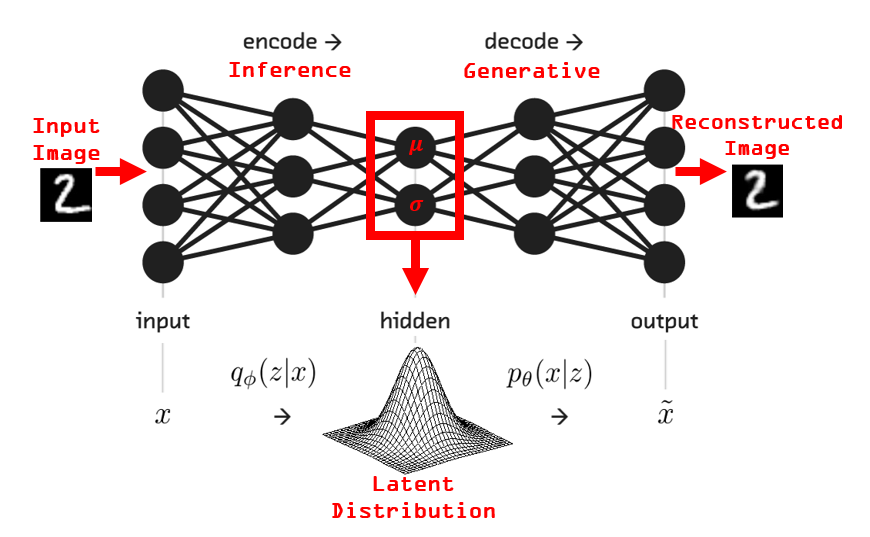

In [6]:
Image(filename="./img/variational_autoencoder.png")

## Build your VAE 


[LINK](https://chrisorm.github.io/VAE-pyt.html)
### Prototype Problem for Understanding Variational Autoencoder
Problem
Rather than resorting to MNIST, we will try to learn the distribution of one-hot 4 dimensional vectors. This is simple enough that we are able to use a latent variable of size 2 - and we can therefore visualise the distribution learnt by the model.

To model this, we will use the following specification:
$$\begin{array}{l}{p(z) \sim \mathcal{N}\left(0, I_{2}\right)} \\ {p(x \mid z) \sim \mathcal{N}(f(z)[0], f(z)[1])} \\ {q(z \mid x) \sim \mathcal{N}(g(x)[0], g(x)[1])}\end{array},$$
where $p(z)$ is the latent representation prior (2-D Gaussian)

$p(z \mid x )$ is the likelihood parametrized by the neural network $f$ 

$q(z \mid x)$ is the posterior distribution of the latent space, given the data $x$, parametrized by neural network $g$

### Intuition to Understand the Model

From the above probabilistic formulation, we can offer an intuition behind the roles of the neural networks. 

- Network $g$ can be seen as an encoder - it takes a sample, and transforms this into the parameters of the posterior over z. 
- Network f is a decoder - it takes the latent "representation", $z$, and turns this into a distribution over $x$.

At test time, we can simply take the mode of the two distributions, and in this case, we get an encoder-decoder pair:

$$\begin{array}{l}{E(x, z)=\operatorname{argmax}_{z} q(z | x)} \\ {D(x, z)=\operatorname{argmax}_{x} p(x | z)}\end{array}$$

In terms of this particular prototype model, this means that 

1. given a basis vector, find the latent space variable value that yields the maximum probability of getting that value
2. given the parameter value from the latent space, find a basis vector that corresponds to this parameter value with the highest probability

In [2]:
import torch
from torch import nn
from torch.autograd import Variable

import numpy as np
representation_size = 2
input_size = 4
n_samples = 2000
batch_size = 5
n_samples_per_batch = n_samples//input_size

y = np.array([i for i in range(input_size)  for _ in range(n_samples_per_batch)])

d = np.identity(input_size)
x = np.array([d[i] for i in y], dtype=np.float32)

In [52]:
print(x[[10, 58 ,610, 790, 1123, 1258, 1506, 1988]])

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


In [8]:
x.shape

(2000, 4)

Let's now write our own custom Variational Autoencoder class.
First, any Pytorch module should inherit the structure from nn.Module same way as in Python every object inherits its structure from object.


### Class Initialization


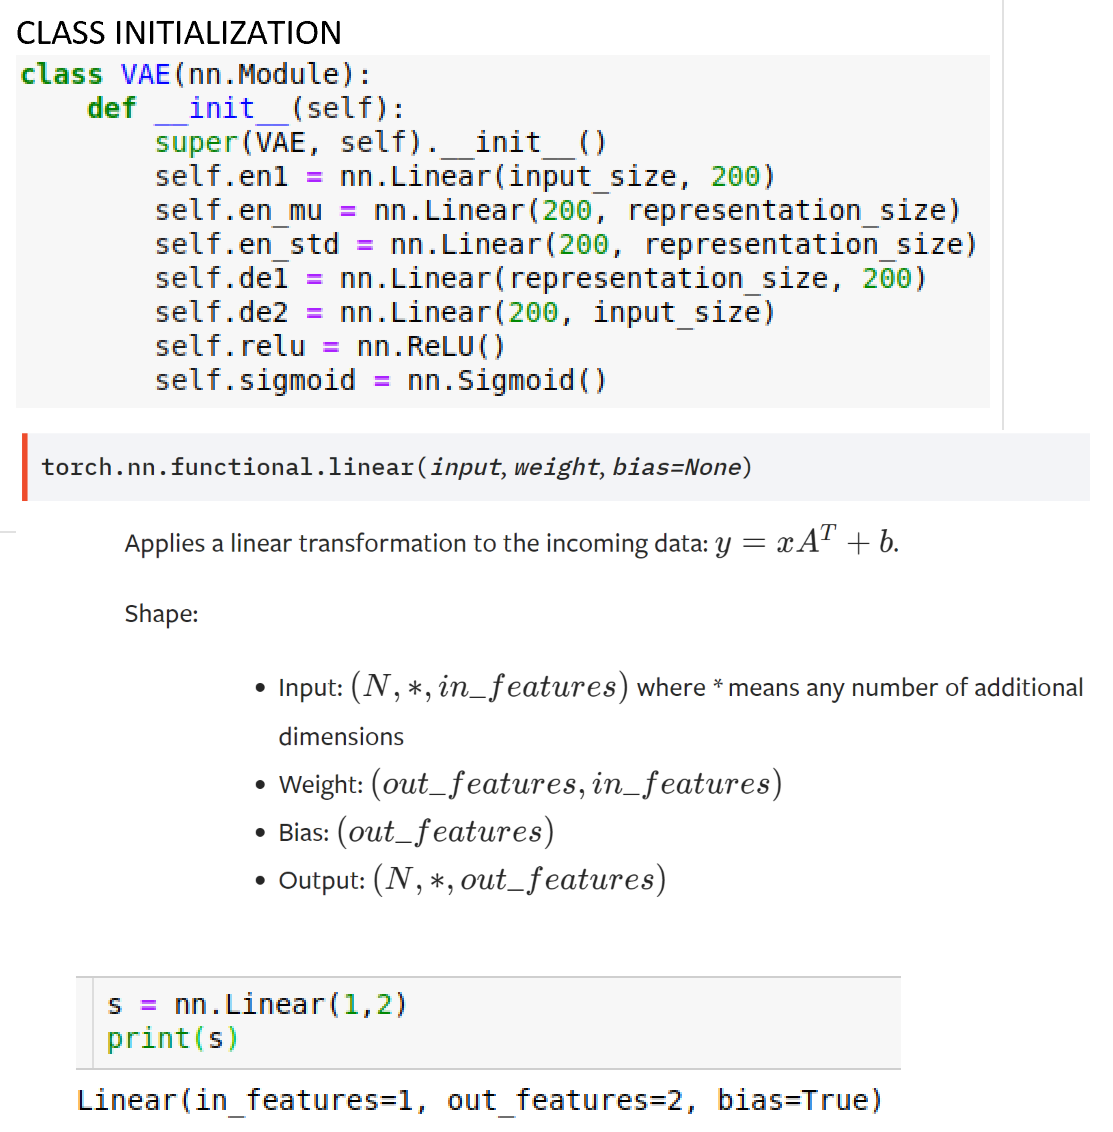

In [56]:
Image("img/initialization.PNG")

We initialize the VAE class by defining the Encoder that maps an array of 200 numbers to z-layer defined by the mean and sigma, with representation size of 2 (one neuron for mean and the other for sigma). The linear layer defines the weight matrix $A$ that implements this linear transformation.
As an opposite to that, decoder 1 decodes the latent space representation back to the 200-dimensional representation, making use of its own weight matrix.

In initialization, also the ReLu and Sigmoidal Activation functions are defined.

###  Methods defined in the VAE Class

#### Encoder (`encode`)

#### Decoder (`decode`)



#### Forward pass (`forward`)

#### Notice the absence of backward pass (`backward`)

If the sampling has been made differentiable, the backward method can be called on the loss directly!

#### Loss Computation (`loss`)

#### Get Latent Space Sample (`get_z`)

#### Reparametrization trick (`reparam`)


Let's now analyze the idea of the reparametriation trick in our example.
Recall that the posterior distribution of the parameters is the distribution of the parameters after having observed the data. 
In neural network context this means that the neural network has been trained.

We don't know what the (latent) posterior distribution of the one-hot encoded (unit) vectors should be, but we can model them to originate from the standard bivariate Gaussian distribution with unknown mean vector and unknown variance vector but with 0-correlations, since we know that the unit vectors are orthogonal to each other and  in that case, the off-diagonal covariances are 0.

Our goal is to find these true posterior distribution $q$ parameters $\vec{\mu}$ and $\vec{\sigma}$ -- that means that we would have learned their distribution.

From the theoretical part we know that the true posterior is approximated by the variational distribution $q_\varphi(z)$, where $\varphi = (\vec{\mu},\vec{\sigma})$ and to find that distribution, the variational (evidence) lower bound $\mathcal{L}$ has to be maximized w.r.t. $\varphi$. 

Recall that the evidence lower bound appears as the denominator in the Bayes' rule for finding the posterior distribution and it gives the lower bound for the probability of the data (evidence).

To maximize the variational lower bound $\mathcal{L}$, the derivatives of the variational distribution w.r.t. to $\varphi$ have to be computed in such a way that is not changed by resampling.

To be able to do that, denote the variatinal (evidence) lower bound by $\mathcal{L}$ and consider the following image:


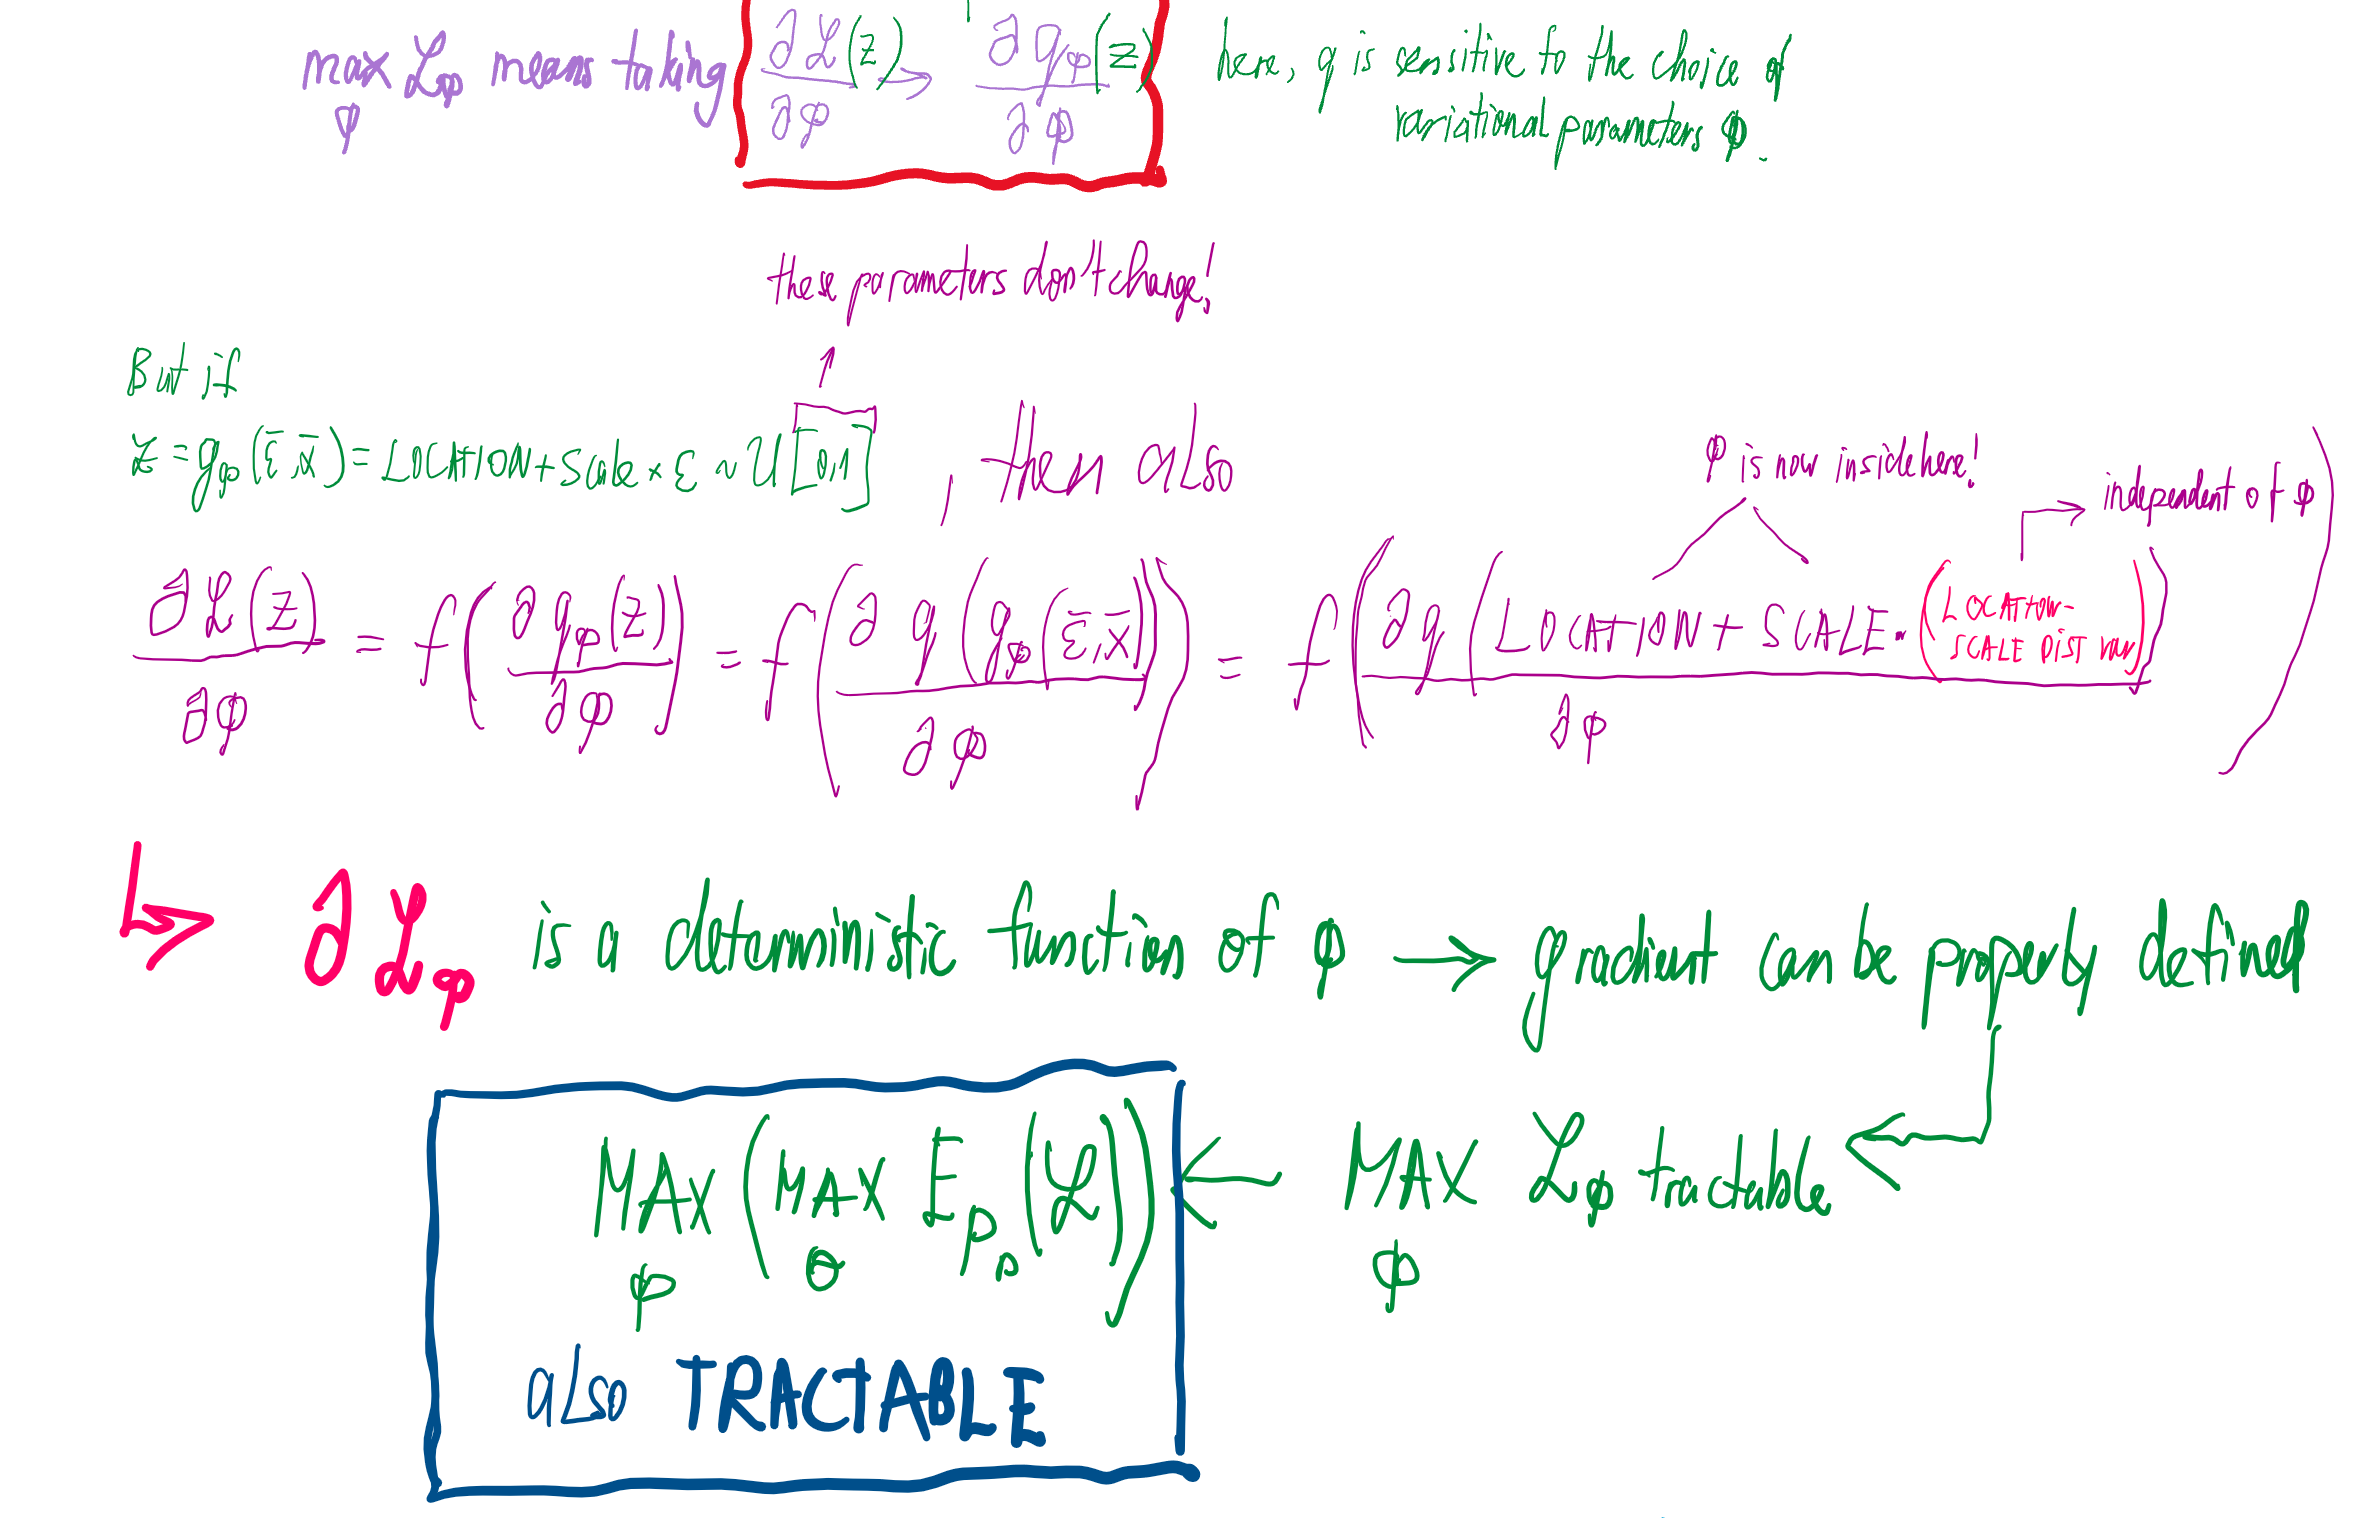

In [15]:
from IPython.display import Image
Image("img/reparam_trick.png")


In our model context this means that we can implement the reparametrization trick in the following form:

`  if self.training:
        std = logvar.mul(0.5).exp_()
        eps = Variable(std.data.new(std.size()).normal_())
        return eps.mul(std).add_(mu)
    else:
        return mu`

TRAINING MODE:
That means that given the the logarithm of variance (2x logarithm of std), we can invert to find the standard deviation and sample data of the same size as the batch from the standard normal distribution and store it as a Pytorch variable.
Adding $\mu$ and $\sigma$, we can get any arbitrary distribution from the *location-scale* family of distributions and now the *optimization procedure is independent on the starting conditions of sampling*.

TESTING MODE:
    

In [9]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.en1 = nn.Linear(input_size, 200)
        self.en_mu = nn.Linear(200, representation_size)
        self.en_std = nn.Linear(200, representation_size)
        self.de1 = nn.Linear(representation_size, 200)
        self.de2 = nn.Linear(200, input_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def encode(self, x):
        """Encode a batch of samples, and return posterior parameters for each point."""
        h1 = self.relu(self.en1(x))
        return self.en_mu(h1), self.en_std(h1)
    
    def decode(self, z):
        """Decode a batch of latent variables"""
        
        h2 = self.relu(self.de1(z))
        return self.sigmoid(self.de2(h2))
    
    def reparam(self, mu, logvar):
        """Reparameterisation trick to sample z values. 
        This is stochastic during training,  and returns the mode during evaluation."""
        
        if self.training:
            std = logvar.mul(0.5).exp_()
            print(std.size())
            print(std.data)
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
            
    def forward(self, x):
        """Takes a batch of samples, encodes them, and then decodes them again to compare."""
        mu, logvar = self.encode(x.view(-1, input_size))
        z = self.reparam(mu, logvar)
        return self.decode(z), mu, logvar
    
    def loss(self, reconstruction, x, mu, logvar):
        """ELBO assuming entries of x are binary variables, with closed form KLD."""
        bce = torch.nn.functional.binary_cross_entropy(reconstruction, x.view(-1, input_size))
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        # Normalise by same number of elements as in reconstruction
        KLD /= x.view(-1, input_size).data.shape[0] * input_size

        return bce + KLD
    
    def get_z(self, x):
        """Encode a batch of data points, x, into their z representations."""
        mu, logvar = self.encode(x.view(-1, input_size))
        return self.reparam(mu, logvar)
    
model = VAE()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [11]:
ind = np.arange(x.shape[0])
data = torch.from_numpy(x[np.random.choice(ind, size=batch_size)])
data = Variable(data, requires_grad=False)
model.train()



VAE(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en_mu): Linear(in_features=200, out_features=2, bias=True)
  (en_std): Linear(in_features=200, out_features=2, bias=True)
  (de1): Linear(in_features=2, out_features=200, bias=True)
  (de2): Linear(in_features=200, out_features=4, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [12]:
def train(epoch, batches_per_epoch = 501, log_interval=500):
    model.train()
    
    ind = np.arange(x.shape[0])
    for i in range(batches_per_epoch):
        data = torch.from_numpy(x[np.random.choice(ind, size=batch_size)])
        data = Variable(data, requires_grad=False)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = model.loss(recon_batch, data, mu, logvar)
        loss.backward()
        #train_loss += loss.data[0]
        optimizer.step()
        #if (i % log_interval == 0) and (epoch % 5 ==0):
            #Print progress
         #  print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
         #      epoch, i * batch_size, batch_size*batches_per_epoch,
         #      loss.data[0] / len(data)))

    print('====> Epoch: {} done!'.format(
          epoch))


def test(epoch, batches_per_epoch=1):
    model.eval()

    ind = np.arange(x.shape[0])
    for i in range(batches_per_epoch):
        
        data = torch.from_numpy(x[np.random.choice(ind, size=batch_size)])
        data = Variable(data, requires_grad=False)
        recon_batch, mu, logvar = model(data)
        if i == 0:
            n = min(data.size(0), 2)
            print(data.view(batch_size, 2,2)[:n])
            print(recon_batch.view(batch_size, 2,2)[:n])
            
            
print_examples = False #Change to true if you want to see some examples at each step!
for epoch in range(1, 30):
    train(epoch)
    if print_examples:
        test(epoch)

torch.Size([5, 2])
tensor([[1.1101, 1.0438],
        [1.1101, 1.0438],
        [1.0055, 1.0390],
        [1.0055, 1.0390],
        [1.1101, 1.0438]])
torch.Size([5, 2])
tensor([[1.0011, 1.0239],
        [1.0922, 1.0273],
        [1.0011, 1.0239],
        [1.0011, 1.0239],
        [1.1382, 1.0239]])
torch.Size([5, 2])
tensor([[1.0782, 1.0116],
        [1.1245, 1.0091],
        [1.1245, 1.0091],
        [0.9975, 1.0102],
        [0.9975, 1.0102]])
torch.Size([5, 2])
tensor([[1.1098, 0.9956],
        [0.9929, 0.9968],
        [0.9929, 0.9968],
        [1.0072, 1.0031],
        [1.1098, 0.9956]])
torch.Size([5, 2])
tensor([[1.0536, 0.9836],
        [0.9874, 0.9852],
        [1.0536, 0.9836],
        [0.9874, 0.9852],
        [0.9962, 0.9936]])
torch.Size([5, 2])
tensor([[1.0436, 0.9722],
        [0.9889, 0.9814],
        [0.9848, 0.9750],
        [0.9848, 0.9750],
        [1.0831, 0.9756]])
torch.Size([5, 2])
tensor([[0.9822, 0.9708],
        [0.9822, 0.9708],
        [0.9822, 0.9732],
   

tensor([[0.9708, 0.9716],
        [0.9708, 0.9716],
        [0.9830, 0.9676],
        [0.9959, 0.9604],
        [0.9959, 0.9604]])
torch.Size([5, 2])
tensor([[0.9796, 0.9637],
        [0.9700, 0.9705],
        [0.9844, 0.9828],
        [0.9957, 0.9573],
        [0.9700, 0.9705]])
torch.Size([5, 2])
tensor([[0.9809, 0.9801],
        [0.9809, 0.9801],
        [0.9809, 0.9801],
        [0.9698, 0.9695],
        [0.9769, 0.9609]])
torch.Size([5, 2])
tensor([[0.9698, 0.9658],
        [0.9748, 0.9570],
        [0.9698, 0.9658],
        [0.9785, 0.9766],
        [0.9785, 0.9766]])
torch.Size([5, 2])
tensor([[0.9719, 0.9559],
        [0.9742, 0.9767],
        [0.9953, 0.9512],
        [0.9719, 0.9559],
        [0.9674, 0.9655]])
torch.Size([5, 2])
tensor([[0.9930, 0.9519],
        [0.9694, 0.9769],
        [0.9658, 0.9562],
        [0.9658, 0.9562],
        [0.9930, 0.9519]])
torch.Size([5, 2])
tensor([[0.9906, 0.9532],
        [0.9906, 0.9532],
        [0.9619, 0.9776],
        [0.9619, 0.977

torch.Size([5, 2])
tensor([[0.9706, 0.9239],
        [0.9706, 0.9239],
        [0.9700, 0.8603],
        [1.0077, 0.9737],
        [0.9706, 0.9239]])
torch.Size([5, 2])
tensor([[1.0112, 0.9742],
        [0.9730, 0.8551],
        [0.9914, 0.9527],
        [0.9730, 0.8551],
        [0.9914, 0.9527]])
torch.Size([5, 2])
tensor([[1.0140, 0.9772],
        [0.9932, 0.9528],
        [1.0140, 0.9772],
        [0.9742, 0.9314],
        [1.0140, 0.9772]])
torch.Size([5, 2])
tensor([[0.9934, 0.9545],
        [0.9934, 0.9545],
        [1.0132, 0.9823],
        [0.9744, 0.9363],
        [0.9744, 0.9363]])
torch.Size([5, 2])
tensor([[0.9727, 0.9415],
        [0.9760, 0.8520],
        [0.9760, 0.8520],
        [0.9925, 0.9572],
        [0.9760, 0.8520]])
torch.Size([5, 2])
tensor([[1.0105, 0.9959],
        [1.0105, 0.9959],
        [0.9915, 0.9627],
        [0.9754, 0.8560],
        [1.0105, 0.9959]])
torch.Size([5, 2])
tensor([[0.9905, 0.9689],
        [1.0088, 1.0050],
        [0.9748, 0.8602],
   

torch.Size([5, 2])
tensor([[0.9795, 0.9835],
        [0.9350, 0.9574],
        [0.9350, 0.9574],
        [0.9350, 0.9574],
        [0.9340, 0.8911]])
torch.Size([5, 2])
tensor([[0.9803, 0.9804],
        [0.9317, 0.8903],
        [0.9840, 1.0243],
        [0.9840, 1.0243],
        [0.9336, 0.9556]])
torch.Size([5, 2])
tensor([[0.9276, 0.9538],
        [0.9279, 0.8899],
        [0.9276, 0.9538],
        [0.9789, 0.9776],
        [0.9279, 0.8899]])
torch.Size([5, 2])
tensor([[0.9229, 0.9520],
        [0.9833, 1.0324],
        [0.9229, 0.9520],
        [0.9778, 0.9758],
        [0.9229, 0.9520]])
torch.Size([5, 2])
tensor([[0.9205, 0.8927],
        [0.9844, 1.0358],
        [0.9786, 0.9747],
        [0.9197, 0.9509],
        [0.9197, 0.9509]])
torch.Size([5, 2])
tensor([[0.9186, 0.8951],
        [0.9785, 0.9750],
        [0.9174, 0.9514],
        [0.9186, 0.8951],
        [0.9186, 0.8951]])
torch.Size([5, 2])
tensor([[0.9771, 0.9739],
        [0.9771, 0.9739],
        [0.9771, 0.9739],
   

torch.Size([5, 2])
tensor([[0.9855, 0.9021],
        [0.9660, 0.8968],
        [0.9855, 0.9021],
        [0.9009, 0.8978],
        [0.9660, 0.8968]])
torch.Size([5, 2])
tensor([[0.9773, 0.8713],
        [0.9690, 0.9004],
        [0.9873, 0.9022],
        [0.9873, 0.9022],
        [0.9873, 0.9022]])
torch.Size([5, 2])
tensor([[0.9873, 0.9045],
        [0.9047, 0.9000],
        [0.9047, 0.9000],
        [0.9873, 0.9045],
        [0.9718, 0.9053]])
torch.Size([5, 2])
tensor([[0.9754, 0.9090],
        [0.9844, 0.8797],
        [0.9844, 0.8797],
        [0.9844, 0.8797],
        [0.9754, 0.9090]])
torch.Size([5, 2])
tensor([[0.9905, 0.9053],
        [0.9905, 0.9053],
        [0.9792, 0.9130],
        [0.9905, 0.9053],
        [0.9881, 0.8832]])
torch.Size([5, 2])
tensor([[0.9109, 0.9037],
        [0.9917, 0.8864],
        [0.9921, 0.9069],
        [0.9827, 0.9174],
        [0.9917, 0.8864]])
torch.Size([5, 2])
tensor([[0.9946, 0.8901],
        [0.9946, 0.8901],
        [0.9860, 0.9221],
   

        [0.9920, 0.8399]])
torch.Size([5, 2])
tensor([[0.9076, 0.7877],
        [0.9864, 0.8368],
        [0.9460, 0.8353],
        [0.9021, 0.8297],
        [0.9864, 0.8368]])
torch.Size([5, 2])
tensor([[0.9030, 0.7829],
        [0.9425, 0.8310],
        [0.8992, 0.8248],
        [0.8992, 0.8248],
        [0.9821, 0.8343]])
torch.Size([5, 2])
tensor([[0.8999, 0.7804],
        [0.9773, 0.8341],
        [0.8983, 0.8226],
        [0.8983, 0.8226],
        [0.8999, 0.7804]])
torch.Size([5, 2])
tensor([[0.9697, 0.8345],
        [0.8962, 0.8209],
        [0.9697, 0.8345],
        [0.8965, 0.7779],
        [0.8965, 0.7779]])
torch.Size([5, 2])
tensor([[0.8920, 0.8197],
        [0.9623, 0.8358],
        [0.8901, 0.7746],
        [0.8901, 0.7746],
        [0.9319, 0.8242]])
torch.Size([5, 2])
tensor([[0.9286, 0.8238],
        [0.9558, 0.8384],
        [0.8862, 0.7734],
        [0.8862, 0.7734],
        [0.8862, 0.7734]])
torch.Size([5, 2])
tensor([[0.8864, 0.8217],
        [0.9261, 0.8245],
  

torch.Size([5, 2])
tensor([[0.8973, 0.8477],
        [0.8973, 0.8477],
        [0.8973, 0.8477],
        [0.8366, 0.9023],
        [0.9165, 0.9332]])
torch.Size([5, 2])
tensor([[0.9048, 0.8446],
        [0.9048, 0.8446],
        [0.9248, 0.9307],
        [0.8419, 0.8988],
        [0.9248, 0.9307]])
torch.Size([5, 2])
tensor([[0.9128, 0.8409],
        [0.8115, 0.8500],
        [0.8478, 0.8949],
        [0.8115, 0.8500],
        [0.8115, 0.8500]])
torch.Size([5, 2])
tensor([[0.8187, 0.8481],
        [0.8187, 0.8481],
        [0.9414, 0.9250],
        [0.9414, 0.9250],
        [0.8187, 0.8481]])
torch.Size([5, 2])
tensor([[0.9504, 0.9241],
        [0.8613, 0.8901],
        [0.8264, 0.8452],
        [0.9298, 0.8360],
        [0.8613, 0.8901]])
torch.Size([5, 2])
tensor([[0.8666, 0.8886],
        [0.8336, 0.8434],
        [0.8666, 0.8886],
        [0.8336, 0.8434],
        [0.9582, 0.9239]])
torch.Size([5, 2])
tensor([[0.9673, 0.9251],
        [0.9436, 0.8330],
        [0.9436, 0.8330],
   

torch.Size([5, 2])
tensor([[0.8192, 0.7280],
        [0.8192, 0.7280],
        [0.8469, 0.7396],
        [0.8469, 0.7396],
        [0.8783, 0.8199]])
torch.Size([5, 2])
tensor([[0.8487, 0.7405],
        [0.8487, 0.7405],
        [0.8780, 0.8204],
        [0.8487, 0.7405],
        [0.8202, 0.7263]])
torch.Size([5, 2])
tensor([[0.8218, 0.7260],
        [0.8505, 0.7428],
        [0.8505, 0.7428],
        [0.8783, 0.8220],
        [0.8783, 0.8220]])
torch.Size([5, 2])
tensor([[0.8542, 0.7441],
        [0.9051, 0.8291],
        [0.8251, 0.7252],
        [0.8251, 0.7252],
        [0.9051, 0.8291]])
torch.Size([5, 2])
tensor([[0.9103, 0.8231],
        [0.9103, 0.8231],
        [0.8297, 0.7242],
        [0.9103, 0.8231],
        [0.9103, 0.8231]])
torch.Size([5, 2])
tensor([[0.8348, 0.7243],
        [0.9173, 0.8187],
        [0.8844, 0.8162],
        [0.9173, 0.8187],
        [0.8646, 0.7454]])
torch.Size([5, 2])
tensor([[0.9249, 0.8110],
        [0.8875, 0.8144],
        [0.8706, 0.7458],
   

torch.Size([5, 2])
tensor([[0.8314, 0.7556],
        [0.7668, 0.7995],
        [0.8117, 0.8500],
        [0.7511, 0.7873],
        [0.7511, 0.7873]])
torch.Size([5, 2])
tensor([[0.7626, 0.8025],
        [0.8058, 0.8523],
        [0.7461, 0.7888],
        [0.8058, 0.8523],
        [0.7461, 0.7888]])
torch.Size([5, 2])
tensor([[0.8010, 0.8540],
        [0.7584, 0.8055],
        [0.7405, 0.7905],
        [0.8010, 0.8540],
        [0.7584, 0.8055]])
torch.Size([5, 2])
tensor([[0.8160, 0.7635],
        [0.8160, 0.7635],
        [0.7564, 0.8100],
        [0.7361, 0.7937],
        [0.7564, 0.8100]])
torch.Size([5, 2])
tensor([[0.7562, 0.8149],
        [0.8149, 0.7676],
        [0.7562, 0.8149],
        [0.7977, 0.8612],
        [0.7334, 0.7972]])
torch.Size([5, 2])
tensor([[0.8164, 0.7712],
        [0.7993, 0.8640],
        [0.7993, 0.8640],
        [0.8164, 0.7712],
        [0.7329, 0.8005]])
torch.Size([5, 2])
tensor([[0.8040, 0.8653],
        [0.7625, 0.8215],
        [0.7625, 0.8215],
   

torch.Size([5, 2])
tensor([[0.8397, 0.7366],
        [0.8981, 0.7400],
        [0.8397, 0.7366],
        [0.8981, 0.7400],
        [0.8981, 0.7400]])
torch.Size([5, 2])
tensor([[0.8012, 0.8184],
        [0.7841, 0.7989],
        [0.7841, 0.7989],
        [0.7841, 0.7989],
        [0.8012, 0.8184]])
torch.Size([5, 2])
tensor([[0.8051, 0.8205],
        [0.8051, 0.8205],
        [0.7885, 0.8028],
        [0.8051, 0.8205],
        [0.8479, 0.7384]])
torch.Size([5, 2])
tensor([[0.8525, 0.7404],
        [0.7923, 0.8072],
        [0.8525, 0.7404],
        [0.7923, 0.8072],
        [0.8525, 0.7404]])
torch.Size([5, 2])
tensor([[0.8146, 0.8256],
        [0.8565, 0.7414],
        [0.9081, 0.7515],
        [0.9081, 0.7515],
        [0.8146, 0.8256]])
torch.Size([5, 2])
tensor([[0.9099, 0.7549],
        [0.9099, 0.7549],
        [0.8193, 0.8287],
        [0.8609, 0.7428],
        [0.8609, 0.7428]])
torch.Size([5, 2])
tensor([[0.8249, 0.8319],
        [0.8249, 0.8319],
        [0.8249, 0.8319],
   

torch.Size([5, 2])
tensor([[0.6764, 0.7556],
        [0.6764, 0.7556],
        [0.7380, 0.8162],
        [0.8007, 0.7268],
        [0.7643, 0.7321]])
torch.Size([5, 2])
tensor([[0.7373, 0.8132],
        [0.7632, 0.7299],
        [0.7632, 0.7299],
        [0.7373, 0.8132],
        [0.7957, 0.7260]])
torch.Size([5, 2])
tensor([[0.7625, 0.7280],
        [0.7625, 0.7280],
        [0.7625, 0.7280],
        [0.7365, 0.8106],
        [0.7365, 0.8106]])
torch.Size([5, 2])
tensor([[0.7372, 0.8094],
        [0.7372, 0.8094],
        [0.6706, 0.7534],
        [0.7372, 0.8094],
        [0.7644, 0.7274]])
torch.Size([5, 2])
tensor([[0.7667, 0.7245],
        [0.6702, 0.7504],
        [0.7878, 0.7234],
        [0.6702, 0.7504],
        [0.7878, 0.7234]])
torch.Size([5, 2])
tensor([[0.7876, 0.7217],
        [0.7694, 0.7208],
        [0.7876, 0.7217],
        [0.7694, 0.7208],
        [0.7373, 0.7923]])
torch.Size([5, 2])
tensor([[0.7386, 0.7853],
        [0.7733, 0.7173],
        [0.6728, 0.7465],
   

torch.Size([5, 2])
tensor([[0.7192, 0.6579],
        [0.7306, 0.7240],
        [0.7192, 0.6579],
        [0.6466, 0.7303],
        [0.6466, 0.7303]])
torch.Size([5, 2])
tensor([[0.7306, 0.7224],
        [0.7306, 0.7224],
        [0.6486, 0.7275],
        [0.7222, 0.6550],
        [0.7491, 0.6586]])
torch.Size([5, 2])
tensor([[0.6503, 0.7249],
        [0.7253, 0.6527],
        [0.7253, 0.6527],
        [0.7253, 0.6527],
        [0.7523, 0.6560]])
torch.Size([5, 2])
tensor([[0.6516, 0.7230],
        [0.7542, 0.6535],
        [0.6516, 0.7230],
        [0.7542, 0.6535],
        [0.7542, 0.6535]])
torch.Size([5, 2])
tensor([[0.6527, 0.7221],
        [0.6527, 0.7221],
        [0.6527, 0.7221],
        [0.7316, 0.7199],
        [0.7283, 0.6506]])
torch.Size([5, 2])
tensor([[0.7303, 0.7201],
        [0.7277, 0.6509],
        [0.7581, 0.6507],
        [0.6512, 0.7224],
        [0.7581, 0.6507]])
torch.Size([5, 2])
tensor([[0.7604, 0.6489],
        [0.7604, 0.6489],
        [0.6510, 0.7230],
   

torch.Size([5, 2])
tensor([[0.8138, 0.6483],
        [0.8138, 0.6483],
        [0.7325, 0.7339],
        [0.8315, 0.6396],
        [0.8138, 0.6483]])
torch.Size([5, 2])
tensor([[0.8141, 0.6438],
        [0.8141, 0.6438],
        [0.7319, 0.7284],
        [0.8141, 0.6438],
        [0.6399, 0.6862]])
torch.Size([5, 2])
tensor([[0.7322, 0.7236],
        [0.6402, 0.6822],
        [0.8347, 0.6286],
        [0.6402, 0.6822],
        [0.7322, 0.7236]])
torch.Size([5, 2])
tensor([[0.8162, 0.6384],
        [0.8376, 0.6239],
        [0.8162, 0.6384],
        [0.8162, 0.6384],
        [0.6416, 0.6793]])
torch.Size([5, 2])
tensor([[0.8410, 0.6208],
        [0.8185, 0.6379],
        [0.8410, 0.6208],
        [0.8185, 0.6379],
        [0.8185, 0.6379]])
torch.Size([5, 2])
tensor([[0.8447, 0.6198],
        [0.8447, 0.6198],
        [0.8447, 0.6198],
        [0.6462, 0.6780],
        [0.6462, 0.6780]])
torch.Size([5, 2])
tensor([[0.6496, 0.6778],
        [0.8264, 0.6397],
        [0.8264, 0.6397],
   

        [0.8487, 0.6991]])
torch.Size([5, 2])
tensor([[0.6545, 0.7184],
        [0.7922, 0.6059],
        [0.8508, 0.7009],
        [0.7172, 0.7277],
        [0.7172, 0.7277]])
torch.Size([5, 2])
tensor([[0.8532, 0.7020],
        [0.7920, 0.6058],
        [0.8532, 0.7020],
        [0.8532, 0.7020],
        [0.7169, 0.7288]])
torch.Size([5, 2])
tensor([[0.6537, 0.7198],
        [0.7162, 0.7300],
        [0.7919, 0.6061],
        [0.8546, 0.7023],
        [0.7919, 0.6061]])
torch.Size([5, 2])
tensor([[0.8531, 0.7025],
        [0.7906, 0.6074],
        [0.6521, 0.7213],
        [0.7906, 0.6074],
        [0.6521, 0.7213]])
torch.Size([5, 2])
tensor([[0.8525, 0.7034],
        [0.6508, 0.7227],
        [0.7094, 0.7339],
        [0.8525, 0.7034],
        [0.7094, 0.7339]])
torch.Size([5, 2])
tensor([[0.6507, 0.7245],
        [0.7907, 0.6120],
        [0.8534, 0.7047],
        [0.7081, 0.7365],
        [0.8534, 0.7047]])
torch.Size([5, 2])
tensor([[0.8550, 0.7030],
        [0.7924, 0.6133],
  

torch.Size([5, 2])
tensor([[0.7714, 0.6868],
        [0.7714, 0.6868],
        [0.7714, 0.6868],
        [0.5581, 0.7554],
        [0.7714, 0.6868]])
torch.Size([5, 2])
tensor([[0.7640, 0.6835],
        [0.5552, 0.7543],
        [0.7640, 0.6835],
        [0.7070, 0.7306],
        [0.7640, 0.6835]])
torch.Size([5, 2])
tensor([[0.7030, 0.7300],
        [0.7592, 0.6816],
        [0.7592, 0.6816],
        [0.7750, 0.6742],
        [0.7750, 0.6742]])
torch.Size([5, 2])
tensor([[0.7719, 0.6756],
        [0.5516, 0.7546],
        [0.7719, 0.6756],
        [0.7550, 0.6803],
        [0.6992, 0.7302]])
torch.Size([5, 2])
tensor([[0.6951, 0.7242],
        [0.6951, 0.7242],
        [0.7493, 0.6754],
        [0.6951, 0.7242],
        [0.5495, 0.7516]])
torch.Size([5, 2])
tensor([[0.5477, 0.7483],
        [0.6920, 0.7189],
        [0.7429, 0.6691],
        [0.7655, 0.6711],
        [0.7655, 0.6711]])
torch.Size([5, 2])
tensor([[0.7644, 0.6673],
        [0.7389, 0.6594],
        [0.7644, 0.6673],
   

torch.Size([5, 2])
tensor([[0.4492, 0.7200],
        [0.5969, 0.6422],
        [0.6072, 0.5899],
        [0.4492, 0.7200],
        [0.6047, 0.6067]])
torch.Size([5, 2])
tensor([[0.4532, 0.7214],
        [0.6116, 0.5912],
        [0.6116, 0.5912],
        [0.4532, 0.7214],
        [0.6094, 0.6063]])
torch.Size([5, 2])
tensor([[0.6148, 0.6066],
        [0.6045, 0.6461],
        [0.4579, 0.7235],
        [0.4579, 0.7235],
        [0.4579, 0.7235]])
torch.Size([5, 2])
tensor([[0.6204, 0.6072],
        [0.4625, 0.7253],
        [0.6086, 0.6482],
        [0.6204, 0.6072],
        [0.4625, 0.7253]])
torch.Size([5, 2])
tensor([[0.6266, 0.5950],
        [0.6264, 0.6073],
        [0.6264, 0.6073],
        [0.6266, 0.5950],
        [0.4668, 0.7238]])
torch.Size([5, 2])
tensor([[0.6168, 0.6507],
        [0.6302, 0.5943],
        [0.6168, 0.6507],
        [0.6302, 0.5943],
        [0.6168, 0.6507]])
torch.Size([5, 2])
tensor([[0.4727, 0.7183],
        [0.4727, 0.7183],
        [0.6192, 0.6487],
   

        [0.5173, 0.6818]])
torch.Size([5, 2])
tensor([[0.5163, 0.6801],
        [0.7150, 0.5987],
        [0.7143, 0.5368],
        [0.7143, 0.5368],
        [0.7143, 0.5368]])
torch.Size([5, 2])
tensor([[0.7100, 0.5347],
        [0.7100, 0.5347],
        [0.5146, 0.6767],
        [0.7100, 0.5347],
        [0.5146, 0.6767]])
torch.Size([5, 2])
tensor([[0.5134, 0.6748],
        [0.7070, 0.5340],
        [0.7149, 0.5960],
        [0.5134, 0.6748],
        [0.6553, 0.6100]])
torch.Size([5, 2])
tensor([[0.6528, 0.6035],
        [0.6528, 0.6035],
        [0.7022, 0.5323],
        [0.7022, 0.5323],
        [0.7137, 0.5943]])
torch.Size([5, 2])
tensor([[0.6988, 0.5312],
        [0.6515, 0.5981],
        [0.6988, 0.5312],
        [0.6515, 0.5981],
        [0.6988, 0.5312]])
torch.Size([5, 2])
tensor([[0.7119, 0.5900],
        [0.6964, 0.5316],
        [0.5050, 0.6678],
        [0.6502, 0.5942],
        [0.5050, 0.6678]])
torch.Size([5, 2])
tensor([[0.6490, 0.5910],
        [0.7113, 0.5889],
  

torch.Size([5, 2])
tensor([[0.6474, 0.6339],
        [0.7192, 0.6866],
        [0.6474, 0.6339],
        [0.6260, 0.6889],
        [0.5174, 0.7342]])
torch.Size([5, 2])
tensor([[0.6247, 0.6913],
        [0.6247, 0.6913],
        [0.6247, 0.6913],
        [0.6247, 0.6913],
        [0.7166, 0.6882]])
torch.Size([5, 2])
tensor([[0.6244, 0.6943],
        [0.6244, 0.6943],
        [0.6244, 0.6943],
        [0.6405, 0.6389],
        [0.5130, 0.7366]])
torch.Size([5, 2])
tensor([[0.7116, 0.6926],
        [0.6384, 0.6418],
        [0.6384, 0.6418],
        [0.7116, 0.6926],
        [0.5120, 0.7385]])
torch.Size([5, 2])
tensor([[0.6369, 0.6412],
        [0.5115, 0.7389],
        [0.5115, 0.7389],
        [0.7096, 0.6928],
        [0.5115, 0.7389]])
torch.Size([5, 2])
tensor([[0.6359, 0.6405],
        [0.6278, 0.7018],
        [0.7079, 0.6930],
        [0.6278, 0.7018],
        [0.5112, 0.7397]])
torch.Size([5, 2])
tensor([[0.6293, 0.7024],
        [0.5116, 0.7395],
        [0.6293, 0.7024],
   

torch.Size([5, 2])
tensor([[0.5933, 0.6334],
        [0.5933, 0.6334],
        [0.5933, 0.6334],
        [0.6203, 0.6103],
        [0.5874, 0.5708]])
torch.Size([5, 2])
tensor([[0.5903, 0.6342],
        [0.6174, 0.6121],
        [0.5903, 0.6342],
        [0.5838, 0.5712],
        [0.5838, 0.5712]])
torch.Size([5, 2])
tensor([[0.5815, 0.5719],
        [0.4420, 0.6401],
        [0.5885, 0.6356],
        [0.4420, 0.6401],
        [0.6156, 0.6142]])
torch.Size([5, 2])
tensor([[0.6142, 0.6163],
        [0.6142, 0.6163],
        [0.4422, 0.6420],
        [0.4422, 0.6420],
        [0.5799, 0.5728]])
torch.Size([5, 2])
tensor([[0.5854, 0.6387],
        [0.6133, 0.6192],
        [0.5782, 0.5743],
        [0.5854, 0.6387],
        [0.5854, 0.6387]])
torch.Size([5, 2])
tensor([[0.6124, 0.6217],
        [0.5770, 0.5758],
        [0.4420, 0.6469],
        [0.5770, 0.5758],
        [0.5770, 0.5758]])
torch.Size([5, 2])
tensor([[0.5828, 0.6415],
        [0.5763, 0.5767],
        [0.5828, 0.6415],
   

torch.Size([5, 2])
tensor([[0.6421, 0.6351],
        [0.6421, 0.6351],
        [0.6399, 0.6707],
        [0.6399, 0.6707],
        [0.6294, 0.6349]])
torch.Size([5, 2])
tensor([[0.5172, 0.7074],
        [0.6425, 0.6356],
        [0.6290, 0.6335],
        [0.6425, 0.6356],
        [0.6393, 0.6716]])
torch.Size([5, 2])
tensor([[0.6397, 0.6726],
        [0.6295, 0.6326],
        [0.5175, 0.7074],
        [0.6295, 0.6326],
        [0.6295, 0.6326]])
torch.Size([5, 2])
tensor([[0.6408, 0.6741],
        [0.6313, 0.6328],
        [0.6467, 0.6372],
        [0.6313, 0.6328],
        [0.6313, 0.6328]])
torch.Size([5, 2])
tensor([[0.6422, 0.6747],
        [0.6493, 0.6373],
        [0.6332, 0.6303],
        [0.6332, 0.6303],
        [0.6422, 0.6747]])
torch.Size([5, 2])
tensor([[0.6345, 0.6282],
        [0.6416, 0.6739],
        [0.6345, 0.6282],
        [0.6345, 0.6282],
        [0.6345, 0.6282]])
torch.Size([5, 2])
tensor([[0.6507, 0.6379],
        [0.5183, 0.7073],
        [0.6288, 0.6273],
   

torch.Size([5, 2])
tensor([[0.5971, 0.6421],
        [0.6255, 0.6224],
        [0.7180, 0.6072],
        [0.6255, 0.6224],
        [0.7180, 0.6072]])
torch.Size([5, 2])
tensor([[0.6248, 0.6233],
        [0.5970, 0.6441],
        [0.5970, 0.6441],
        [0.5970, 0.6441],
        [0.5970, 0.6441]])
torch.Size([5, 2])
tensor([[0.5946, 0.6465],
        [0.7157, 0.6077],
        [0.6235, 0.6247],
        [0.4935, 0.6861],
        [0.4935, 0.6861]])
torch.Size([5, 2])
tensor([[0.5912, 0.6489],
        [0.7139, 0.6087],
        [0.5912, 0.6489],
        [0.6210, 0.6265],
        [0.5912, 0.6489]])
torch.Size([5, 2])
tensor([[0.5885, 0.6517],
        [0.7121, 0.6099],
        [0.7121, 0.6099],
        [0.4907, 0.6894],
        [0.5885, 0.6517]])
torch.Size([5, 2])
tensor([[0.4901, 0.6918],
        [0.6144, 0.6301],
        [0.4901, 0.6918],
        [0.6144, 0.6301],
        [0.5870, 0.6550]])
torch.Size([5, 2])
tensor([[0.7117, 0.6142],
        [0.7117, 0.6142],
        [0.7117, 0.6142],
   

torch.Size([5, 2])
tensor([[0.5820, 0.6736],
        [0.6750, 0.6836],
        [0.4952, 0.7405],
        [0.4952, 0.7405],
        [0.6006, 0.7026]])
torch.Size([5, 2])
tensor([[0.5836, 0.6727],
        [0.6776, 0.6834],
        [0.4976, 0.7397],
        [0.6011, 0.6986],
        [0.6011, 0.6986]])
torch.Size([5, 2])
tensor([[0.4994, 0.7395],
        [0.4994, 0.7395],
        [0.5842, 0.6724],
        [0.6795, 0.6838],
        [0.5842, 0.6724]])
torch.Size([5, 2])
tensor([[0.6812, 0.6845],
        [0.5835, 0.6727],
        [0.5973, 0.6926],
        [0.5973, 0.6926],
        [0.6812, 0.6845]])
torch.Size([5, 2])
tensor([[0.5962, 0.6899],
        [0.5962, 0.6899],
        [0.5962, 0.6899],
        [0.6828, 0.6847],
        [0.5831, 0.6711]])
torch.Size([5, 2])
tensor([[0.5952, 0.6880],
        [0.6840, 0.6850],
        [0.5044, 0.7396],
        [0.6840, 0.6850],
        [0.6840, 0.6850]])
torch.Size([5, 2])
tensor([[0.5834, 0.6693],
        [0.5834, 0.6693],
        [0.5950, 0.6863],
   

tensor([[0.5929, 0.6239],
        [0.6204, 0.5903],
        [0.6001, 0.6533],
        [0.6001, 0.6533],
        [0.6204, 0.5903]])
torch.Size([5, 2])
tensor([[0.6194, 0.5914],
        [0.6194, 0.5914],
        [0.6194, 0.5914],
        [0.5002, 0.6575],
        [0.5922, 0.6260]])
torch.Size([5, 2])
tensor([[0.4989, 0.6585],
        [0.6196, 0.5936],
        [0.6196, 0.5936],
        [0.6196, 0.5936],
        [0.6196, 0.5936]])
torch.Size([5, 2])
tensor([[0.6028, 0.6573],
        [0.5916, 0.6311],
        [0.4977, 0.6593],
        [0.5916, 0.6311],
        [0.4977, 0.6593]])
torch.Size([5, 2])
tensor([[0.6028, 0.6588],
        [0.5882, 0.6335],
        [0.6028, 0.6588],
        [0.6171, 0.5986],
        [0.6171, 0.5986]])
torch.Size([5, 2])
tensor([[0.6164, 0.6003],
        [0.4951, 0.6608],
        [0.4951, 0.6608],
        [0.6034, 0.6593],
        [0.6034, 0.6593]])
torch.Size([5, 2])
tensor([[0.6167, 0.6010],
        [0.6043, 0.6598],
        [0.4946, 0.6611],
        [0.6167, 0.601

tensor([[0.5397, 0.5519],
        [0.4970, 0.6026],
        [0.5920, 0.5375],
        [0.5920, 0.5375],
        [0.5736, 0.5652]])
torch.Size([5, 2])
tensor([[0.4987, 0.6005],
        [0.5758, 0.5637],
        [0.4987, 0.6005],
        [0.5418, 0.5498],
        [0.4987, 0.6005]])
torch.Size([5, 2])
tensor([[0.5785, 0.5627],
        [0.5444, 0.5481],
        [0.5785, 0.5627],
        [0.5012, 0.5992],
        [0.5444, 0.5481]])
torch.Size([5, 2])
tensor([[0.5784, 0.5612],
        [0.5019, 0.5980],
        [0.5784, 0.5612],
        [0.5784, 0.5612],
        [0.5019, 0.5980]])
torch.Size([5, 2])
tensor([[0.5938, 0.5390],
        [0.5032, 0.5975],
        [0.5480, 0.5461],
        [0.5480, 0.5461],
        [0.5480, 0.5461]])
torch.Size([5, 2])
tensor([[0.5945, 0.5398],
        [0.5945, 0.5398],
        [0.5498, 0.5453],
        [0.5498, 0.5453],
        [0.5945, 0.5398]])
torch.Size([5, 2])
tensor([[0.5502, 0.5439],
        [0.5057, 0.5966],
        [0.5812, 0.5599],
        [0.5057, 0.596

torch.Size([5, 2])
tensor([[0.4731, 0.6089],
        [0.4731, 0.6089],
        [0.6192, 0.5619],
        [0.5294, 0.5782],
        [0.5442, 0.5576]])
torch.Size([5, 2])
tensor([[0.5396, 0.5581],
        [0.5277, 0.5787],
        [0.6209, 0.5640],
        [0.4724, 0.6092],
        [0.5396, 0.5581]])
torch.Size([5, 2])
tensor([[0.4712, 0.6096],
        [0.4712, 0.6096],
        [0.6215, 0.5659],
        [0.5258, 0.5793],
        [0.5335, 0.5580]])
torch.Size([5, 2])
tensor([[0.5245, 0.5800],
        [0.4707, 0.6101],
        [0.6220, 0.5666],
        [0.6220, 0.5666],
        [0.4707, 0.6101]])
torch.Size([5, 2])
tensor([[0.4699, 0.6112],
        [0.5234, 0.5582],
        [0.5232, 0.5811],
        [0.6198, 0.5677],
        [0.4699, 0.6112]])
torch.Size([5, 2])
tensor([[0.4696, 0.6131],
        [0.4696, 0.6131],
        [0.5192, 0.5590],
        [0.5192, 0.5590],
        [0.5192, 0.5590]])
torch.Size([5, 2])
tensor([[0.5218, 0.5843],
        [0.5218, 0.5843],
        [0.5156, 0.5600],
   

tensor([[0.5128, 0.6008],
        [0.6075, 0.5768],
        [0.6075, 0.5768],
        [0.6075, 0.5768],
        [0.5128, 0.6008]])
torch.Size([5, 2])
tensor([[0.5123, 0.5996],
        [0.4586, 0.6251],
        [0.5123, 0.5996],
        [0.5635, 0.5444],
        [0.6088, 0.5749]])
torch.Size([5, 2])
tensor([[0.6093, 0.5729],
        [0.5633, 0.5417],
        [0.5120, 0.5983],
        [0.6093, 0.5729],
        [0.4588, 0.6239]])
torch.Size([5, 2])
tensor([[0.5113, 0.5973],
        [0.6068, 0.5714],
        [0.6068, 0.5714],
        [0.6068, 0.5714],
        [0.5113, 0.5973]])
torch.Size([5, 2])
tensor([[0.5621, 0.5380],
        [0.5115, 0.5971],
        [0.5115, 0.5971],
        [0.5621, 0.5380],
        [0.5115, 0.5971]])
torch.Size([5, 2])
tensor([[0.5624, 0.5369],
        [0.5124, 0.5975],
        [0.5124, 0.5975],
        [0.6048, 0.5710],
        [0.4584, 0.6215]])
torch.Size([5, 2])
tensor([[0.6025, 0.5703],
        [0.6025, 0.5703],
        [0.4580, 0.6207],
        [0.5110, 0.596

torch.Size([5, 2])
tensor([[0.5152, 0.5699],
        [0.5710, 0.5761],
        [0.4331, 0.6632],
        [0.5710, 0.5761],
        [0.5710, 0.5761]])
torch.Size([5, 2])
tensor([[0.4350, 0.6624],
        [0.4833, 0.6314],
        [0.5716, 0.5731],
        [0.4350, 0.6624],
        [0.5716, 0.5731]])
torch.Size([5, 2])
tensor([[0.4839, 0.6314],
        [0.4368, 0.6621],
        [0.5174, 0.5703],
        [0.5174, 0.5703],
        [0.4368, 0.6621]])
torch.Size([5, 2])
tensor([[0.5191, 0.5709],
        [0.4389, 0.6619],
        [0.5738, 0.5692],
        [0.4389, 0.6619],
        [0.4848, 0.6316]])
torch.Size([5, 2])
tensor([[0.4862, 0.6309],
        [0.5211, 0.5710],
        [0.5755, 0.5671],
        [0.5211, 0.5710],
        [0.5755, 0.5671]])
torch.Size([5, 2])
tensor([[0.4432, 0.6579],
        [0.5239, 0.5713],
        [0.5780, 0.5645],
        [0.5780, 0.5645],
        [0.5780, 0.5645]])
torch.Size([5, 2])
tensor([[0.5787, 0.5618],
        [0.4449, 0.6563],
        [0.4449, 0.6563],
   

torch.Size([5, 2])
tensor([[0.3877, 0.5757],
        [0.3877, 0.5757],
        [0.5749, 0.5458],
        [0.4800, 0.5751],
        [0.5749, 0.5458]])
torch.Size([5, 2])
tensor([[0.5767, 0.5446],
        [0.5178, 0.5481],
        [0.3905, 0.5762],
        [0.5767, 0.5446],
        [0.5178, 0.5481]])
torch.Size([5, 2])
tensor([[0.4843, 0.5752],
        [0.3933, 0.5770],
        [0.3933, 0.5770],
        [0.4843, 0.5752],
        [0.5788, 0.5440]])
torch.Size([5, 2])
tensor([[0.5809, 0.5441],
        [0.3960, 0.5786],
        [0.3960, 0.5786],
        [0.4856, 0.5760],
        [0.4856, 0.5760]])
torch.Size([5, 2])
tensor([[0.3990, 0.5808],
        [0.4868, 0.5772],
        [0.3990, 0.5808],
        [0.5256, 0.5507],
        [0.4868, 0.5772]])
torch.Size([5, 2])
tensor([[0.5286, 0.5523],
        [0.5859, 0.5458],
        [0.4887, 0.5785],
        [0.5286, 0.5523],
        [0.4024, 0.5834]])
torch.Size([5, 2])
tensor([[0.4905, 0.5804],
        [0.5314, 0.5545],
        [0.4905, 0.5804],
   

tensor([[0.5558, 0.5705],
        [0.5301, 0.5981],
        [0.5301, 0.5981],
        [0.5301, 0.5981],
        [0.5558, 0.5705]])
torch.Size([5, 2])
tensor([[0.5586, 0.5735],
        [0.5327, 0.6001],
        [0.5327, 0.6001],
        [0.4474, 0.5865],
        [0.5327, 0.6001]])
torch.Size([5, 2])
tensor([[0.5359, 0.6023],
        [0.5618, 0.5763],
        [0.5618, 0.5763],
        [0.5618, 0.5763],
        [0.5775, 0.5643]])
torch.Size([5, 2])
tensor([[0.4496, 0.5877],
        [0.5811, 0.5662],
        [0.4496, 0.5877],
        [0.5651, 0.5796],
        [0.5651, 0.5796]])
torch.Size([5, 2])
tensor([[0.5680, 0.5829],
        [0.5826, 0.5678],
        [0.4501, 0.5884],
        [0.5680, 0.5829],
        [0.5680, 0.5829]])
torch.Size([5, 2])
tensor([[0.4504, 0.5888],
        [0.4504, 0.5888],
        [0.4504, 0.5888],
        [0.5841, 0.5688],
        [0.5707, 0.5860]])
torch.Size([5, 2])
tensor([[0.4515, 0.5893],
        [0.5858, 0.5699],
        [0.5464, 0.6106],
        [0.5739, 0.588

torch.Size([5, 2])
tensor([[0.5405, 0.6372],
        [0.5405, 0.6372],
        [0.4665, 0.7006],
        [0.5405, 0.6372],
        [0.4665, 0.7006]])
torch.Size([5, 2])
tensor([[0.5343, 0.6331],
        [0.5084, 0.6228],
        [0.5084, 0.6228],
        [0.5949, 0.6815],
        [0.5084, 0.6228]])
torch.Size([5, 2])
tensor([[0.4621, 0.6964],
        [0.5294, 0.6300],
        [0.5294, 0.6300],
        [0.5931, 0.6784],
        [0.5294, 0.6300]])
torch.Size([5, 2])
tensor([[0.5066, 0.6206],
        [0.5066, 0.6206],
        [0.5917, 0.6748],
        [0.4605, 0.6940],
        [0.5917, 0.6748]])
torch.Size([5, 2])
tensor([[0.5197, 0.6200],
        [0.4586, 0.6915],
        [0.5197, 0.6200],
        [0.5058, 0.6193],
        [0.5058, 0.6193]])
torch.Size([5, 2])
tensor([[0.5856, 0.6653],
        [0.5157, 0.6154],
        [0.5052, 0.6183],
        [0.5157, 0.6154],
        [0.5157, 0.6154]])
torch.Size([5, 2])
tensor([[0.4561, 0.6879],
        [0.5053, 0.6178],
        [0.5837, 0.6618],
   

tensor([[0.5963, 0.5726],
        [0.5417, 0.5600],
        [0.5682, 0.5471],
        [0.5417, 0.5600],
        [0.5417, 0.5600]])
torch.Size([5, 2])
tensor([[0.4738, 0.6263],
        [0.5420, 0.5608],
        [0.5420, 0.5608],
        [0.5699, 0.5488],
        [0.5420, 0.5608]])
torch.Size([5, 2])
tensor([[0.5984, 0.5728],
        [0.5719, 0.5505],
        [0.5719, 0.5505],
        [0.5428, 0.5616],
        [0.5719, 0.5505]])
torch.Size([5, 2])
tensor([[0.4752, 0.6267],
        [0.5440, 0.5628],
        [0.5999, 0.5734],
        [0.5999, 0.5734],
        [0.5742, 0.5528]])
torch.Size([5, 2])
tensor([[0.4763, 0.6277],
        [0.5768, 0.5554],
        [0.6020, 0.5747],
        [0.6020, 0.5747],
        [0.6020, 0.5747]])
torch.Size([5, 2])
tensor([[0.6048, 0.5758],
        [0.5794, 0.5574],
        [0.5470, 0.5653],
        [0.5470, 0.5653],
        [0.6048, 0.5758]])
torch.Size([5, 2])
tensor([[0.5488, 0.5667],
        [0.5488, 0.5667],
        [0.5822, 0.5597],
        [0.4791, 0.628

        [0.4119, 0.6123]])
torch.Size([5, 2])
tensor([[0.5316, 0.5687],
        [0.4407, 0.5402],
        [0.4110, 0.6112],
        [0.5316, 0.5687],
        [0.5107, 0.5357]])
torch.Size([5, 2])
tensor([[0.4106, 0.6110],
        [0.5114, 0.5347],
        [0.4419, 0.5407],
        [0.5330, 0.5698],
        [0.5330, 0.5698]])
torch.Size([5, 2])
tensor([[0.5126, 0.5343],
        [0.4433, 0.5416],
        [0.5349, 0.5713],
        [0.5126, 0.5343],
        [0.5349, 0.5713]])
torch.Size([5, 2])
tensor([[0.5141, 0.5339],
        [0.5141, 0.5339],
        [0.4451, 0.5428],
        [0.4112, 0.6115],
        [0.5141, 0.5339]])
torch.Size([5, 2])
tensor([[0.5163, 0.5345],
        [0.5163, 0.5345],
        [0.4472, 0.5444],
        [0.5163, 0.5345],
        [0.5163, 0.5345]])
torch.Size([5, 2])
tensor([[0.5424, 0.5773],
        [0.5424, 0.5773],
        [0.5424, 0.5773],
        [0.4493, 0.5460],
        [0.5424, 0.5773]])
torch.Size([5, 2])
tensor([[0.5206, 0.5365],
        [0.5206, 0.5365],
  

torch.Size([5, 2])
tensor([[0.5656, 0.5992],
        [0.5379, 0.5736],
        [0.4444, 0.6180],
        [0.5656, 0.5992],
        [0.4444, 0.6180]])
torch.Size([5, 2])
tensor([[0.5658, 0.6014],
        [0.5658, 0.6014],
        [0.5181, 0.5896],
        [0.5375, 0.5757],
        [0.5375, 0.5757]])
torch.Size([5, 2])
tensor([[0.4452, 0.6225],
        [0.5668, 0.6040],
        [0.5668, 0.6040],
        [0.5668, 0.6040],
        [0.5668, 0.6040]])
torch.Size([5, 2])
tensor([[0.5688, 0.6074],
        [0.4462, 0.6252],
        [0.4462, 0.6252],
        [0.4462, 0.6252],
        [0.5385, 0.5810]])
torch.Size([5, 2])
tensor([[0.5209, 0.5965],
        [0.5714, 0.6108],
        [0.5397, 0.5839],
        [0.5397, 0.5839],
        [0.5209, 0.5965]])
torch.Size([5, 2])
tensor([[0.5223, 0.5985],
        [0.5402, 0.5861],
        [0.4495, 0.6311],
        [0.5739, 0.6140],
        [0.5223, 0.5985]])
torch.Size([5, 2])
tensor([[0.5409, 0.5884],
        [0.5409, 0.5884],
        [0.5760, 0.6166],
   

torch.Size([5, 2])
tensor([[0.4402, 0.6162],
        [0.5624, 0.6094],
        [0.5221, 0.5572],
        [0.4402, 0.6162],
        [0.5624, 0.6094]])
torch.Size([5, 2])
tensor([[0.4392, 0.6174],
        [0.5378, 0.5837],
        [0.5611, 0.6105],
        [0.4392, 0.6174],
        [0.5611, 0.6105]])
torch.Size([5, 2])
tensor([[0.5191, 0.5572],
        [0.5603, 0.6116],
        [0.5378, 0.5839],
        [0.5378, 0.5839],
        [0.5603, 0.6116]])
torch.Size([5, 2])
tensor([[0.5171, 0.5573],
        [0.4368, 0.6182],
        [0.4368, 0.6182],
        [0.5354, 0.5837],
        [0.5171, 0.5573]])
torch.Size([5, 2])
tensor([[0.5315, 0.5837],
        [0.5582, 0.6145],
        [0.5582, 0.6145],
        [0.4353, 0.6192],
        [0.5582, 0.6145]])
torch.Size([5, 2])
tensor([[0.4340, 0.6197],
        [0.5566, 0.6147],
        [0.4340, 0.6197],
        [0.4340, 0.6197],
        [0.4340, 0.6197]])
torch.Size([5, 2])
tensor([[0.5554, 0.6149],
        [0.5252, 0.5828],
        [0.5252, 0.5828],
   

torch.Size([5, 2])
tensor([[0.4838, 0.5588],
        [0.5467, 0.5971],
        [0.4189, 0.6418],
        [0.4991, 0.5829],
        [0.4991, 0.5829]])
torch.Size([5, 2])
tensor([[0.4848, 0.5575],
        [0.4848, 0.5575],
        [0.4193, 0.6396],
        [0.4848, 0.5575],
        [0.4848, 0.5575]])
torch.Size([5, 2])
tensor([[0.4862, 0.5569],
        [0.4862, 0.5569],
        [0.4862, 0.5569],
        [0.4985, 0.5781],
        [0.4200, 0.6381]])
torch.Size([5, 2])
tensor([[0.5484, 0.5941],
        [0.4976, 0.5757],
        [0.4976, 0.5757],
        [0.5484, 0.5941],
        [0.4976, 0.5757]])
torch.Size([5, 2])
tensor([[0.4967, 0.5737],
        [0.4967, 0.5737],
        [0.5460, 0.5913],
        [0.4967, 0.5737],
        [0.4847, 0.5527]])
torch.Size([5, 2])
tensor([[0.4169, 0.6313],
        [0.5442, 0.5890],
        [0.5442, 0.5890],
        [0.5442, 0.5890],
        [0.4963, 0.5722]])
torch.Size([5, 2])
tensor([[0.4938, 0.5705],
        [0.5423, 0.5874],
        [0.4823, 0.5482],
   

tensor([[0.5384, 0.6004],
        [0.5384, 0.6004],
        [0.4552, 0.6594],
        [0.5237, 0.5964],
        [0.5237, 0.5964]])
torch.Size([5, 2])
tensor([[0.5408, 0.6020],
        [0.5408, 0.6020],
        [0.5408, 0.6020],
        [0.5251, 0.5971],
        [0.4575, 0.6607]])
torch.Size([5, 2])
tensor([[0.4601, 0.6623],
        [0.5436, 0.6040],
        [0.4601, 0.6623],
        [0.4601, 0.6623],
        [0.5436, 0.6040]])
torch.Size([5, 2])
tensor([[0.5273, 0.5991],
        [0.5453, 0.6056],
        [0.5561, 0.5954],
        [0.5561, 0.5954],
        [0.5453, 0.6056]])
torch.Size([5, 2])
tensor([[0.4589, 0.6632],
        [0.5569, 0.5957],
        [0.5473, 0.6075],
        [0.4589, 0.6632],
        [0.5280, 0.5998]])
torch.Size([5, 2])
tensor([[0.5575, 0.5947],
        [0.5493, 0.6087],
        [0.5575, 0.5947],
        [0.5493, 0.6087],
        [0.5575, 0.5947]])
torch.Size([5, 2])
tensor([[0.4586, 0.6621],
        [0.5517, 0.6105],
        [0.5517, 0.6105],
        [0.5517, 0.610

torch.Size([5, 2])
tensor([[0.4202, 0.6579],
        [0.5039, 0.5921],
        [0.4202, 0.6579],
        [0.5039, 0.5921],
        [0.5451, 0.6178]])
torch.Size([5, 2])
tensor([[0.5448, 0.6168],
        [0.5239, 0.6053],
        [0.5448, 0.6168],
        [0.4198, 0.6572],
        [0.4198, 0.6572]])
torch.Size([5, 2])
tensor([[0.5441, 0.6160],
        [0.5023, 0.5921],
        [0.4179, 0.6560],
        [0.5441, 0.6160],
        [0.5441, 0.6160]])
torch.Size([5, 2])
tensor([[0.4164, 0.6553],
        [0.5235, 0.6047],
        [0.5015, 0.5923],
        [0.5235, 0.6047],
        [0.4164, 0.6553]])
torch.Size([5, 2])
tensor([[0.5431, 0.6154],
        [0.5014, 0.5930],
        [0.5014, 0.5930],
        [0.4155, 0.6553],
        [0.5240, 0.6051]])
torch.Size([5, 2])
tensor([[0.4151, 0.6558],
        [0.5250, 0.6059],
        [0.5018, 0.5940],
        [0.5018, 0.5940],
        [0.5250, 0.6059]])
torch.Size([5, 2])
tensor([[0.5440, 0.6164],
        [0.4151, 0.6564],
        [0.5028, 0.5955],
   

torch.Size([5, 2])
tensor([[0.4941, 0.5611],
        [0.4893, 0.5724],
        [0.3790, 0.6040],
        [0.4893, 0.5724],
        [0.4941, 0.5611]])
torch.Size([5, 2])
tensor([[0.3785, 0.6062],
        [0.3785, 0.6062],
        [0.3785, 0.6062],
        [0.4936, 0.5625],
        [0.4936, 0.5625]])
torch.Size([5, 2])
tensor([[0.3775, 0.6081],
        [0.4907, 0.5501],
        [0.3775, 0.6081],
        [0.3775, 0.6081],
        [0.3775, 0.6081]])
torch.Size([5, 2])
tensor([[0.3772, 0.6104],
        [0.3772, 0.6104],
        [0.3772, 0.6104],
        [0.3772, 0.6104],
        [0.3772, 0.6104]])
torch.Size([5, 2])
tensor([[0.4910, 0.5524],
        [0.3769, 0.6129],
        [0.4911, 0.5799],
        [0.4910, 0.5524],
        [0.4911, 0.5799]])
torch.Size([5, 2])
tensor([[0.4913, 0.5535],
        [0.3766, 0.6148],
        [0.4909, 0.5811],
        [0.4929, 0.5680],
        [0.3766, 0.6148]])
torch.Size([5, 2])
tensor([[0.4933, 0.5696],
        [0.4913, 0.5827],
        [0.4933, 0.5696],
   

torch.Size([5, 2])
tensor([[0.3859, 0.5770],
        [0.4894, 0.5546],
        [0.4909, 0.5177],
        [0.3859, 0.5770],
        [0.5103, 0.5481]])
torch.Size([5, 2])
tensor([[0.3865, 0.5775],
        [0.4900, 0.5542],
        [0.4919, 0.5176],
        [0.4919, 0.5176],
        [0.3865, 0.5775]])
torch.Size([5, 2])
tensor([[0.4906, 0.5531],
        [0.4924, 0.5152],
        [0.3870, 0.5771],
        [0.4906, 0.5531],
        [0.3870, 0.5771]])
torch.Size([5, 2])
tensor([[0.4909, 0.5523],
        [0.4909, 0.5523],
        [0.3878, 0.5774],
        [0.3878, 0.5774],
        [0.4931, 0.5133]])
torch.Size([5, 2])
tensor([[0.5112, 0.5441],
        [0.4909, 0.5519],
        [0.4909, 0.5519],
        [0.4939, 0.5121],
        [0.4909, 0.5519]])
torch.Size([5, 2])
tensor([[0.4916, 0.5517],
        [0.4951, 0.5111],
        [0.3900, 0.5789],
        [0.3900, 0.5789],
        [0.5120, 0.5437]])
torch.Size([5, 2])
tensor([[0.4927, 0.5521],
        [0.4968, 0.5107],
        [0.5133, 0.5439],
   

torch.Size([5, 2])
tensor([[0.3792, 0.6710],
        [0.5140, 0.5677],
        [0.3792, 0.6710],
        [0.4907, 0.5961],
        [0.4907, 0.5961]])
torch.Size([5, 2])
tensor([[0.5153, 0.5662],
        [0.5153, 0.5662],
        [0.5153, 0.5662],
        [0.5259, 0.6110],
        [0.5153, 0.5662]])
torch.Size([5, 2])
tensor([[0.5171, 0.5655],
        [0.5279, 0.6117],
        [0.5171, 0.5655],
        [0.3821, 0.6701],
        [0.3821, 0.6701]])
torch.Size([5, 2])
tensor([[0.5188, 0.5655],
        [0.3829, 0.6705],
        [0.3829, 0.6705],
        [0.5188, 0.5655],
        [0.5188, 0.5655]])
torch.Size([5, 2])
tensor([[0.4942, 0.5936],
        [0.3834, 0.6699],
        [0.4942, 0.5936],
        [0.4942, 0.5936],
        [0.3834, 0.6699]])
torch.Size([5, 2])
tensor([[0.5192, 0.5633],
        [0.4953, 0.5936],
        [0.4953, 0.5936],
        [0.5192, 0.5633],
        [0.5192, 0.5633]])
torch.Size([5, 2])
tensor([[0.4966, 0.5935],
        [0.4966, 0.5935],
        [0.5194, 0.5617],
   

torch.Size([5, 2])
tensor([[0.4955, 0.5680],
        [0.3808, 0.6807],
        [0.4915, 0.6244],
        [0.3808, 0.6807],
        [0.4915, 0.6244]])
torch.Size([5, 2])
tensor([[0.3815, 0.6808],
        [0.4969, 0.5693],
        [0.4914, 0.6242],
        [0.4914, 0.6242],
        [0.4969, 0.5693]])
torch.Size([5, 2])
tensor([[0.5246, 0.6301],
        [0.5246, 0.6301],
        [0.4915, 0.6244],
        [0.3822, 0.6812],
        [0.3822, 0.6812]])
torch.Size([5, 2])
tensor([[0.5252, 0.6306],
        [0.3824, 0.6811],
        [0.4915, 0.6243],
        [0.4915, 0.6243],
        [0.4915, 0.6243]])
torch.Size([5, 2])
tensor([[0.4995, 0.5719],
        [0.5260, 0.6310],
        [0.3830, 0.6808],
        [0.4995, 0.5719],
        [0.5260, 0.6310]])
torch.Size([5, 2])
tensor([[0.3837, 0.6809],
        [0.4920, 0.6223],
        [0.5271, 0.6315],
        [0.5003, 0.5726],
        [0.4920, 0.6223]])
torch.Size([5, 2])
tensor([[0.5011, 0.5719],
        [0.5011, 0.5719],
        [0.5011, 0.5719],
   

tensor([[0.4829, 0.5849],
        [0.4829, 0.5849],
        [0.4666, 0.5440],
        [0.4829, 0.5849],
        [0.5112, 0.6155]])
torch.Size([5, 2])
tensor([[0.3724, 0.6510],
        [0.3724, 0.6510],
        [0.3724, 0.6510],
        [0.5128, 0.6163],
        [0.5128, 0.6163]])
torch.Size([5, 2])
tensor([[0.5130, 0.6171],
        [0.4836, 0.5859],
        [0.4836, 0.5859],
        [0.3727, 0.6527],
        [0.5130, 0.6171]])
torch.Size([5, 2])
tensor([[0.5130, 0.6179],
        [0.4699, 0.5442],
        [0.5130, 0.6179],
        [0.4827, 0.5855],
        [0.5130, 0.6179]])
torch.Size([5, 2])
tensor([[0.4699, 0.5443],
        [0.5116, 0.6186],
        [0.5116, 0.6186],
        [0.5116, 0.6186],
        [0.5116, 0.6186]])
torch.Size([5, 2])
tensor([[0.5104, 0.6185],
        [0.5104, 0.6185],
        [0.4804, 0.5842],
        [0.4804, 0.5842],
        [0.4804, 0.5842]])
torch.Size([5, 2])
tensor([[0.4795, 0.5837],
        [0.3698, 0.6552],
        [0.5096, 0.6188],
        [0.5096, 0.618

torch.Size([5, 2])
tensor([[0.5164, 0.6146],
        [0.3559, 0.6364],
        [0.3559, 0.6364],
        [0.3559, 0.6364],
        [0.4818, 0.6154]])
torch.Size([5, 2])
tensor([[0.4766, 0.5410],
        [0.4766, 0.5410],
        [0.5175, 0.6166],
        [0.5175, 0.6166],
        [0.4766, 0.5410]])
torch.Size([5, 2])
tensor([[0.4836, 0.6208],
        [0.5189, 0.6189],
        [0.4836, 0.6208],
        [0.4779, 0.5435],
        [0.3573, 0.6406]])
torch.Size([5, 2])
tensor([[0.5206, 0.6213],
        [0.3584, 0.6431],
        [0.4851, 0.6240],
        [0.4851, 0.6240],
        [0.5206, 0.6213]])
torch.Size([5, 2])
tensor([[0.5227, 0.6240],
        [0.5227, 0.6240],
        [0.5227, 0.6240],
        [0.5227, 0.6240],
        [0.5227, 0.6240]])
torch.Size([5, 2])
tensor([[0.5255, 0.6272],
        [0.4891, 0.6308],
        [0.4832, 0.5517],
        [0.4891, 0.6308],
        [0.4832, 0.5517]])
torch.Size([5, 2])
tensor([[0.5284, 0.6303],
        [0.3629, 0.6514],
        [0.5284, 0.6303],
   

torch.Size([5, 2])
tensor([[0.4694, 0.6195],
        [0.4694, 0.6195],
        [0.4694, 0.6195],
        [0.4793, 0.5302],
        [0.4793, 0.5302]])
torch.Size([5, 2])
tensor([[0.4697, 0.6198],
        [0.4697, 0.6198],
        [0.4697, 0.6198],
        [0.3488, 0.6265],
        [0.3488, 0.6265]])
torch.Size([5, 2])
tensor([[0.4698, 0.6206],
        [0.4806, 0.5318],
        [0.4698, 0.6206],
        [0.4985, 0.6238],
        [0.4806, 0.5318]])
torch.Size([5, 2])
tensor([[0.4974, 0.6247],
        [0.4705, 0.6219],
        [0.4705, 0.6219],
        [0.3487, 0.6264],
        [0.3487, 0.6264]])
torch.Size([5, 2])
tensor([[0.4966, 0.6259],
        [0.4717, 0.6238],
        [0.4827, 0.5344],
        [0.3492, 0.6271],
        [0.4717, 0.6238]])
torch.Size([5, 2])
tensor([[0.4947, 0.6269],
        [0.4830, 0.5358],
        [0.4830, 0.5358],
        [0.4710, 0.6251],
        [0.4947, 0.6269]])
torch.Size([5, 2])
tensor([[0.4840, 0.5377],
        [0.4936, 0.6284],
        [0.4936, 0.6284],
   

torch.Size([5, 2])
tensor([[0.3660, 0.6515],
        [0.3660, 0.6515],
        [0.4802, 0.5391],
        [0.4488, 0.6224],
        [0.5200, 0.5898]])
torch.Size([5, 2])
tensor([[0.4802, 0.5384],
        [0.5214, 0.5915],
        [0.4802, 0.5384],
        [0.5214, 0.5915],
        [0.4476, 0.6226]])
torch.Size([5, 2])
tensor([[0.4461, 0.6229],
        [0.4795, 0.5380],
        [0.4461, 0.6229],
        [0.5200, 0.5925],
        [0.5200, 0.5925]])
torch.Size([5, 2])
tensor([[0.4453, 0.6238],
        [0.4453, 0.6238],
        [0.3643, 0.6548],
        [0.4791, 0.5379],
        [0.4453, 0.6238]])
torch.Size([5, 2])
tensor([[0.5176, 0.5946],
        [0.3635, 0.6560],
        [0.4446, 0.6250],
        [0.4446, 0.6250],
        [0.4766, 0.5372]])
torch.Size([5, 2])
tensor([[0.3630, 0.6574],
        [0.3630, 0.6574],
        [0.3630, 0.6574],
        [0.4440, 0.6262],
        [0.4747, 0.5369]])
torch.Size([5, 2])
tensor([[0.4730, 0.5372],
        [0.5155, 0.5972],
        [0.4730, 0.5372],
   

torch.Size([5, 2])
tensor([[0.4947, 0.6687],
        [0.5254, 0.5711],
        [0.5217, 0.6145],
        [0.4947, 0.6687],
        [0.5254, 0.5711]])
torch.Size([5, 2])
tensor([[0.4957, 0.6698],
        [0.4957, 0.6698],
        [0.4957, 0.6698],
        [0.5239, 0.5719],
        [0.5213, 0.6148]])
torch.Size([5, 2])
tensor([[0.5212, 0.6155],
        [0.5230, 0.5730],
        [0.4974, 0.6714],
        [0.5230, 0.5730],
        [0.5212, 0.6155]])
torch.Size([5, 2])
tensor([[0.5225, 0.5742],
        [0.3680, 0.6346],
        [0.5216, 0.6163],
        [0.5225, 0.5742],
        [0.3680, 0.6346]])
torch.Size([5, 2])
tensor([[0.5003, 0.6732],
        [0.5003, 0.6732],
        [0.5226, 0.5756],
        [0.5226, 0.5756],
        [0.5003, 0.6732]])
torch.Size([5, 2])
tensor([[0.3689, 0.6372],
        [0.5234, 0.6185],
        [0.3689, 0.6372],
        [0.3689, 0.6372],
        [0.5023, 0.6747]])
torch.Size([5, 2])
tensor([[0.5240, 0.5792],
        [0.5240, 0.5792],
        [0.5240, 0.5792],
   

torch.Size([5, 2])
tensor([[0.4782, 0.5404],
        [0.3636, 0.5657],
        [0.3636, 0.5657],
        [0.3636, 0.5657],
        [0.5025, 0.6219]])
torch.Size([5, 2])
tensor([[0.3646, 0.5654],
        [0.3646, 0.5654],
        [0.4721, 0.5716],
        [0.3646, 0.5654],
        [0.4721, 0.5716]])
torch.Size([5, 2])
tensor([[0.4734, 0.5725],
        [0.5014, 0.6184],
        [0.4796, 0.5404],
        [0.5014, 0.6184],
        [0.4796, 0.5404]])
torch.Size([5, 2])
tensor([[0.3671, 0.5660],
        [0.4799, 0.5400],
        [0.4799, 0.5400],
        [0.3671, 0.5660],
        [0.3671, 0.5660]])
torch.Size([5, 2])
tensor([[0.3679, 0.5666],
        [0.3679, 0.5666],
        [0.3679, 0.5666],
        [0.4753, 0.5740],
        [0.3679, 0.5666]])
torch.Size([5, 2])
tensor([[0.4748, 0.5749],
        [0.4947, 0.6124],
        [0.4947, 0.6124],
        [0.4748, 0.5749],
        [0.4748, 0.5749]])
torch.Size([5, 2])
tensor([[0.3701, 0.5696],
        [0.4934, 0.6116],
        [0.4934, 0.6116],
   

torch.Size([5, 2])
tensor([[0.4781, 0.6180],
        [0.3539, 0.5797],
        [0.3539, 0.5797],
        [0.3539, 0.5797],
        [0.3539, 0.5797]])
torch.Size([5, 2])
tensor([[0.4793, 0.6188],
        [0.4886, 0.5663],
        [0.4886, 0.5663],
        [0.4424, 0.6274],
        [0.4793, 0.6188]])
torch.Size([5, 2])
tensor([[0.4781, 0.6183],
        [0.4781, 0.6183],
        [0.3561, 0.5814],
        [0.4423, 0.6272],
        [0.3561, 0.5814]])
torch.Size([5, 2])
tensor([[0.4423, 0.6270],
        [0.4887, 0.5639],
        [0.4423, 0.6270],
        [0.3566, 0.5815],
        [0.4887, 0.5639]])
torch.Size([5, 2])
tensor([[0.3568, 0.5803],
        [0.4745, 0.6158],
        [0.3568, 0.5803],
        [0.4419, 0.6257],
        [0.4745, 0.6158]])
torch.Size([5, 2])
tensor([[0.4724, 0.6145],
        [0.4418, 0.6250],
        [0.4418, 0.6250],
        [0.3571, 0.5797],
        [0.4418, 0.6250]])
torch.Size([5, 2])
tensor([[0.4847, 0.5546],
        [0.3573, 0.5785],
        [0.4708, 0.6133],
   

torch.Size([5, 2])
tensor([[0.5106, 0.6175],
        [0.4884, 0.5829],
        [0.3792, 0.5843],
        [0.3792, 0.5843],
        [0.3792, 0.5843]])
torch.Size([5, 2])
tensor([[0.4879, 0.5828],
        [0.5128, 0.6199],
        [0.4879, 0.5828],
        [0.5128, 0.6199],
        [0.4879, 0.5828]])
torch.Size([5, 2])
tensor([[0.5210, 0.4924],
        [0.5210, 0.4924],
        [0.5149, 0.6227],
        [0.4879, 0.5832],
        [0.4879, 0.5832]])
torch.Size([5, 2])
tensor([[0.3814, 0.5902],
        [0.3814, 0.5902],
        [0.3814, 0.5902],
        [0.4883, 0.5839],
        [0.3814, 0.5902]])
torch.Size([5, 2])
tensor([[0.3824, 0.5928],
        [0.5237, 0.4951],
        [0.5191, 0.6282],
        [0.4889, 0.5850],
        [0.5191, 0.6282]])
torch.Size([5, 2])
tensor([[0.4898, 0.5865],
        [0.4898, 0.5865],
        [0.4898, 0.5865],
        [0.5215, 0.6314],
        [0.4898, 0.5865]])
torch.Size([5, 2])
tensor([[0.4909, 0.5882],
        [0.5240, 0.6346],
        [0.4909, 0.5882],
   

tensor([[0.5085, 0.5231],
        [0.5085, 0.5231],
        [0.3599, 0.6207],
        [0.4879, 0.6327],
        [0.4957, 0.6347]])
torch.Size([5, 2])
tensor([[0.5109, 0.5262],
        [0.5109, 0.5262],
        [0.3622, 0.6237],
        [0.3622, 0.6237],
        [0.4894, 0.6346]])
torch.Size([5, 2])
tensor([[0.3641, 0.6264],
        [0.5135, 0.5293],
        [0.5135, 0.5293],
        [0.5005, 0.6402],
        [0.5005, 0.6402]])
torch.Size([5, 2])
tensor([[0.3653, 0.6287],
        [0.3653, 0.6287],
        [0.3653, 0.6287],
        [0.4918, 0.6379],
        [0.3653, 0.6287]])
torch.Size([5, 2])
tensor([[0.5027, 0.6439],
        [0.5131, 0.5332],
        [0.3646, 0.6304],
        [0.4918, 0.6393],
        [0.5131, 0.5332]])
torch.Size([5, 2])
tensor([[0.4919, 0.6408],
        [0.5123, 0.5351],
        [0.4919, 0.6408],
        [0.3638, 0.6321],
        [0.5123, 0.5351]])
torch.Size([5, 2])
tensor([[0.5119, 0.5361],
        [0.4915, 0.6399],
        [0.3631, 0.6321],
        [0.3631, 0.632

torch.Size([5, 2])
tensor([[0.4679, 0.6866],
        [0.4548, 0.6729],
        [0.4679, 0.6866],
        [0.3353, 0.6760],
        [0.3353, 0.6760]])
torch.Size([5, 2])
tensor([[0.3366, 0.6778],
        [0.4713, 0.6113],
        [0.3366, 0.6778],
        [0.3366, 0.6778],
        [0.3366, 0.6778]])
torch.Size([5, 2])
tensor([[0.4584, 0.6748],
        [0.3379, 0.6783],
        [0.4687, 0.6883],
        [0.4584, 0.6748],
        [0.4733, 0.6124]])
torch.Size([5, 2])
tensor([[0.3393, 0.6789],
        [0.3393, 0.6789],
        [0.4752, 0.6134],
        [0.4604, 0.6757],
        [0.4752, 0.6134]])
torch.Size([5, 2])
tensor([[0.3407, 0.6780],
        [0.4626, 0.6760],
        [0.4773, 0.6137],
        [0.4626, 0.6760],
        [0.4626, 0.6760]])
torch.Size([5, 2])
tensor([[0.4693, 0.6883],
        [0.3422, 0.6776],
        [0.4651, 0.6769],
        [0.4795, 0.6143],
        [0.4693, 0.6883]])
torch.Size([5, 2])
tensor([[0.4685, 0.6880],
        [0.4658, 0.6766],
        [0.4803, 0.6143],
   

tensor([[0.4793, 0.6666],
        [0.4793, 0.6666],
        [0.3478, 0.6473],
        [0.3478, 0.6473],
        [0.3478, 0.6473]])
torch.Size([5, 2])
tensor([[0.4790, 0.6654],
        [0.4683, 0.6205],
        [0.3465, 0.6443],
        [0.4683, 0.6205],
        [0.3465, 0.6443]])
torch.Size([5, 2])
tensor([[0.4929, 0.5389],
        [0.4654, 0.6185],
        [0.3455, 0.6421],
        [0.3455, 0.6421],
        [0.3455, 0.6421]])
torch.Size([5, 2])
tensor([[0.4627, 0.6160],
        [0.4901, 0.5360],
        [0.3441, 0.6376],
        [0.4901, 0.5360],
        [0.3441, 0.6376]])
torch.Size([5, 2])
tensor([[0.3427, 0.6336],
        [0.4859, 0.5326],
        [0.4859, 0.5326],
        [0.4747, 0.6605],
        [0.4600, 0.6137]])
torch.Size([5, 2])
tensor([[0.4827, 0.5301],
        [0.4827, 0.5301],
        [0.4736, 0.6593],
        [0.4827, 0.5301],
        [0.4736, 0.6593]])
torch.Size([5, 2])
tensor([[0.4731, 0.6586],
        [0.3411, 0.6281],
        [0.4731, 0.6586],
        [0.4802, 0.528

torch.Size([5, 2])
tensor([[0.5074, 0.5390],
        [0.3299, 0.5764],
        [0.4688, 0.5950],
        [0.4688, 0.5950],
        [0.5074, 0.5390]])
torch.Size([5, 2])
tensor([[0.4665, 0.5927],
        [0.4665, 0.5927],
        [0.4864, 0.6376],
        [0.5056, 0.5387],
        [0.3288, 0.5768]])
torch.Size([5, 2])
tensor([[0.4854, 0.6378],
        [0.4854, 0.6378],
        [0.4854, 0.6378],
        [0.3281, 0.5777],
        [0.3281, 0.5777]])
torch.Size([5, 2])
tensor([[0.5034, 0.5391],
        [0.5034, 0.5391],
        [0.4636, 0.5900],
        [0.3277, 0.5790],
        [0.5034, 0.5391]])
torch.Size([5, 2])
tensor([[0.4843, 0.6398],
        [0.3264, 0.5811],
        [0.3264, 0.5811],
        [0.3264, 0.5811],
        [0.4619, 0.5895]])
torch.Size([5, 2])
tensor([[0.3257, 0.5835],
        [0.3257, 0.5835],
        [0.4996, 0.5413],
        [0.4605, 0.5893],
        [0.4996, 0.5413]])
torch.Size([5, 2])
tensor([[0.3245, 0.5848],
        [0.4973, 0.5419],
        [0.4831, 0.6425],
   

torch.Size([5, 2])
tensor([[0.3583, 0.6508],
        [0.4914, 0.7007],
        [0.4798, 0.6252],
        [0.5113, 0.5720],
        [0.4914, 0.7007]])
torch.Size([5, 2])
tensor([[0.3597, 0.6523],
        [0.5127, 0.5725],
        [0.4929, 0.7020],
        [0.5127, 0.5725],
        [0.3597, 0.6523]])
torch.Size([5, 2])
tensor([[0.3613, 0.6531],
        [0.3613, 0.6531],
        [0.4943, 0.7023],
        [0.4943, 0.7023],
        [0.4943, 0.7023]])
torch.Size([5, 2])
tensor([[0.4838, 0.6265],
        [0.4963, 0.7032],
        [0.4963, 0.7032],
        [0.4838, 0.6265],
        [0.3631, 0.6543]])
torch.Size([5, 2])
tensor([[0.4854, 0.6270],
        [0.3649, 0.6554],
        [0.5173, 0.5692],
        [0.5173, 0.5692],
        [0.5173, 0.5692]])
torch.Size([5, 2])
tensor([[0.5194, 0.5690],
        [0.5194, 0.5690],
        [0.4997, 0.7039],
        [0.4997, 0.7039],
        [0.5194, 0.5690]])
torch.Size([5, 2])
tensor([[0.5015, 0.7047],
        [0.4890, 0.6288],
        [0.3686, 0.6583],
   

tensor([[0.4403, 0.5496],
        [0.4475, 0.6150],
        [0.4475, 0.6150],
        [0.4403, 0.5496],
        [0.4670, 0.6787]])
torch.Size([5, 2])
tensor([[0.3399, 0.6449],
        [0.4662, 0.6776],
        [0.4480, 0.6131],
        [0.4662, 0.6776],
        [0.4662, 0.6776]])
torch.Size([5, 2])
tensor([[0.4406, 0.5490],
        [0.3405, 0.6447],
        [0.4406, 0.5490],
        [0.4488, 0.6118],
        [0.4406, 0.5490]])
torch.Size([5, 2])
tensor([[0.4500, 0.6111],
        [0.4663, 0.6773],
        [0.4663, 0.6773],
        [0.3413, 0.6450],
        [0.4663, 0.6773]])
torch.Size([5, 2])
tensor([[0.4427, 0.5503],
        [0.4513, 0.6108],
        [0.4671, 0.6779],
        [0.4427, 0.5503],
        [0.4427, 0.5503]])
torch.Size([5, 2])
tensor([[0.4528, 0.6106],
        [0.4528, 0.6106],
        [0.4437, 0.5506],
        [0.4528, 0.6106],
        [0.3434, 0.6463]])
torch.Size([5, 2])
tensor([[0.3445, 0.6471],
        [0.4543, 0.6107],
        [0.4543, 0.6107],
        [0.4449, 0.551

torch.Size([5, 2])
tensor([[0.3349, 0.6380],
        [0.4862, 0.6091],
        [0.4785, 0.5430],
        [0.4862, 0.6091],
        [0.4862, 0.6091]])
torch.Size([5, 2])
tensor([[0.3342, 0.6383],
        [0.3342, 0.6383],
        [0.4724, 0.6943],
        [0.4853, 0.6078],
        [0.4724, 0.6943]])
torch.Size([5, 2])
tensor([[0.4840, 0.6067],
        [0.4698, 0.6943],
        [0.4764, 0.5430],
        [0.3326, 0.6385],
        [0.3326, 0.6385]])
torch.Size([5, 2])
tensor([[0.4832, 0.6060],
        [0.4832, 0.6060],
        [0.4678, 0.6949],
        [0.4832, 0.6060],
        [0.4832, 0.6060]])
torch.Size([5, 2])
tensor([[0.4661, 0.6953],
        [0.3307, 0.6395],
        [0.3307, 0.6395],
        [0.4661, 0.6953],
        [0.4661, 0.6953]])
torch.Size([5, 2])
tensor([[0.4653, 0.6963],
        [0.4815, 0.6039],
        [0.3303, 0.6403],
        [0.4653, 0.6963],
        [0.4653, 0.6963]])
torch.Size([5, 2])
tensor([[0.4743, 0.5444],
        [0.4812, 0.6034],
        [0.4743, 0.5444],
   

torch.Size([5, 2])
tensor([[0.4857, 0.5556],
        [0.3633, 0.6265],
        [0.4857, 0.5556],
        [0.3633, 0.6265],
        [0.4857, 0.5556]])
torch.Size([5, 2])
tensor([[0.3642, 0.6296],
        [0.5071, 0.7421],
        [0.4820, 0.6329],
        [0.4873, 0.5578],
        [0.5071, 0.7421]])
torch.Size([5, 2])
tensor([[0.3652, 0.6328],
        [0.3652, 0.6328],
        [0.3652, 0.6328],
        [0.4890, 0.5601],
        [0.3652, 0.6328]])
torch.Size([5, 2])
tensor([[0.4909, 0.5621],
        [0.3668, 0.6361],
        [0.4853, 0.6368],
        [0.3668, 0.6361],
        [0.4853, 0.6368]])
torch.Size([5, 2])
tensor([[0.4857, 0.6383],
        [0.4923, 0.5640],
        [0.4923, 0.5640],
        [0.5125, 0.7506],
        [0.4857, 0.6383]])
torch.Size([5, 2])
tensor([[0.4925, 0.5661],
        [0.5136, 0.7534],
        [0.5136, 0.7534],
        [0.5136, 0.7534],
        [0.5136, 0.7534]])
torch.Size([5, 2])
tensor([[0.4930, 0.5685],
        [0.5152, 0.7566],
        [0.5152, 0.7566],
   

torch.Size([5, 2])
tensor([[0.4236, 0.6293],
        [0.3080, 0.6372],
        [0.4289, 0.5800],
        [0.4468, 0.7031],
        [0.4468, 0.7031]])
torch.Size([5, 2])
tensor([[0.3082, 0.6363],
        [0.4481, 0.7037],
        [0.4481, 0.7037],
        [0.4481, 0.7037],
        [0.4481, 0.7037]])
torch.Size([5, 2])
tensor([[0.3085, 0.6343],
        [0.3085, 0.6343],
        [0.3085, 0.6343],
        [0.4499, 0.7042],
        [0.4303, 0.5799]])
torch.Size([5, 2])
tensor([[0.4514, 0.7045],
        [0.4309, 0.5794],
        [0.4309, 0.5794],
        [0.3084, 0.6321],
        [0.4514, 0.7045]])
torch.Size([5, 2])
tensor([[0.4318, 0.5795],
        [0.4245, 0.6297],
        [0.4318, 0.5795],
        [0.4318, 0.5795],
        [0.4318, 0.5795]])
torch.Size([5, 2])
tensor([[0.3087, 0.6294],
        [0.3087, 0.6294],
        [0.3087, 0.6294],
        [0.4331, 0.5803],
        [0.3087, 0.6294]])
torch.Size([5, 2])
tensor([[0.4257, 0.6309],
        [0.3094, 0.6287],
        [0.4257, 0.6309],
   

torch.Size([5, 2])
tensor([[0.4461, 0.5378],
        [0.3217, 0.5908],
        [0.3217, 0.5908],
        [0.4471, 0.6170],
        [0.4730, 0.7100]])
torch.Size([5, 2])
tensor([[0.4714, 0.7105],
        [0.3213, 0.5917],
        [0.3213, 0.5917],
        [0.4457, 0.5387],
        [0.4714, 0.7105]])
torch.Size([5, 2])
tensor([[0.4456, 0.5400],
        [0.3212, 0.5931],
        [0.4702, 0.7116],
        [0.3212, 0.5931],
        [0.3212, 0.5931]])
torch.Size([5, 2])
tensor([[0.4697, 0.7130],
        [0.4697, 0.7130],
        [0.4697, 0.7130],
        [0.4697, 0.7130],
        [0.4438, 0.6177]])
torch.Size([5, 2])
tensor([[0.3219, 0.5962],
        [0.4681, 0.7126],
        [0.4681, 0.7126],
        [0.4681, 0.7126],
        [0.4460, 0.5425]])
torch.Size([5, 2])
tensor([[0.4673, 0.7129],
        [0.4673, 0.7129],
        [0.4673, 0.7129],
        [0.4428, 0.6185],
        [0.4428, 0.6185]])
torch.Size([5, 2])
tensor([[0.4671, 0.7136],
        [0.4470, 0.5451],
        [0.4671, 0.7136],
   

torch.Size([5, 2])
tensor([[0.4703, 0.5436],
        [0.4320, 0.7162],
        [0.3348, 0.6276],
        [0.4320, 0.7162],
        [0.4320, 0.7162]])
torch.Size([5, 2])
tensor([[0.3342, 0.6289],
        [0.4536, 0.6342],
        [0.4678, 0.5448],
        [0.4294, 0.7172],
        [0.4678, 0.5448]])
torch.Size([5, 2])
tensor([[0.3338, 0.6305],
        [0.4661, 0.5465],
        [0.3338, 0.6305],
        [0.4273, 0.7186],
        [0.4273, 0.7186]])
torch.Size([5, 2])
tensor([[0.3338, 0.6309],
        [0.4649, 0.5479],
        [0.4649, 0.5479],
        [0.4261, 0.7197],
        [0.3338, 0.6309]])
torch.Size([5, 2])
tensor([[0.4252, 0.7212],
        [0.3339, 0.6319],
        [0.4642, 0.5497],
        [0.4642, 0.5497],
        [0.4514, 0.6387]])
torch.Size([5, 2])
tensor([[0.4248, 0.7229],
        [0.4513, 0.6403],
        [0.4641, 0.5515],
        [0.3343, 0.6332],
        [0.4248, 0.7229]])
torch.Size([5, 2])
tensor([[0.4641, 0.5533],
        [0.4515, 0.6420],
        [0.4515, 0.6420],
   

torch.Size([5, 2])
tensor([[0.4822, 0.6621],
        [0.3389, 0.6233],
        [0.3389, 0.6233],
        [0.4762, 0.5791],
        [0.4822, 0.6621]])
torch.Size([5, 2])
tensor([[0.4835, 0.6614],
        [0.4765, 0.5784],
        [0.4765, 0.5784],
        [0.4765, 0.5784],
        [0.3395, 0.6223]])
torch.Size([5, 2])
tensor([[0.3403, 0.6216],
        [0.4462, 0.7112],
        [0.3403, 0.6216],
        [0.4462, 0.7112],
        [0.4773, 0.5784]])
torch.Size([5, 2])
tensor([[0.3411, 0.6213],
        [0.3411, 0.6213],
        [0.3411, 0.6213],
        [0.4865, 0.6608],
        [0.4469, 0.7108]])
torch.Size([5, 2])
tensor([[0.4882, 0.6607],
        [0.4791, 0.5780],
        [0.4480, 0.7106],
        [0.4791, 0.5780],
        [0.4882, 0.6607]])
torch.Size([5, 2])
tensor([[0.4897, 0.6609],
        [0.4799, 0.5781],
        [0.4491, 0.7107],
        [0.4799, 0.5781],
        [0.4491, 0.7107]])
torch.Size([5, 2])
tensor([[0.4504, 0.7112],
        [0.4907, 0.6608],
        [0.4504, 0.7112],
   

torch.Size([5, 2])
tensor([[0.4481, 0.5517],
        [0.4481, 0.5517],
        [0.4715, 0.6576],
        [0.3561, 0.6591],
        [0.4525, 0.7631]])
torch.Size([5, 2])
tensor([[0.4711, 0.6586],
        [0.4711, 0.6586],
        [0.4485, 0.5528],
        [0.4535, 0.7650],
        [0.4535, 0.7650]])
torch.Size([5, 2])
tensor([[0.4475, 0.5534],
        [0.4475, 0.5534],
        [0.3570, 0.6613],
        [0.4475, 0.5534],
        [0.4475, 0.5534]])
torch.Size([5, 2])
tensor([[0.4470, 0.5541],
        [0.3574, 0.6624],
        [0.3574, 0.6624],
        [0.4701, 0.6606],
        [0.3574, 0.6624]])
torch.Size([5, 2])
tensor([[0.3574, 0.6632],
        [0.3574, 0.6632],
        [0.4534, 0.7689],
        [0.3574, 0.6632],
        [0.4534, 0.7689]])
torch.Size([5, 2])
tensor([[0.4525, 0.7695],
        [0.4457, 0.5548],
        [0.4457, 0.5548],
        [0.3574, 0.6641],
        [0.4525, 0.7695]])
torch.Size([5, 2])
tensor([[0.3573, 0.6645],
        [0.4515, 0.7689],
        [0.4446, 0.5540],
   

torch.Size([5, 2])
tensor([[0.3337, 0.6722],
        [0.4382, 0.7641],
        [0.4382, 0.7641],
        [0.3337, 0.6722],
        [0.4382, 0.7641]])
torch.Size([5, 2])
tensor([[0.3340, 0.6720],
        [0.4229, 0.5819],
        [0.3340, 0.6720],
        [0.4229, 0.5819],
        [0.4713, 0.6807]])
torch.Size([5, 2])
tensor([[0.4716, 0.6806],
        [0.4402, 0.7656],
        [0.4402, 0.7656],
        [0.4716, 0.6806],
        [0.4230, 0.5821]])
torch.Size([5, 2])
tensor([[0.4414, 0.7664],
        [0.4722, 0.6809],
        [0.3353, 0.6724],
        [0.4722, 0.6809],
        [0.4235, 0.5825]])
torch.Size([5, 2])
tensor([[0.4428, 0.7675],
        [0.4428, 0.7675],
        [0.4731, 0.6815],
        [0.4428, 0.7675],
        [0.4428, 0.7675]])
torch.Size([5, 2])
tensor([[0.3366, 0.6736],
        [0.4430, 0.7685],
        [0.4244, 0.5839],
        [0.3366, 0.6736],
        [0.4244, 0.5839]])
torch.Size([5, 2])
tensor([[0.4233, 0.5846],
        [0.3365, 0.6743],
        [0.4738, 0.6829],
   

torch.Size([5, 2])
tensor([[0.3825, 0.5217],
        [0.3825, 0.5217],
        [0.3944, 0.7127],
        [0.4192, 0.6335],
        [0.4192, 0.6335]])
torch.Size([5, 2])
tensor([[0.3931, 0.7125],
        [0.3931, 0.7125],
        [0.4187, 0.6334],
        [0.3045, 0.5999],
        [0.4187, 0.6334]])
torch.Size([5, 2])
tensor([[0.3030, 0.5986],
        [0.3808, 0.5198],
        [0.3919, 0.7117],
        [0.4187, 0.6337],
        [0.3808, 0.5198]])
torch.Size([5, 2])
tensor([[0.3019, 0.5979],
        [0.3806, 0.5195],
        [0.4190, 0.6343],
        [0.3019, 0.5979],
        [0.4190, 0.6343]])
torch.Size([5, 2])
tensor([[0.3013, 0.5977],
        [0.4199, 0.6355],
        [0.4199, 0.6355],
        [0.3906, 0.7116],
        [0.4199, 0.6355]])
torch.Size([5, 2])
tensor([[0.3905, 0.7121],
        [0.3905, 0.7121],
        [0.3905, 0.7121],
        [0.3011, 0.5980],
        [0.3810, 0.5198]])
torch.Size([5, 2])
tensor([[0.4226, 0.6389],
        [0.3816, 0.5205],
        [0.3012, 0.5987],
   

torch.Size([5, 2])
tensor([[0.3383, 0.6259],
        [0.4470, 0.5523],
        [0.4470, 0.5523],
        [0.4470, 0.5523],
        [0.3383, 0.6259]])
torch.Size([5, 2])
tensor([[0.3387, 0.6241],
        [0.4798, 0.6842],
        [0.4798, 0.6842],
        [0.4485, 0.7665],
        [0.4485, 0.7665]])
torch.Size([5, 2])
tensor([[0.3387, 0.6226],
        [0.4487, 0.7653],
        [0.4487, 0.7653],
        [0.4791, 0.6836],
        [0.3387, 0.6226]])
torch.Size([5, 2])
tensor([[0.3389, 0.6213],
        [0.4482, 0.7634],
        [0.4482, 0.7634],
        [0.3389, 0.6213],
        [0.3389, 0.6213]])
torch.Size([5, 2])
tensor([[0.4481, 0.7620],
        [0.4481, 0.7620],
        [0.4481, 0.7620],
        [0.4474, 0.5466],
        [0.3390, 0.6205]])
torch.Size([5, 2])
tensor([[0.4779, 0.6828],
        [0.4476, 0.5456],
        [0.4779, 0.6828],
        [0.4476, 0.5456],
        [0.4779, 0.6828]])
torch.Size([5, 2])
tensor([[0.4475, 0.5451],
        [0.4475, 0.5451],
        [0.3396, 0.6193],
   

torch.Size([5, 2])
tensor([[0.4606, 0.6746],
        [0.4479, 0.7285],
        [0.4606, 0.6746],
        [0.4479, 0.7285],
        [0.3259, 0.6166]])
torch.Size([5, 2])
tensor([[0.3258, 0.6180],
        [0.4647, 0.5367],
        [0.3258, 0.6180],
        [0.4609, 0.6759],
        [0.4488, 0.7303]])
torch.Size([5, 2])
tensor([[0.4499, 0.7320],
        [0.4615, 0.6772],
        [0.4615, 0.6772],
        [0.3260, 0.6194],
        [0.4499, 0.7320]])
torch.Size([5, 2])
tensor([[0.3262, 0.6209],
        [0.4673, 0.5383],
        [0.3262, 0.6209],
        [0.4511, 0.7339],
        [0.4511, 0.7339]])
torch.Size([5, 2])
tensor([[0.4527, 0.7360],
        [0.4687, 0.5392],
        [0.4527, 0.7360],
        [0.4527, 0.7360],
        [0.4618, 0.6791]])
torch.Size([5, 2])
tensor([[0.4624, 0.6804],
        [0.4546, 0.7385],
        [0.4624, 0.6804],
        [0.3273, 0.6242],
        [0.4546, 0.7385]])
torch.Size([5, 2])
tensor([[0.4717, 0.5417],
        [0.4717, 0.5417],
        [0.3279, 0.6261],
   

tensor([[0.3142, 0.6548],
        [0.4612, 0.8164],
        [0.4470, 0.5875],
        [0.3142, 0.6548],
        [0.4612, 0.8164]])
torch.Size([5, 2])
tensor([[0.4464, 0.5878],
        [0.4616, 0.8170],
        [0.4464, 0.5878],
        [0.4636, 0.7228],
        [0.3146, 0.6566]])
torch.Size([5, 2])
tensor([[0.4452, 0.5885],
        [0.4626, 0.7241],
        [0.3141, 0.6585],
        [0.4452, 0.5885],
        [0.3141, 0.6585]])
torch.Size([5, 2])
tensor([[0.4615, 0.8187],
        [0.4615, 0.8187],
        [0.4445, 0.5893],
        [0.4445, 0.5893],
        [0.4621, 0.7253]])
torch.Size([5, 2])
tensor([[0.4621, 0.8199],
        [0.4621, 0.8199],
        [0.4444, 0.5906],
        [0.3140, 0.6615],
        [0.4621, 0.8199]])
torch.Size([5, 2])
tensor([[0.4621, 0.7284],
        [0.4446, 0.5921],
        [0.4621, 0.7284],
        [0.4621, 0.7284],
        [0.4446, 0.5921]])
torch.Size([5, 2])
tensor([[0.4625, 0.7296],
        [0.3145, 0.6646],
        [0.3145, 0.6646],
        [0.4625, 0.729

torch.Size([5, 2])
tensor([[0.4697, 0.5769],
        [0.3150, 0.6381],
        [0.4791, 0.7883],
        [0.3150, 0.6381],
        [0.4783, 0.7424]])
torch.Size([5, 2])
tensor([[0.3130, 0.6388],
        [0.4766, 0.7428],
        [0.4677, 0.5766],
        [0.4766, 0.7428],
        [0.3130, 0.6388]])
torch.Size([5, 2])
tensor([[0.3115, 0.6394],
        [0.4753, 0.7433],
        [0.3115, 0.6394],
        [0.3115, 0.6394],
        [0.3115, 0.6394]])
torch.Size([5, 2])
tensor([[0.4647, 0.5758],
        [0.4743, 0.7431],
        [0.4647, 0.5758],
        [0.4647, 0.5758],
        [0.3100, 0.6384]])
torch.Size([5, 2])
tensor([[0.3090, 0.6374],
        [0.4751, 0.7889],
        [0.4751, 0.7889],
        [0.4751, 0.7889],
        [0.4639, 0.5744]])
torch.Size([5, 2])
tensor([[0.3079, 0.6363],
        [0.4630, 0.5732],
        [0.4731, 0.7424],
        [0.4630, 0.5732],
        [0.4630, 0.5732]])
torch.Size([5, 2])
tensor([[0.4624, 0.5726],
        [0.4624, 0.5726],
        [0.3071, 0.6358],
   

torch.Size([5, 2])
tensor([[0.4283, 0.7855],
        [0.4283, 0.7855],
        [0.3160, 0.6166],
        [0.4283, 0.7855],
        [0.4283, 0.7855]])
torch.Size([5, 2])
tensor([[0.4272, 0.5567],
        [0.4633, 0.6957],
        [0.3154, 0.6136],
        [0.3154, 0.6136],
        [0.4272, 0.5567]])
torch.Size([5, 2])
tensor([[0.3149, 0.6109],
        [0.3149, 0.6109],
        [0.4266, 0.5546],
        [0.4635, 0.6942],
        [0.4266, 0.5546]])
torch.Size([5, 2])
tensor([[0.3125, 0.6066],
        [0.4249, 0.5504],
        [0.3125, 0.6066],
        [0.4259, 0.7782],
        [0.3125, 0.6066]])
torch.Size([5, 2])
tensor([[0.4249, 0.7756],
        [0.3108, 0.6033],
        [0.4238, 0.5470],
        [0.4607, 0.6868],
        [0.3108, 0.6033]])
torch.Size([5, 2])
tensor([[0.4224, 0.5442],
        [0.4224, 0.5442],
        [0.4238, 0.7736],
        [0.3083, 0.6005],
        [0.4590, 0.6841]])
torch.Size([5, 2])
tensor([[0.4211, 0.5416],
        [0.4211, 0.5416],
        [0.4565, 0.6804],
   

torch.Size([5, 2])
tensor([[0.4748, 0.6957],
        [0.4299, 0.5515],
        [0.4459, 0.7693],
        [0.4748, 0.6957],
        [0.4748, 0.6957]])
torch.Size([5, 2])
tensor([[0.4739, 0.6943],
        [0.4739, 0.6943],
        [0.4466, 0.7668],
        [0.4466, 0.7668],
        [0.4466, 0.7668]])
torch.Size([5, 2])
tensor([[0.4473, 0.7650],
        [0.3425, 0.6184],
        [0.4473, 0.7650],
        [0.3425, 0.6184],
        [0.4473, 0.7650]])
torch.Size([5, 2])
tensor([[0.4481, 0.7640],
        [0.4689, 0.6923],
        [0.4286, 0.5464],
        [0.4689, 0.6923],
        [0.4286, 0.5464]])
torch.Size([5, 2])
tensor([[0.4283, 0.5455],
        [0.4663, 0.6918],
        [0.4490, 0.7635],
        [0.4283, 0.5455],
        [0.4490, 0.7635]])
torch.Size([5, 2])
tensor([[0.4500, 0.7635],
        [0.4279, 0.5453],
        [0.4641, 0.6917],
        [0.3399, 0.6175],
        [0.4641, 0.6917]])
torch.Size([5, 2])
tensor([[0.4512, 0.7633],
        [0.4626, 0.6914],
        [0.4512, 0.7633],
   

torch.Size([5, 2])
tensor([[0.4377, 0.5386],
        [0.4287, 0.7729],
        [0.4821, 0.7174],
        [0.4287, 0.7729],
        [0.3292, 0.6171]])
torch.Size([5, 2])
tensor([[0.4805, 0.7159],
        [0.4805, 0.7159],
        [0.4805, 0.7159],
        [0.4254, 0.7712],
        [0.4337, 0.5370]])
torch.Size([5, 2])
tensor([[0.4228, 0.7701],
        [0.4305, 0.5359],
        [0.4796, 0.7151],
        [0.4796, 0.7151],
        [0.4305, 0.5359]])
torch.Size([5, 2])
tensor([[0.3267, 0.6158],
        [0.3267, 0.6158],
        [0.4787, 0.7146],
        [0.4279, 0.5353],
        [0.4206, 0.7695]])
torch.Size([5, 2])
tensor([[0.4188, 0.7691],
        [0.4255, 0.5349],
        [0.4188, 0.7691],
        [0.4781, 0.7143],
        [0.3264, 0.6161]])
torch.Size([5, 2])
tensor([[0.4168, 0.7692],
        [0.3256, 0.6164],
        [0.4208, 0.5340],
        [0.3256, 0.6164],
        [0.3256, 0.6164]])
torch.Size([5, 2])
tensor([[0.3250, 0.6167],
        [0.4152, 0.7694],
        [0.3250, 0.6167],
   

torch.Size([5, 2])
tensor([[0.3319, 0.6390],
        [0.4082, 0.5407],
        [0.3319, 0.6390],
        [0.3319, 0.6390],
        [0.3319, 0.6390]])
torch.Size([5, 2])
tensor([[0.3323, 0.6401],
        [0.4088, 0.5411],
        [0.4433, 0.8237],
        [0.3323, 0.6401],
        [0.4845, 0.7517]])
torch.Size([5, 2])
tensor([[0.3328, 0.6416],
        [0.4450, 0.8255],
        [0.4450, 0.8255],
        [0.3328, 0.6416],
        [0.3328, 0.6416]])
torch.Size([5, 2])
tensor([[0.4469, 0.8276],
        [0.4469, 0.8276],
        [0.4105, 0.5425],
        [0.4105, 0.5425],
        [0.3336, 0.6434]])
torch.Size([5, 2])
tensor([[0.3340, 0.6447],
        [0.4871, 0.7559],
        [0.4099, 0.5421],
        [0.3340, 0.6447],
        [0.3340, 0.6447]])
torch.Size([5, 2])
tensor([[0.4499, 0.8299],
        [0.4499, 0.8299],
        [0.3346, 0.6445],
        [0.3346, 0.6445],
        [0.4095, 0.5413]])
torch.Size([5, 2])
tensor([[0.4094, 0.5406],
        [0.4094, 0.5406],
        [0.4886, 0.7567],
   

torch.Size([5, 2])
tensor([[0.4540, 0.8116],
        [0.3873, 0.5368],
        [0.3495, 0.6205],
        [0.4540, 0.8116],
        [0.4540, 0.8116]])
torch.Size([5, 2])
tensor([[0.3491, 0.6196],
        [0.3872, 0.5354],
        [0.3872, 0.5354],
        [0.4542, 0.8086],
        [0.3491, 0.6196]])
torch.Size([5, 2])
tensor([[0.3490, 0.6179],
        [0.4776, 0.7224],
        [0.4547, 0.8045],
        [0.3871, 0.5314],
        [0.4547, 0.8045]])
torch.Size([5, 2])
tensor([[0.4549, 0.8008],
        [0.4768, 0.7207],
        [0.3480, 0.6161],
        [0.4549, 0.8008],
        [0.4768, 0.7207]])
torch.Size([5, 2])
tensor([[0.3862, 0.5234],
        [0.3862, 0.5234],
        [0.3471, 0.6134],
        [0.3471, 0.6134],
        [0.3471, 0.6134]])
torch.Size([5, 2])
tensor([[0.4752, 0.7169],
        [0.4752, 0.7169],
        [0.4752, 0.7169],
        [0.3861, 0.5200],
        [0.4752, 0.7169]])
torch.Size([5, 2])
tensor([[0.4557, 0.7896],
        [0.4557, 0.7896],
        [0.4729, 0.7146],
   

torch.Size([5, 2])
tensor([[0.4545, 0.8165],
        [0.3861, 0.5387],
        [0.4604, 0.7532],
        [0.3861, 0.5387],
        [0.3389, 0.6362]])
torch.Size([5, 2])
tensor([[0.4626, 0.7555],
        [0.4561, 0.8178],
        [0.4561, 0.8178],
        [0.3402, 0.6370],
        [0.4626, 0.7555]])
torch.Size([5, 2])
tensor([[0.4553, 0.8170],
        [0.4553, 0.8170],
        [0.3407, 0.6370],
        [0.4633, 0.7561],
        [0.4553, 0.8170]])
torch.Size([5, 2])
tensor([[0.4551, 0.8166],
        [0.3895, 0.5426],
        [0.4551, 0.8166],
        [0.3414, 0.6372],
        [0.4642, 0.7569]])
torch.Size([5, 2])
tensor([[0.3906, 0.5434],
        [0.4552, 0.8158],
        [0.3906, 0.5434],
        [0.4652, 0.7573],
        [0.3906, 0.5434]])
torch.Size([5, 2])
tensor([[0.3914, 0.5437],
        [0.4554, 0.8150],
        [0.3914, 0.5437],
        [0.3914, 0.5437],
        [0.4554, 0.8150]])
torch.Size([5, 2])
tensor([[0.3433, 0.6352],
        [0.3433, 0.6352],
        [0.3923, 0.5445],
   

torch.Size([5, 2])
tensor([[0.4460, 0.7650],
        [0.4460, 0.7650],
        [0.4244, 0.7845],
        [0.3930, 0.5551],
        [0.4460, 0.7650]])
torch.Size([5, 2])
tensor([[0.3494, 0.6210],
        [0.3929, 0.5551],
        [0.3494, 0.6210],
        [0.4261, 0.7859],
        [0.3929, 0.5551]])
torch.Size([5, 2])
tensor([[0.4275, 0.7867],
        [0.3923, 0.5540],
        [0.4471, 0.7656],
        [0.3923, 0.5540],
        [0.4275, 0.7867]])
torch.Size([5, 2])
tensor([[0.3514, 0.6226],
        [0.4478, 0.7659],
        [0.3514, 0.6226],
        [0.4292, 0.7879],
        [0.4292, 0.7879]])
torch.Size([5, 2])
tensor([[0.4310, 0.7894],
        [0.4487, 0.7664],
        [0.4487, 0.7664],
        [0.3526, 0.6238],
        [0.3921, 0.5532]])
torch.Size([5, 2])
tensor([[0.4495, 0.7673],
        [0.3530, 0.6250],
        [0.4495, 0.7673],
        [0.4321, 0.7910],
        [0.4321, 0.7910]])
torch.Size([5, 2])
tensor([[0.3536, 0.6263],
        [0.4503, 0.7682],
        [0.4334, 0.7929],
   

torch.Size([5, 2])
tensor([[0.4398, 0.8153],
        [0.4547, 0.7553],
        [0.4037, 0.5706],
        [0.4398, 0.8153],
        [0.4547, 0.7553]])
torch.Size([5, 2])
tensor([[0.4405, 0.8155],
        [0.4036, 0.5704],
        [0.4036, 0.5704],
        [0.4036, 0.5704],
        [0.4523, 0.7527]])
torch.Size([5, 2])
tensor([[0.4413, 0.8161],
        [0.4504, 0.7506],
        [0.3524, 0.6344],
        [0.4413, 0.8161],
        [0.3524, 0.6344]])
torch.Size([5, 2])
tensor([[0.4490, 0.7486],
        [0.3520, 0.6331],
        [0.4423, 0.8166],
        [0.4423, 0.8166],
        [0.3520, 0.6331]])
torch.Size([5, 2])
tensor([[0.3493, 0.6314],
        [0.4034, 0.5710],
        [0.4034, 0.5710],
        [0.4456, 0.7467],
        [0.4456, 0.7467]])
torch.Size([5, 2])
tensor([[0.4430, 0.7454],
        [0.4392, 0.8169],
        [0.3470, 0.6302],
        [0.4430, 0.7454],
        [0.4026, 0.5715]])
torch.Size([5, 2])
tensor([[0.3452, 0.6295],
        [0.3452, 0.6295],
        [0.4410, 0.7447],
   

torch.Size([5, 2])
tensor([[0.4175, 0.7280],
        [0.4175, 0.7280],
        [0.4175, 0.7280],
        [0.3684, 0.5566],
        [0.3684, 0.5566]])
torch.Size([5, 2])
tensor([[0.4201, 0.7299],
        [0.3856, 0.8156],
        [0.3856, 0.8156],
        [0.3856, 0.8156],
        [0.3696, 0.5571]])
torch.Size([5, 2])
tensor([[0.3159, 0.6199],
        [0.3159, 0.6199],
        [0.3871, 0.8173],
        [0.3871, 0.8173],
        [0.4226, 0.7320]])
torch.Size([5, 2])
tensor([[0.3888, 0.8181],
        [0.4252, 0.7333],
        [0.3888, 0.8181],
        [0.3173, 0.6195],
        [0.3173, 0.6195]])
torch.Size([5, 2])
tensor([[0.4278, 0.7349],
        [0.3739, 0.5584],
        [0.3739, 0.5584],
        [0.3739, 0.5584],
        [0.3739, 0.5584]])
torch.Size([5, 2])
tensor([[0.3202, 0.6190],
        [0.3202, 0.6190],
        [0.3923, 0.8196],
        [0.3742, 0.5572],
        [0.4299, 0.7357]])
torch.Size([5, 2])
tensor([[0.3215, 0.6189],
        [0.3748, 0.5565],
        [0.3939, 0.8203],
   

torch.Size([5, 2])
tensor([[0.3835, 0.8010],
        [0.3321, 0.6347],
        [0.4312, 0.7676],
        [0.3835, 0.8010],
        [0.3888, 0.5776]])
torch.Size([5, 2])
tensor([[0.3834, 0.8029],
        [0.3323, 0.6367],
        [0.3870, 0.5786],
        [0.4296, 0.7691],
        [0.3323, 0.6367]])
torch.Size([5, 2])
tensor([[0.4284, 0.7706],
        [0.3836, 0.8047],
        [0.3836, 0.8047],
        [0.3327, 0.6384],
        [0.3856, 0.5797]])
torch.Size([5, 2])
tensor([[0.4275, 0.7720],
        [0.3842, 0.8068],
        [0.3842, 0.8068],
        [0.3333, 0.6403],
        [0.4275, 0.7720]])
torch.Size([5, 2])
tensor([[0.3340, 0.6421],
        [0.3839, 0.5822],
        [0.3849, 0.8086],
        [0.3340, 0.6421],
        [0.3849, 0.8086]])
torch.Size([5, 2])
tensor([[0.4262, 0.7752],
        [0.3854, 0.8104],
        [0.3340, 0.6438],
        [0.3854, 0.8104],
        [0.3829, 0.5834]])
torch.Size([5, 2])
tensor([[0.3853, 0.8125],
        [0.3853, 0.8125],
        [0.3853, 0.8125],
   

torch.Size([5, 2])
tensor([[0.4023, 0.7880],
        [0.4023, 0.7880],
        [0.3296, 0.6482],
        [0.3296, 0.6482],
        [0.3630, 0.5696]])
torch.Size([5, 2])
tensor([[0.3933, 0.8159],
        [0.3626, 0.5695],
        [0.3626, 0.5695],
        [0.4016, 0.7887],
        [0.4016, 0.7887]])
torch.Size([5, 2])
tensor([[0.3277, 0.6489],
        [0.3912, 0.8139],
        [0.3912, 0.8139],
        [0.4012, 0.7892],
        [0.3912, 0.8139]])
torch.Size([5, 2])
tensor([[0.3623, 0.5693],
        [0.3269, 0.6492],
        [0.3269, 0.6492],
        [0.3893, 0.8125],
        [0.4010, 0.7899]])
torch.Size([5, 2])
tensor([[0.3266, 0.6500],
        [0.3879, 0.8116],
        [0.3266, 0.6500],
        [0.3266, 0.6500],
        [0.3266, 0.6500]])
torch.Size([5, 2])
tensor([[0.4008, 0.7911],
        [0.3861, 0.8099],
        [0.3621, 0.5693],
        [0.3249, 0.6488],
        [0.4008, 0.7911]])
torch.Size([5, 2])
tensor([[0.3237, 0.6480],
        [0.3848, 0.8088],
        [0.3237, 0.6480],
   

torch.Size([5, 2])
tensor([[0.4114, 0.7821],
        [0.3903, 0.5210],
        [0.3166, 0.5945],
        [0.3166, 0.5945],
        [0.4274, 0.7755]])
torch.Size([5, 2])
tensor([[0.4133, 0.7829],
        [0.4297, 0.7759],
        [0.3181, 0.5946],
        [0.4297, 0.7759],
        [0.4297, 0.7759]])
torch.Size([5, 2])
tensor([[0.3939, 0.5217],
        [0.4320, 0.7765],
        [0.4320, 0.7765],
        [0.4153, 0.7839],
        [0.4153, 0.7839]])
torch.Size([5, 2])
tensor([[0.3205, 0.5943],
        [0.4332, 0.7746],
        [0.4332, 0.7746],
        [0.3205, 0.5943],
        [0.4163, 0.7844]])
torch.Size([5, 2])
tensor([[0.4175, 0.7853],
        [0.4346, 0.7733],
        [0.4346, 0.7733],
        [0.4346, 0.7733],
        [0.4346, 0.7733]])
torch.Size([5, 2])
tensor([[0.4363, 0.7725],
        [0.3227, 0.5942],
        [0.4363, 0.7725],
        [0.3978, 0.5216],
        [0.3978, 0.5216]])
torch.Size([5, 2])
tensor([[0.3237, 0.5944],
        [0.4187, 0.7855],
        [0.3991, 0.5216],
   

torch.Size([5, 2])
tensor([[0.4035, 0.8099],
        [0.3973, 0.5214],
        [0.4035, 0.8099],
        [0.4035, 0.8099],
        [0.4035, 0.8099]])
torch.Size([5, 2])
tensor([[0.3967, 0.5213],
        [0.4273, 0.7598],
        [0.3094, 0.6113],
        [0.3094, 0.6113],
        [0.4042, 0.8110]])
torch.Size([5, 2])
tensor([[0.3963, 0.5203],
        [0.4050, 0.8106],
        [0.4050, 0.8106],
        [0.4268, 0.7587],
        [0.4050, 0.8106]])
torch.Size([5, 2])
tensor([[0.4059, 0.8108],
        [0.4059, 0.8108],
        [0.3959, 0.5196],
        [0.3959, 0.5196],
        [0.4059, 0.8108]])
torch.Size([5, 2])
tensor([[0.4071, 0.8115],
        [0.3079, 0.6067],
        [0.3079, 0.6067],
        [0.3079, 0.6067],
        [0.4071, 0.8115]])
torch.Size([5, 2])
tensor([[0.3079, 0.6061],
        [0.4228, 0.7569],
        [0.4085, 0.8123],
        [0.3079, 0.6061],
        [0.4228, 0.7569]])
torch.Size([5, 2])
tensor([[0.3082, 0.6060],
        [0.4221, 0.7571],
        [0.3082, 0.6060],
   

torch.Size([5, 2])
tensor([[0.4314, 0.7450],
        [0.3026, 0.5611],
        [0.3026, 0.5611],
        [0.4024, 0.8102],
        [0.3775, 0.5086]])
torch.Size([5, 2])
tensor([[0.4031, 0.8101],
        [0.3025, 0.5611],
        [0.3772, 0.5075],
        [0.3772, 0.5075],
        [0.4031, 0.8101]])
torch.Size([5, 2])
tensor([[0.4038, 0.8105],
        [0.4038, 0.8105],
        [0.4038, 0.8105],
        [0.3026, 0.5615],
        [0.4316, 0.7434]])
torch.Size([5, 2])
tensor([[0.3030, 0.5621],
        [0.4049, 0.8113],
        [0.3776, 0.5064],
        [0.3776, 0.5064],
        [0.4049, 0.8113]])
torch.Size([5, 2])
tensor([[0.4063, 0.8123],
        [0.4063, 0.8123],
        [0.4063, 0.8123],
        [0.3035, 0.5630],
        [0.4326, 0.7431]])
torch.Size([5, 2])
tensor([[0.4333, 0.7434],
        [0.4333, 0.7434],
        [0.3787, 0.5064],
        [0.3043, 0.5641],
        [0.3787, 0.5064]])
torch.Size([5, 2])
tensor([[0.4097, 0.8155],
        [0.3052, 0.5654],
        [0.3797, 0.5069],
   

torch.Size([5, 2])
tensor([[0.3187, 0.5937],
        [0.4486, 0.7922],
        [0.3977, 0.8157],
        [0.4486, 0.7922],
        [0.3725, 0.5361]])
torch.Size([5, 2])
tensor([[0.3200, 0.5941],
        [0.3200, 0.5941],
        [0.3734, 0.5358],
        [0.3200, 0.5941],
        [0.3993, 0.8161]])
torch.Size([5, 2])
tensor([[0.4011, 0.8168],
        [0.4516, 0.7932],
        [0.3745, 0.5357],
        [0.4516, 0.7932],
        [0.4516, 0.7932]])
torch.Size([5, 2])
tensor([[0.3230, 0.5950],
        [0.3755, 0.5356],
        [0.4023, 0.8174],
        [0.4531, 0.7938],
        [0.3230, 0.5950]])
torch.Size([5, 2])
tensor([[0.4036, 0.8181],
        [0.3766, 0.5354],
        [0.4036, 0.8181],
        [0.3766, 0.5354],
        [0.4036, 0.8181]])
torch.Size([5, 2])
tensor([[0.3259, 0.5961],
        [0.4053, 0.8192],
        [0.4554, 0.7931],
        [0.3259, 0.5961],
        [0.4053, 0.8192]])
torch.Size([5, 2])
tensor([[0.3790, 0.5356],
        [0.3790, 0.5356],
        [0.4070, 0.8200],
   

torch.Size([5, 2])
tensor([[0.3961, 0.8393],
        [0.4419, 0.7836],
        [0.3703, 0.5324],
        [0.3703, 0.5324],
        [0.3703, 0.5324]])
torch.Size([5, 2])
tensor([[0.3939, 0.8396],
        [0.3289, 0.5983],
        [0.3289, 0.5983],
        [0.3695, 0.5331],
        [0.3695, 0.5331]])
torch.Size([5, 2])
tensor([[0.3921, 0.8404],
        [0.3280, 0.5986],
        [0.4390, 0.7833],
        [0.3280, 0.5986],
        [0.3692, 0.5343]])
torch.Size([5, 2])
tensor([[0.3274, 0.5993],
        [0.3274, 0.5993],
        [0.3908, 0.8416],
        [0.3908, 0.8416],
        [0.4382, 0.7837]])
torch.Size([5, 2])
tensor([[0.3692, 0.5359],
        [0.3692, 0.5359],
        [0.3268, 0.5973],
        [0.3692, 0.5359],
        [0.4376, 0.7827]])
torch.Size([5, 2])
tensor([[0.3891, 0.8405],
        [0.3697, 0.5365],
        [0.4374, 0.7822],
        [0.3697, 0.5365],
        [0.3697, 0.5365]])
torch.Size([5, 2])
tensor([[0.3887, 0.8402],
        [0.3704, 0.5369],
        [0.3263, 0.5945],
   

torch.Size([5, 2])
tensor([[0.4232, 0.7603],
        [0.3620, 0.4998],
        [0.3620, 0.4998],
        [0.4035, 0.8396],
        [0.3620, 0.4998]])
torch.Size([5, 2])
tensor([[0.4026, 0.8399],
        [0.4200, 0.7586],
        [0.3385, 0.5774],
        [0.3385, 0.5774],
        [0.3385, 0.5774]])
torch.Size([5, 2])
tensor([[0.4175, 0.7574],
        [0.4175, 0.7574],
        [0.3571, 0.4979],
        [0.3372, 0.5775],
        [0.4021, 0.8404]])
torch.Size([5, 2])
tensor([[0.4019, 0.8412],
        [0.4019, 0.8412],
        [0.4152, 0.7565],
        [0.4019, 0.8412],
        [0.4152, 0.7565]])
torch.Size([5, 2])
tensor([[0.3538, 0.4972],
        [0.4135, 0.7560],
        [0.3538, 0.4972],
        [0.4018, 0.8423],
        [0.3538, 0.4972]])
torch.Size([5, 2])
tensor([[0.3347, 0.5789],
        [0.4020, 0.8437],
        [0.4020, 0.8437],
        [0.3347, 0.5789],
        [0.3529, 0.4976]])
torch.Size([5, 2])
tensor([[0.4026, 0.8455],
        [0.3345, 0.5800],
        [0.3525, 0.4983],
   

torch.Size([5, 2])
tensor([[0.3949, 0.8787],
        [0.3949, 0.8787],
        [0.3886, 0.5663],
        [0.3949, 0.8787],
        [0.4252, 0.8021]])
torch.Size([5, 2])
tensor([[0.3298, 0.6179],
        [0.4264, 0.8038],
        [0.3298, 0.6179],
        [0.4264, 0.8038],
        [0.3298, 0.6179]])
torch.Size([5, 2])
tensor([[0.3291, 0.6185],
        [0.4261, 0.8039],
        [0.3950, 0.8805],
        [0.3950, 0.8805],
        [0.4261, 0.8039]])
torch.Size([5, 2])
tensor([[0.4254, 0.8043],
        [0.3950, 0.8814],
        [0.3285, 0.6194],
        [0.3889, 0.5683],
        [0.3889, 0.5683]])
torch.Size([5, 2])
tensor([[0.4233, 0.8043],
        [0.3275, 0.6194],
        [0.3275, 0.6194],
        [0.3884, 0.5685],
        [0.3275, 0.6194]])
torch.Size([5, 2])
tensor([[0.3869, 0.5690],
        [0.3869, 0.5690],
        [0.3265, 0.6198],
        [0.3937, 0.8801],
        [0.3937, 0.8801]])
torch.Size([5, 2])
tensor([[0.3850, 0.5695],
        [0.4190, 0.8048],
        [0.3850, 0.5695],
   

torch.Size([5, 2])
tensor([[0.4205, 0.8528],
        [0.4205, 0.8528],
        [0.3366, 0.6015],
        [0.4205, 0.8528],
        [0.3366, 0.6015]])
torch.Size([5, 2])
tensor([[0.4358, 0.7950],
        [0.4211, 0.8538],
        [0.4211, 0.8538],
        [0.4358, 0.7950],
        [0.4358, 0.7950]])
torch.Size([5, 2])
tensor([[0.4220, 0.8549],
        [0.3885, 0.5398],
        [0.3357, 0.6020],
        [0.4220, 0.8549],
        [0.3885, 0.5398]])
torch.Size([5, 2])
tensor([[0.4336, 0.7956],
        [0.4336, 0.7956],
        [0.4336, 0.7956],
        [0.4336, 0.7956],
        [0.3889, 0.5407]])
torch.Size([5, 2])
tensor([[0.4242, 0.8575],
        [0.4334, 0.7966],
        [0.4334, 0.7966],
        [0.4242, 0.8575],
        [0.3357, 0.6031]])
torch.Size([5, 2])
tensor([[0.4254, 0.8590],
        [0.4254, 0.8590],
        [0.4335, 0.7977],
        [0.3360, 0.6040],
        [0.4335, 0.7977]])
torch.Size([5, 2])
tensor([[0.3364, 0.6049],
        [0.4268, 0.8606],
        [0.3364, 0.6049],
   

torch.Size([5, 2])
tensor([[0.3515, 0.5878],
        [0.3733, 0.7855],
        [0.3515, 0.5878],
        [0.3733, 0.7855],
        [0.3733, 0.7855]])
torch.Size([5, 2])
tensor([[0.3505, 0.5851],
        [0.3505, 0.5851],
        [0.3505, 0.5851],
        [0.3505, 0.5851],
        [0.3505, 0.5851]])
torch.Size([5, 2])
tensor([[0.3488, 0.5809],
        [0.3707, 0.7816],
        [0.3707, 0.7816],
        [0.3938, 0.8634],
        [0.3707, 0.7816]])
torch.Size([5, 2])
tensor([[0.3473, 0.5773],
        [0.2885, 0.5987],
        [0.3699, 0.7799],
        [0.3699, 0.7799],
        [0.3699, 0.7799]])
torch.Size([5, 2])
tensor([[0.3923, 0.8597],
        [0.2883, 0.5979],
        [0.3696, 0.7789],
        [0.3463, 0.5743],
        [0.3923, 0.8597]])
torch.Size([5, 2])
tensor([[0.2884, 0.5976],
        [0.3922, 0.8587],
        [0.3697, 0.7784],
        [0.3922, 0.8587],
        [0.3697, 0.7784]])
torch.Size([5, 2])
tensor([[0.2884, 0.5974],
        [0.2884, 0.5974],
        [0.3700, 0.7783],
   

torch.Size([5, 2])
tensor([[0.4435, 0.8262],
        [0.4435, 0.8262],
        [0.3399, 0.6378],
        [0.3399, 0.6378],
        [0.3399, 0.6378]])
torch.Size([5, 2])
tensor([[0.4444, 0.8278],
        [0.3407, 0.6395],
        [0.4065, 0.5942],
        [0.4065, 0.5942],
        [0.3407, 0.6395]])
torch.Size([5, 2])
tensor([[0.4454, 0.8291],
        [0.4398, 0.8812],
        [0.4071, 0.5950],
        [0.4071, 0.5950],
        [0.4454, 0.8291]])
torch.Size([5, 2])
tensor([[0.4402, 0.8811],
        [0.4462, 0.8297],
        [0.4462, 0.8297],
        [0.3421, 0.6414],
        [0.3421, 0.6414]])
torch.Size([5, 2])
tensor([[0.3431, 0.6416],
        [0.3431, 0.6416],
        [0.4409, 0.8805],
        [0.4472, 0.8279],
        [0.4409, 0.8805]])
torch.Size([5, 2])
tensor([[0.3436, 0.6416],
        [0.3436, 0.6416],
        [0.4480, 0.8262],
        [0.3436, 0.6416],
        [0.4089, 0.5943]])
torch.Size([5, 2])
tensor([[0.4386, 0.8758],
        [0.3441, 0.6414],
        [0.4487, 0.8246],
   

torch.Size([5, 2])
tensor([[0.4238, 0.7791],
        [0.3711, 0.5461],
        [0.3135, 0.5835],
        [0.3135, 0.5835],
        [0.3976, 0.8056]])
torch.Size([5, 2])
tensor([[0.3968, 0.8055],
        [0.3135, 0.5834],
        [0.3968, 0.8055],
        [0.3968, 0.8055],
        [0.4248, 0.7800]])
torch.Size([5, 2])
tensor([[0.3710, 0.5463],
        [0.3965, 0.8058],
        [0.3710, 0.5463],
        [0.3710, 0.5463],
        [0.3710, 0.5463]])
torch.Size([5, 2])
tensor([[0.3139, 0.5835],
        [0.3715, 0.5467],
        [0.3965, 0.8063],
        [0.3715, 0.5467],
        [0.3715, 0.5467]])
torch.Size([5, 2])
tensor([[0.3725, 0.5476],
        [0.4266, 0.7821],
        [0.3969, 0.8073],
        [0.3144, 0.5840],
        [0.3725, 0.5476]])
torch.Size([5, 2])
tensor([[0.4274, 0.7827],
        [0.3150, 0.5845],
        [0.3733, 0.5480],
        [0.3972, 0.8079],
        [0.3972, 0.8079]])
torch.Size([5, 2])
tensor([[0.3157, 0.5851],
        [0.3742, 0.5485],
        [0.3978, 0.8088],
   

torch.Size([5, 2])
tensor([[0.4255, 0.8101],
        [0.3389, 0.5750],
        [0.4255, 0.8101],
        [0.3906, 0.5373],
        [0.4255, 0.8101]])
torch.Size([5, 2])
tensor([[0.3388, 0.5752],
        [0.4640, 0.8771],
        [0.4234, 0.8091],
        [0.3906, 0.5376],
        [0.3906, 0.5376]])
torch.Size([5, 2])
tensor([[0.3910, 0.5379],
        [0.3910, 0.5379],
        [0.3388, 0.5750],
        [0.4645, 0.8773],
        [0.3910, 0.5379]])
torch.Size([5, 2])
tensor([[0.3391, 0.5751],
        [0.4199, 0.8066],
        [0.3918, 0.5387],
        [0.4199, 0.8066],
        [0.3918, 0.5387]])
torch.Size([5, 2])
tensor([[0.3375, 0.5742],
        [0.3375, 0.5742],
        [0.4647, 0.8775],
        [0.3375, 0.5742],
        [0.3375, 0.5742]])
torch.Size([5, 2])
tensor([[0.4645, 0.8771],
        [0.4645, 0.8771],
        [0.3886, 0.5367],
        [0.4150, 0.8028],
        [0.4645, 0.8771]])
torch.Size([5, 2])
tensor([[0.4125, 0.8011],
        [0.4125, 0.8011],
        [0.3350, 0.5724],
   

tensor([[0.3403, 0.5666],
        [0.4151, 0.7906],
        [0.3913, 0.5093],
        [0.4151, 0.7906],
        [0.4337, 0.8461]])
torch.Size([5, 2])
tensor([[0.3922, 0.5085],
        [0.4167, 0.7907],
        [0.4354, 0.8458],
        [0.4354, 0.8458],
        [0.4167, 0.7907]])
torch.Size([5, 2])
tensor([[0.3425, 0.5652],
        [0.4372, 0.8450],
        [0.3425, 0.5652],
        [0.4185, 0.7911],
        [0.4185, 0.7911]])
torch.Size([5, 2])
tensor([[0.3436, 0.5649],
        [0.3942, 0.5074],
        [0.4203, 0.7918],
        [0.3942, 0.5074],
        [0.3436, 0.5649]])
torch.Size([5, 2])
tensor([[0.4392, 0.8440],
        [0.3449, 0.5646],
        [0.3449, 0.5646],
        [0.4392, 0.8440],
        [0.4392, 0.8440]])
torch.Size([5, 2])
tensor([[0.4242, 0.7935],
        [0.4405, 0.8438],
        [0.4242, 0.7935],
        [0.3464, 0.5644],
        [0.4405, 0.8438]])
torch.Size([5, 2])
tensor([[0.3975, 0.5071],
        [0.4260, 0.7942],
        [0.4260, 0.7942],
        [0.4401, 0.841

torch.Size([5, 2])
tensor([[0.3307, 0.5534],
        [0.3806, 0.5004],
        [0.3307, 0.5534],
        [0.4185, 0.8515],
        [0.4185, 0.8515]])
torch.Size([5, 2])
tensor([[0.4292, 0.8082],
        [0.3290, 0.5525],
        [0.3795, 0.5007],
        [0.4292, 0.8082],
        [0.3795, 0.5007]])
torch.Size([5, 2])
tensor([[0.3275, 0.5520],
        [0.4291, 0.8088],
        [0.4291, 0.8088],
        [0.3275, 0.5520],
        [0.4291, 0.8088]])
torch.Size([5, 2])
tensor([[0.4082, 0.8449],
        [0.4082, 0.8449],
        [0.3266, 0.5520],
        [0.3266, 0.5520],
        [0.3266, 0.5520]])
torch.Size([5, 2])
tensor([[0.3773, 0.5022],
        [0.4298, 0.8105],
        [0.4298, 0.8105],
        [0.4298, 0.8105],
        [0.4053, 0.8423]])
torch.Size([5, 2])
tensor([[0.4031, 0.8403],
        [0.3253, 0.5507],
        [0.3253, 0.5507],
        [0.3253, 0.5507],
        [0.4031, 0.8403]])
torch.Size([5, 2])
tensor([[0.3243, 0.5501],
        [0.4011, 0.8387],
        [0.3243, 0.5501],
   

torch.Size([5, 2])
tensor([[0.4061, 0.8709],
        [0.4061, 0.8709],
        [0.3319, 0.5645],
        [0.3319, 0.5645],
        [0.4061, 0.8709]])
torch.Size([5, 2])
tensor([[0.4491, 0.8321],
        [0.4065, 0.8719],
        [0.4065, 0.8719],
        [0.4176, 0.5564],
        [0.4176, 0.5564]])
torch.Size([5, 2])
tensor([[0.4178, 0.5574],
        [0.4499, 0.8329],
        [0.4178, 0.5574],
        [0.4067, 0.8723],
        [0.4178, 0.5574]])
torch.Size([5, 2])
tensor([[0.4184, 0.5588],
        [0.4507, 0.8339],
        [0.4184, 0.5588],
        [0.4184, 0.5588],
        [0.3327, 0.5660]])
torch.Size([5, 2])
tensor([[0.4516, 0.8353],
        [0.4194, 0.5607],
        [0.4075, 0.8744],
        [0.4075, 0.8744],
        [0.4194, 0.5607]])
torch.Size([5, 2])
tensor([[0.4195, 0.5626],
        [0.3330, 0.5678],
        [0.4520, 0.8367],
        [0.4520, 0.8367],
        [0.4520, 0.8367]])
torch.Size([5, 2])
tensor([[0.4039, 0.8759],
        [0.3325, 0.5683],
        [0.3325, 0.5683],
   

torch.Size([5, 2])
tensor([[0.3184, 0.5889],
        [0.4063, 0.8963],
        [0.3184, 0.5889],
        [0.3804, 0.5750],
        [0.3184, 0.5889]])
torch.Size([5, 2])
tensor([[0.3178, 0.5897],
        [0.3799, 0.5752],
        [0.4228, 0.8610],
        [0.3178, 0.5897],
        [0.4228, 0.8610]])
torch.Size([5, 2])
tensor([[0.4197, 0.8601],
        [0.3788, 0.5753],
        [0.4197, 0.8601],
        [0.3788, 0.5753],
        [0.4058, 0.8984]])
torch.Size([5, 2])
tensor([[0.3772, 0.5758],
        [0.3772, 0.5758],
        [0.4048, 0.8998],
        [0.3154, 0.5912],
        [0.4170, 0.8596]])
torch.Size([5, 2])
tensor([[0.3145, 0.5922],
        [0.4148, 0.8593],
        [0.4148, 0.8593],
        [0.4148, 0.8593],
        [0.4148, 0.8593]])
torch.Size([5, 2])
tensor([[0.3138, 0.5934],
        [0.4035, 0.9028],
        [0.4134, 0.8596],
        [0.3138, 0.5934],
        [0.4134, 0.8596]])
torch.Size([5, 2])
tensor([[0.4121, 0.8598],
        [0.4018, 0.9033],
        [0.3742, 0.5778],
   

torch.Size([5, 2])
tensor([[0.3415, 0.5734],
        [0.4485, 0.8270],
        [0.4485, 0.8270],
        [0.3532, 0.5499],
        [0.3532, 0.5499]])
torch.Size([5, 2])
tensor([[0.3519, 0.5481],
        [0.4489, 0.8263],
        [0.4131, 0.8541],
        [0.3519, 0.5481],
        [0.3519, 0.5481]])
torch.Size([5, 2])
tensor([[0.3414, 0.5707],
        [0.3511, 0.5471],
        [0.4496, 0.8260],
        [0.4131, 0.8532],
        [0.3511, 0.5471]])
torch.Size([5, 2])
tensor([[0.4127, 0.8513],
        [0.4127, 0.8513],
        [0.4488, 0.8244],
        [0.3492, 0.5443],
        [0.3410, 0.5690]])
torch.Size([5, 2])
tensor([[0.3410, 0.5678],
        [0.3478, 0.5422],
        [0.3478, 0.5422],
        [0.4484, 0.8233],
        [0.4484, 0.8233]])
torch.Size([5, 2])
tensor([[0.4483, 0.8227],
        [0.4128, 0.8493],
        [0.4128, 0.8493],
        [0.3466, 0.5406],
        [0.3466, 0.5406]])
torch.Size([5, 2])
tensor([[0.4131, 0.8491],
        [0.3455, 0.5397],
        [0.3455, 0.5397],
   

tensor([[0.3502, 0.5655],
        [0.3502, 0.5655],
        [0.4618, 0.8423],
        [0.4618, 0.8423],
        [0.3502, 0.5655]])
torch.Size([5, 2])
tensor([[0.4632, 0.8422],
        [0.4260, 0.8481],
        [0.3778, 0.5691],
        [0.4632, 0.8422],
        [0.4632, 0.8422]])
torch.Size([5, 2])
tensor([[0.3789, 0.5689],
        [0.4262, 0.8477],
        [0.3789, 0.5689],
        [0.4262, 0.8477],
        [0.3789, 0.5689]])
torch.Size([5, 2])
tensor([[0.3801, 0.5689],
        [0.3801, 0.5689],
        [0.4655, 0.8421],
        [0.3801, 0.5689],
        [0.4264, 0.8476]])
torch.Size([5, 2])
tensor([[0.4268, 0.8479],
        [0.3816, 0.5695],
        [0.3816, 0.5695],
        [0.3543, 0.5629],
        [0.4667, 0.8424]])
torch.Size([5, 2])
tensor([[0.3554, 0.5628],
        [0.4679, 0.8430],
        [0.4679, 0.8430],
        [0.3554, 0.5628],
        [0.3554, 0.5628]])
torch.Size([5, 2])
tensor([[0.3569, 0.5633],
        [0.4692, 0.8439],
        [0.3849, 0.5713],
        [0.4692, 0.843

torch.Size([5, 2])
tensor([[0.3301, 0.5455],
        [0.3301, 0.5455],
        [0.4576, 0.8280],
        [0.4055, 0.5503],
        [0.4055, 0.5503]])
torch.Size([5, 2])
tensor([[0.3295, 0.5453],
        [0.3295, 0.5453],
        [0.3295, 0.5453],
        [0.4370, 0.8493],
        [0.4370, 0.8493]])
torch.Size([5, 2])
tensor([[0.4035, 0.5472],
        [0.3286, 0.5448],
        [0.4035, 0.5472],
        [0.4560, 0.8258],
        [0.3286, 0.5448]])
torch.Size([5, 2])
tensor([[0.3281, 0.5447],
        [0.4343, 0.8459],
        [0.4343, 0.8459],
        [0.4553, 0.8250],
        [0.4343, 0.8459]])
torch.Size([5, 2])
tensor([[0.4547, 0.8242],
        [0.4017, 0.5448],
        [0.4319, 0.8431],
        [0.4017, 0.5448],
        [0.4319, 0.8431]])
torch.Size([5, 2])
tensor([[0.3258, 0.5438],
        [0.4289, 0.8402],
        [0.4289, 0.8402],
        [0.4289, 0.8402],
        [0.3258, 0.5438]])
torch.Size([5, 2])
tensor([[0.3946, 0.5409],
        [0.4493, 0.8218],
        [0.3245, 0.5436],
   

torch.Size([5, 2])
tensor([[0.2891, 0.5699],
        [0.3891, 0.8939],
        [0.3990, 0.8686],
        [0.3462, 0.5268],
        [0.3891, 0.8939]])
torch.Size([5, 2])
tensor([[0.2887, 0.5698],
        [0.3895, 0.8939],
        [0.3457, 0.5256],
        [0.3457, 0.5256],
        [0.3457, 0.5256]])
torch.Size([5, 2])
tensor([[0.3977, 0.8676],
        [0.3902, 0.8944],
        [0.3902, 0.8944],
        [0.3458, 0.5252],
        [0.3977, 0.8676]])
torch.Size([5, 2])
tensor([[0.3911, 0.8951],
        [0.3976, 0.8676],
        [0.3460, 0.5249],
        [0.3911, 0.8951],
        [0.2887, 0.5705]])
torch.Size([5, 2])
tensor([[0.3923, 0.8961],
        [0.3465, 0.5249],
        [0.2891, 0.5712],
        [0.3465, 0.5249],
        [0.2891, 0.5712]])
torch.Size([5, 2])
tensor([[0.3980, 0.8685],
        [0.3980, 0.8685],
        [0.3980, 0.8685],
        [0.3980, 0.8685],
        [0.3469, 0.5252]])
torch.Size([5, 2])
tensor([[0.3476, 0.5258],
        [0.3988, 0.8695],
        [0.3944, 0.8987],
   

torch.Size([5, 2])
tensor([[0.3523, 0.5199],
        [0.4086, 0.8741],
        [0.4086, 0.8741],
        [0.2884, 0.5800],
        [0.3523, 0.5199]])
torch.Size([5, 2])
tensor([[0.4018, 0.8677],
        [0.4018, 0.8677],
        [0.4087, 0.8745],
        [0.3531, 0.5210],
        [0.2889, 0.5809]])
torch.Size([5, 2])
tensor([[0.2893, 0.5810],
        [0.4021, 0.8672],
        [0.4079, 0.8732],
        [0.4021, 0.8672],
        [0.3534, 0.5203]])
torch.Size([5, 2])
tensor([[0.4026, 0.8672],
        [0.3540, 0.5200],
        [0.4074, 0.8724],
        [0.2899, 0.5814],
        [0.4074, 0.8724]])
torch.Size([5, 2])
tensor([[0.4074, 0.8720],
        [0.4034, 0.8675],
        [0.3547, 0.5199],
        [0.4034, 0.8675],
        [0.4074, 0.8720]])
torch.Size([5, 2])
tensor([[0.4041, 0.8680],
        [0.3549, 0.5199],
        [0.4041, 0.8680],
        [0.2911, 0.5828],
        [0.3549, 0.5199]])
torch.Size([5, 2])
tensor([[0.2918, 0.5839],
        [0.4076, 0.8725],
        [0.4051, 0.8690],
   

torch.Size([5, 2])
tensor([[0.3833, 0.5637],
        [0.4033, 0.9106],
        [0.3833, 0.5637],
        [0.4061, 0.9214],
        [0.3833, 0.5637]])
torch.Size([5, 2])
tensor([[0.2993, 0.6228],
        [0.4025, 0.9116],
        [0.4025, 0.9116],
        [0.3831, 0.5646],
        [0.2993, 0.6228]])
torch.Size([5, 2])
tensor([[0.2997, 0.6244],
        [0.4021, 0.9130],
        [0.2997, 0.6244],
        [0.4021, 0.9130],
        [0.2997, 0.6244]])
torch.Size([5, 2])
tensor([[0.3828, 0.5667],
        [0.3828, 0.5667],
        [0.2998, 0.6260],
        [0.3828, 0.5667],
        [0.3828, 0.5667]])
torch.Size([5, 2])
tensor([[0.3831, 0.5682],
        [0.4015, 0.9255],
        [0.4015, 0.9255],
        [0.4015, 0.9255],
        [0.3002, 0.6279]])
torch.Size([5, 2])
tensor([[0.3008, 0.6299],
        [0.3008, 0.6299],
        [0.3008, 0.6299],
        [0.3008, 0.6299],
        [0.3836, 0.5699]])
torch.Size([5, 2])
tensor([[0.3013, 0.6312],
        [0.4009, 0.9283],
        [0.4009, 0.9283],
   

torch.Size([5, 2])
tensor([[0.3746, 0.5089],
        [0.4172, 0.8620],
        [0.4136, 0.8531],
        [0.4136, 0.8531],
        [0.3162, 0.5714]])
torch.Size([5, 2])
tensor([[0.3170, 0.5713],
        [0.4147, 0.8535],
        [0.4147, 0.8535],
        [0.3749, 0.5089],
        [0.4168, 0.8623]])
torch.Size([5, 2])
tensor([[0.3755, 0.5093],
        [0.3755, 0.5093],
        [0.4167, 0.8629],
        [0.3179, 0.5714],
        [0.4160, 0.8544]])
torch.Size([5, 2])
tensor([[0.3764, 0.5099],
        [0.3764, 0.5099],
        [0.4175, 0.8555],
        [0.3190, 0.5719],
        [0.4175, 0.8555]])
torch.Size([5, 2])
tensor([[0.4178, 0.8566],
        [0.3739, 0.5101],
        [0.4178, 0.8566],
        [0.4161, 0.8648],
        [0.4161, 0.8648]])
torch.Size([5, 2])
tensor([[0.4156, 0.8662],
        [0.3720, 0.5105],
        [0.4183, 0.8580],
        [0.3720, 0.5105],
        [0.3720, 0.5105]])
torch.Size([5, 2])
tensor([[0.4191, 0.8595],
        [0.4191, 0.8595],
        [0.3198, 0.5737],
   

torch.Size([5, 2])
tensor([[0.3438, 0.5875],
        [0.4261, 0.9128],
        [0.4261, 0.9128],
        [0.4264, 0.8967],
        [0.3438, 0.5875]])
torch.Size([5, 2])
tensor([[0.3425, 0.5881],
        [0.3425, 0.5881],
        [0.3425, 0.5881],
        [0.3600, 0.5487],
        [0.4247, 0.8972]])
torch.Size([5, 2])
tensor([[0.3416, 0.5890],
        [0.3595, 0.5496],
        [0.4263, 0.9154],
        [0.4235, 0.8979],
        [0.3416, 0.5890]])
torch.Size([5, 2])
tensor([[0.4227, 0.8989],
        [0.4267, 0.9170],
        [0.4267, 0.9170],
        [0.4267, 0.9170],
        [0.3412, 0.5901]])
torch.Size([5, 2])
tensor([[0.3410, 0.5913],
        [0.3410, 0.5913],
        [0.4222, 0.9000],
        [0.4222, 0.9000],
        [0.4222, 0.9000]])
torch.Size([5, 2])
tensor([[0.3407, 0.5922],
        [0.4209, 0.9005],
        [0.3592, 0.5527],
        [0.4209, 0.9005],
        [0.3407, 0.5922]])
torch.Size([5, 2])
tensor([[0.4285, 0.9208],
        [0.3590, 0.5536],
        [0.4190, 0.9006],
   

tensor([[0.4137, 0.9364],
        [0.4137, 0.9364],
        [0.4144, 0.9343],
        [0.4144, 0.9343],
        [0.3381, 0.6161]])
torch.Size([5, 2])
tensor([[0.4149, 0.9329],
        [0.4149, 0.9329],
        [0.4149, 0.9329],
        [0.3384, 0.6142],
        [0.3583, 0.5800]])
torch.Size([5, 2])
tensor([[0.3388, 0.6120],
        [0.4160, 0.9331],
        [0.4160, 0.9331],
        [0.4157, 0.9303],
        [0.3587, 0.5773]])
torch.Size([5, 2])
tensor([[0.3591, 0.5745],
        [0.4166, 0.9301],
        [0.3390, 0.6088],
        [0.4166, 0.9301],
        [0.3390, 0.6088]])
torch.Size([5, 2])
tensor([[0.3597, 0.5712],
        [0.4171, 0.9229],
        [0.4171, 0.9229],
        [0.3597, 0.5712],
        [0.4175, 0.9260]])
torch.Size([5, 2])
tensor([[0.4178, 0.9193],
        [0.4185, 0.9226],
        [0.3395, 0.5990],
        [0.4178, 0.9193],
        [0.3395, 0.5990]])
torch.Size([5, 2])
tensor([[0.4185, 0.9163],
        [0.4185, 0.9163],
        [0.3609, 0.5663],
        [0.3397, 0.595

torch.Size([5, 2])
tensor([[0.4151, 0.9338],
        [0.4151, 0.9338],
        [0.3921, 0.9218],
        [0.3417, 0.5673],
        [0.4151, 0.9338]])
torch.Size([5, 2])
tensor([[0.3421, 0.5680],
        [0.4152, 0.9336],
        [0.3150, 0.5775],
        [0.3927, 0.9215],
        [0.3150, 0.5775]])
torch.Size([5, 2])
tensor([[0.3426, 0.5688],
        [0.3148, 0.5765],
        [0.3426, 0.5688],
        [0.3148, 0.5765],
        [0.4156, 0.9338]])
torch.Size([5, 2])
tensor([[0.3433, 0.5701],
        [0.3149, 0.5761],
        [0.3433, 0.5701],
        [0.3433, 0.5701],
        [0.4163, 0.9346]])
torch.Size([5, 2])
tensor([[0.3945, 0.9215],
        [0.3945, 0.9215],
        [0.3945, 0.9215],
        [0.3152, 0.5752],
        [0.3152, 0.5752]])
torch.Size([5, 2])
tensor([[0.3956, 0.9211],
        [0.3451, 0.5688],
        [0.3158, 0.5746],
        [0.3158, 0.5746],
        [0.3956, 0.9211]])
torch.Size([5, 2])
tensor([[0.3462, 0.5683],
        [0.4190, 0.9333],
        [0.3167, 0.5744],
   

torch.Size([5, 2])
tensor([[0.4154, 0.8725],
        [0.3583, 0.5223],
        [0.4154, 0.8725],
        [0.4154, 0.8725],
        [0.3583, 0.5223]])
torch.Size([5, 2])
tensor([[0.4156, 0.8718],
        [0.4251, 0.8934],
        [0.4251, 0.8934],
        [0.3371, 0.5395],
        [0.3371, 0.5395]])
torch.Size([5, 2])
tensor([[0.3378, 0.5400],
        [0.3378, 0.5400],
        [0.3599, 0.5228],
        [0.3378, 0.5400],
        [0.3378, 0.5400]])
torch.Size([5, 2])
tensor([[0.4261, 0.8938],
        [0.3607, 0.5229],
        [0.4166, 0.8708],
        [0.4166, 0.8708],
        [0.4166, 0.8708]])
torch.Size([5, 2])
tensor([[0.4119, 0.8672],
        [0.4119, 0.8672],
        [0.4259, 0.8933],
        [0.4119, 0.8672],
        [0.3601, 0.5226]])
torch.Size([5, 2])
tensor([[0.4075, 0.8640],
        [0.3596, 0.5225],
        [0.3596, 0.5225],
        [0.3364, 0.5375],
        [0.3364, 0.5375]])
torch.Size([5, 2])
tensor([[0.4037, 0.8604],
        [0.3357, 0.5360],
        [0.4037, 0.8604],
   

torch.Size([5, 2])
tensor([[0.3657, 0.5875],
        [0.4138, 0.9230],
        [0.3229, 0.5893],
        [0.4106, 0.9435],
        [0.3229, 0.5893]])
torch.Size([5, 2])
tensor([[0.4103, 0.9434],
        [0.3659, 0.5880],
        [0.3222, 0.5891],
        [0.3659, 0.5880],
        [0.3659, 0.5880]])
torch.Size([5, 2])
tensor([[0.3662, 0.5888],
        [0.4102, 0.9436],
        [0.4144, 0.9222],
        [0.4102, 0.9436],
        [0.4144, 0.9222]])
torch.Size([5, 2])
tensor([[0.4105, 0.9438],
        [0.4150, 0.9221],
        [0.4105, 0.9438],
        [0.4150, 0.9221],
        [0.3214, 0.5893]])
torch.Size([5, 2])
tensor([[0.4107, 0.9435],
        [0.4156, 0.9222],
        [0.4156, 0.9222],
        [0.3672, 0.5904],
        [0.3672, 0.5904]])
torch.Size([5, 2])
tensor([[0.4111, 0.9434],
        [0.3211, 0.5896],
        [0.4161, 0.9222],
        [0.3678, 0.5912],
        [0.3678, 0.5912]])
torch.Size([5, 2])
tensor([[0.4116, 0.9426],
        [0.3210, 0.5894],
        [0.4161, 0.9210],
   

tensor([[0.3703, 0.5643],
        [0.3703, 0.5643],
        [0.4283, 0.8645],
        [0.4269, 0.9048],
        [0.3703, 0.5643]])
torch.Size([5, 2])
tensor([[0.3298, 0.5610],
        [0.3298, 0.5610],
        [0.4246, 0.9042],
        [0.4260, 0.8635],
        [0.3685, 0.5640]])
torch.Size([5, 2])
tensor([[0.4202, 0.9034],
        [0.4237, 0.8628],
        [0.3663, 0.5638],
        [0.3289, 0.5609],
        [0.3289, 0.5609]])
torch.Size([5, 2])
tensor([[0.3283, 0.5607],
        [0.3283, 0.5607],
        [0.3645, 0.5627],
        [0.4165, 0.9021],
        [0.3645, 0.5627]])
torch.Size([5, 2])
tensor([[0.4201, 0.8609],
        [0.4201, 0.8609],
        [0.3276, 0.5606],
        [0.4201, 0.8609],
        [0.3276, 0.5606]])
torch.Size([5, 2])
tensor([[0.4102, 0.9009],
        [0.4180, 0.8604],
        [0.3615, 0.5616],
        [0.3268, 0.5608],
        [0.3615, 0.5616]])
torch.Size([5, 2])
tensor([[0.4154, 0.8596],
        [0.4076, 0.9007],
        [0.3600, 0.5614],
        [0.3600, 0.561

        [0.3361, 0.5666]])
torch.Size([5, 2])
tensor([[0.4043, 0.9166],
        [0.4043, 0.9166],
        [0.3660, 0.5711],
        [0.4043, 0.9166],
        [0.3660, 0.5711]])
torch.Size([5, 2])
tensor([[0.3326, 0.5665],
        [0.4008, 0.9158],
        [0.4008, 0.9158],
        [0.3648, 0.5717],
        [0.3958, 0.8896]])
torch.Size([5, 2])
tensor([[0.3977, 0.9154],
        [0.3950, 0.8910],
        [0.3950, 0.8910],
        [0.3977, 0.9154],
        [0.3638, 0.5725]])
torch.Size([5, 2])
tensor([[0.3633, 0.5735],
        [0.3952, 0.9152],
        [0.3952, 0.9152],
        [0.3945, 0.8927],
        [0.3633, 0.5735]])
torch.Size([5, 2])
tensor([[0.3934, 0.9155],
        [0.3943, 0.8946],
        [0.3934, 0.9155],
        [0.3288, 0.5674],
        [0.3631, 0.5748]])
torch.Size([5, 2])
tensor([[0.3632, 0.5762],
        [0.3921, 0.9161],
        [0.3944, 0.8966],
        [0.3921, 0.9161],
        [0.3282, 0.5681]])
torch.Size([5, 2])
tensor([[0.3273, 0.5676],
        [0.3899, 0.9161],
  

torch.Size([5, 2])
tensor([[0.3916, 0.5419],
        [0.3916, 0.5419],
        [0.3916, 0.5419],
        [0.3511, 0.5631],
        [0.3916, 0.5419]])
torch.Size([5, 2])
tensor([[0.4183, 0.9000],
        [0.4433, 0.8718],
        [0.3498, 0.5640],
        [0.4433, 0.8718],
        [0.4433, 0.8718]])
torch.Size([5, 2])
tensor([[0.4179, 0.9013],
        [0.3905, 0.5437],
        [0.3486, 0.5648],
        [0.3905, 0.5437],
        [0.3905, 0.5437]])
torch.Size([5, 2])
tensor([[0.3472, 0.5655],
        [0.3472, 0.5655],
        [0.3889, 0.5442],
        [0.3472, 0.5655],
        [0.3472, 0.5655]])
torch.Size([5, 2])
tensor([[0.4166, 0.9029],
        [0.3463, 0.5662],
        [0.3463, 0.5662],
        [0.4166, 0.9029],
        [0.3876, 0.5434]])
torch.Size([5, 2])
tensor([[0.4429, 0.8765],
        [0.4165, 0.9038],
        [0.4429, 0.8765],
        [0.4429, 0.8765],
        [0.4429, 0.8765]])
torch.Size([5, 2])
tensor([[0.3455, 0.5682],
        [0.3858, 0.5427],
        [0.4165, 0.9048],
   

torch.Size([5, 2])
tensor([[0.3209, 0.5679],
        [0.4170, 0.9158],
        [0.4170, 0.9158],
        [0.4170, 0.9158],
        [0.4104, 0.9248]])
torch.Size([5, 2])
tensor([[0.3634, 0.5729],
        [0.4089, 0.9251],
        [0.3634, 0.5729],
        [0.4089, 0.9251],
        [0.4158, 0.9150]])
torch.Size([5, 2])
tensor([[0.3195, 0.5663],
        [0.4150, 0.9145],
        [0.4079, 0.9257],
        [0.3633, 0.5738],
        [0.4150, 0.9145]])
torch.Size([5, 2])
tensor([[0.4132, 0.9127],
        [0.4068, 0.9257],
        [0.4068, 0.9257],
        [0.3631, 0.5744],
        [0.3188, 0.5656]])
torch.Size([5, 2])
tensor([[0.4062, 0.9261],
        [0.4062, 0.9261],
        [0.3631, 0.5752],
        [0.4118, 0.9113],
        [0.3184, 0.5650]])
torch.Size([5, 2])
tensor([[0.3634, 0.5762],
        [0.3634, 0.5762],
        [0.3634, 0.5762],
        [0.3634, 0.5762],
        [0.4059, 0.9267]])
torch.Size([5, 2])
tensor([[0.3183, 0.5649],
        [0.3183, 0.5649],
        [0.3183, 0.5649],
   

torch.Size([5, 2])
tensor([[0.3176, 0.5477],
        [0.4066, 0.9279],
        [0.3580, 0.5746],
        [0.4066, 0.9279],
        [0.3580, 0.5746]])
torch.Size([5, 2])
tensor([[0.4074, 0.9275],
        [0.3881, 0.8946],
        [0.3583, 0.5747],
        [0.3583, 0.5747],
        [0.3881, 0.8946]])
torch.Size([5, 2])
tensor([[0.3179, 0.5443],
        [0.3179, 0.5443],
        [0.3179, 0.5443],
        [0.3577, 0.5736],
        [0.3179, 0.5443]])
torch.Size([5, 2])
tensor([[0.3887, 0.8924],
        [0.3575, 0.5730],
        [0.4086, 0.9260],
        [0.3887, 0.8924],
        [0.4086, 0.9260]])
torch.Size([5, 2])
tensor([[0.4090, 0.9249],
        [0.3187, 0.5422],
        [0.3187, 0.5422],
        [0.4090, 0.9249],
        [0.3888, 0.8910]])
torch.Size([5, 2])
tensor([[0.3551, 0.5698],
        [0.4095, 0.9241],
        [0.3890, 0.8900],
        [0.3551, 0.5698],
        [0.3187, 0.5413]])
torch.Size([5, 2])
tensor([[0.3186, 0.5407],
        [0.3889, 0.8895],
        [0.3889, 0.8895],
   

torch.Size([5, 2])
tensor([[0.4014, 0.9043],
        [0.4100, 0.9110],
        [0.3638, 0.5396],
        [0.3373, 0.5535],
        [0.4100, 0.9110]])
torch.Size([5, 2])
tensor([[0.4098, 0.9108],
        [0.3375, 0.5538],
        [0.4098, 0.9108],
        [0.4098, 0.9108],
        [0.3375, 0.5538]])
torch.Size([5, 2])
tensor([[0.4095, 0.9102],
        [0.3379, 0.5542],
        [0.4011, 0.9038],
        [0.4095, 0.9102],
        [0.3639, 0.5403]])
torch.Size([5, 2])
tensor([[0.3641, 0.5409],
        [0.3384, 0.5548],
        [0.3641, 0.5409],
        [0.3384, 0.5548],
        [0.4091, 0.9101]])
torch.Size([5, 2])
tensor([[0.3644, 0.5411],
        [0.4012, 0.9034],
        [0.3388, 0.5546],
        [0.4089, 0.9094],
        [0.4089, 0.9094]])
torch.Size([5, 2])
tensor([[0.4016, 0.9033],
        [0.4016, 0.9033],
        [0.4091, 0.9092],
        [0.4091, 0.9092],
        [0.3650, 0.5415]])
torch.Size([5, 2])
tensor([[0.3656, 0.5419],
        [0.3399, 0.5547],
        [0.4094, 0.9093],
   

torch.Size([5, 2])
tensor([[0.4656, 0.9095],
        [0.4634, 0.9133],
        [0.4656, 0.9095],
        [0.4656, 0.9095],
        [0.3708, 0.5381]])
torch.Size([5, 2])
tensor([[0.3713, 0.5380],
        [0.4643, 0.9129],
        [0.4662, 0.9086],
        [0.4138, 0.5606],
        [0.4138, 0.5606]])
torch.Size([5, 2])
tensor([[0.3712, 0.5354],
        [0.4668, 0.9061],
        [0.3712, 0.5354],
        [0.3712, 0.5354],
        [0.3712, 0.5354]])
torch.Size([5, 2])
tensor([[0.3698, 0.5332],
        [0.3698, 0.5332],
        [0.4633, 0.9067],
        [0.3698, 0.5332],
        [0.4633, 0.9067]])
torch.Size([5, 2])
tensor([[0.4629, 0.9047],
        [0.4629, 0.9047],
        [0.4668, 0.9027],
        [0.4629, 0.9047],
        [0.4668, 0.9027]])
torch.Size([5, 2])
tensor([[0.4132, 0.5535],
        [0.4654, 0.9003],
        [0.4132, 0.5535],
        [0.4132, 0.5535],
        [0.4654, 0.9003]])
torch.Size([5, 2])
tensor([[0.4126, 0.5521],
        [0.3656, 0.5285],
        [0.3656, 0.5285],
   

torch.Size([5, 2])
tensor([[0.4574, 0.9396],
        [0.4035, 0.5851],
        [0.3523, 0.5630],
        [0.4388, 0.9169],
        [0.3523, 0.5630]])
torch.Size([5, 2])
tensor([[0.4036, 0.5862],
        [0.3532, 0.5633],
        [0.4036, 0.5862],
        [0.4036, 0.5862],
        [0.4383, 0.9167]])
torch.Size([5, 2])
tensor([[0.4038, 0.5860],
        [0.4596, 0.9400],
        [0.4596, 0.9400],
        [0.4038, 0.5860],
        [0.4038, 0.5860]])
torch.Size([5, 2])
tensor([[0.4371, 0.9141],
        [0.3539, 0.5622],
        [0.4371, 0.9141],
        [0.4580, 0.9355],
        [0.4580, 0.9355]])
torch.Size([5, 2])
tensor([[0.4011, 0.5822],
        [0.4569, 0.9315],
        [0.4569, 0.9315],
        [0.4011, 0.5822],
        [0.4011, 0.5822]])
torch.Size([5, 2])
tensor([[0.3542, 0.5597],
        [0.4002, 0.5784],
        [0.3542, 0.5597],
        [0.3542, 0.5597],
        [0.3542, 0.5597]])
torch.Size([5, 2])
tensor([[0.4355, 0.9074],
        [0.3537, 0.5585],
        [0.4355, 0.9074],
   

torch.Size([5, 2])
tensor([[0.3896, 0.5635],
        [0.4300, 0.9236],
        [0.4300, 0.9236],
        [0.4300, 0.9236],
        [0.3311, 0.5631]])
torch.Size([5, 2])
tensor([[0.4546, 0.9219],
        [0.3879, 0.5637],
        [0.4295, 0.9235],
        [0.3879, 0.5637],
        [0.3307, 0.5630]])
torch.Size([5, 2])
tensor([[0.4293, 0.9238],
        [0.3305, 0.5631],
        [0.3867, 0.5643],
        [0.4546, 0.9231],
        [0.3867, 0.5643]])
torch.Size([5, 2])
tensor([[0.4294, 0.9243],
        [0.3860, 0.5652],
        [0.3306, 0.5635],
        [0.4548, 0.9245],
        [0.3306, 0.5635]])
torch.Size([5, 2])
tensor([[0.3308, 0.5641],
        [0.3308, 0.5641],
        [0.3308, 0.5641],
        [0.3308, 0.5641],
        [0.4551, 0.9261]])
torch.Size([5, 2])
tensor([[0.3851, 0.5675],
        [0.3851, 0.5675],
        [0.3851, 0.5675],
        [0.3315, 0.5654],
        [0.3851, 0.5675]])
torch.Size([5, 2])
tensor([[0.3321, 0.5659],
        [0.3851, 0.5688],
        [0.4291, 0.9273],
   

torch.Size([5, 2])
tensor([[0.3530, 0.5539],
        [0.2931, 0.5582],
        [0.4002, 0.9119],
        [0.2931, 0.5582],
        [0.2931, 0.5582]])
torch.Size([5, 2])
tensor([[0.4267, 0.9205],
        [0.4015, 0.9130],
        [0.3539, 0.5548],
        [0.4267, 0.9205],
        [0.2933, 0.5585]])
torch.Size([5, 2])
tensor([[0.4261, 0.9206],
        [0.4261, 0.9206],
        [0.4023, 0.9139],
        [0.4023, 0.9139],
        [0.3546, 0.5556]])
torch.Size([5, 2])
tensor([[0.4258, 0.9210],
        [0.2935, 0.5592],
        [0.4258, 0.9210],
        [0.4258, 0.9210],
        [0.2935, 0.5592]])
torch.Size([5, 2])
tensor([[0.4044, 0.9154],
        [0.2938, 0.5591],
        [0.4044, 0.9154],
        [0.3564, 0.5573],
        [0.4044, 0.9154]])
torch.Size([5, 2])
tensor([[0.4263, 0.9211],
        [0.4263, 0.9211],
        [0.3573, 0.5580],
        [0.4049, 0.9154],
        [0.4263, 0.9211]])
torch.Size([5, 2])
tensor([[0.2942, 0.5587],
        [0.3579, 0.5585],
        [0.4053, 0.9154],
   

tensor([[0.3572, 0.5719],
        [0.4158, 0.9346],
        [0.3849, 0.8974],
        [0.3130, 0.5695],
        [0.3849, 0.8974]])
torch.Size([5, 2])
tensor([[0.3836, 0.8939],
        [0.3128, 0.5668],
        [0.3569, 0.5700],
        [0.3128, 0.5668],
        [0.3569, 0.5700]])
torch.Size([5, 2])
tensor([[0.3826, 0.8912],
        [0.3826, 0.8912],
        [0.3826, 0.8912],
        [0.3127, 0.5647],
        [0.4164, 0.9307]])
torch.Size([5, 2])
tensor([[0.4153, 0.9287],
        [0.3126, 0.5630],
        [0.3819, 0.8891],
        [0.3561, 0.5670],
        [0.3561, 0.5670]])
torch.Size([5, 2])
tensor([[0.3813, 0.8874],
        [0.3123, 0.5615],
        [0.3123, 0.5615],
        [0.3553, 0.5659],
        [0.4131, 0.9266]])
torch.Size([5, 2])
tensor([[0.3119, 0.5604],
        [0.3548, 0.5651],
        [0.4114, 0.9250],
        [0.3809, 0.8863],
        [0.3548, 0.5651]])
torch.Size([5, 2])
tensor([[0.3804, 0.8849],
        [0.3116, 0.5593],
        [0.3116, 0.5593],
        [0.3537, 0.563

torch.Size([5, 2])
tensor([[0.3602, 0.5946],
        [0.4550, 0.9508],
        [0.4550, 0.9508],
        [0.3602, 0.5946],
        [0.4550, 0.9508]])
torch.Size([5, 2])
tensor([[0.4249, 0.9169],
        [0.3614, 0.5959],
        [0.3968, 0.5601],
        [0.4560, 0.9518],
        [0.3968, 0.5601]])
torch.Size([5, 2])
tensor([[0.4572, 0.9531],
        [0.4572, 0.9531],
        [0.3979, 0.5611],
        [0.4572, 0.9531],
        [0.3627, 0.5975]])
torch.Size([5, 2])
tensor([[0.4278, 0.9204],
        [0.3639, 0.5990],
        [0.4583, 0.9542],
        [0.4583, 0.9542],
        [0.3639, 0.5990]])
torch.Size([5, 2])
tensor([[0.4583, 0.9552],
        [0.3651, 0.6007],
        [0.3998, 0.5633],
        [0.4291, 0.9222],
        [0.3998, 0.5633]])
torch.Size([5, 2])
tensor([[0.3660, 0.6014],
        [0.3660, 0.6014],
        [0.4579, 0.9545],
        [0.4579, 0.9545],
        [0.4579, 0.9545]])
torch.Size([5, 2])
tensor([[0.3651, 0.6013],
        [0.3651, 0.6013],
        [0.3651, 0.6013],
   

torch.Size([5, 2])
tensor([[0.3453, 0.5746],
        [0.4430, 0.9223],
        [0.3541, 0.5415],
        [0.4430, 0.9223],
        [0.3453, 0.5746]])
torch.Size([5, 2])
tensor([[0.3527, 0.5396],
        [0.4323, 0.9103],
        [0.4414, 0.9206],
        [0.3428, 0.5729],
        [0.4323, 0.9103]])
torch.Size([5, 2])
tensor([[0.4313, 0.9086],
        [0.3516, 0.5381],
        [0.3516, 0.5381],
        [0.3405, 0.5716],
        [0.3516, 0.5381]])
torch.Size([5, 2])
tensor([[0.4390, 0.9177],
        [0.3383, 0.5693],
        [0.3383, 0.5693],
        [0.3509, 0.5367],
        [0.3509, 0.5367]])
torch.Size([5, 2])
tensor([[0.3363, 0.5675],
        [0.3503, 0.5359],
        [0.3503, 0.5359],
        [0.4372, 0.9161],
        [0.4298, 0.9052]])
torch.Size([5, 2])
tensor([[0.3338, 0.5660],
        [0.3492, 0.5354],
        [0.3492, 0.5354],
        [0.3492, 0.5354],
        [0.3338, 0.5660]])
torch.Size([5, 2])
tensor([[0.4244, 0.9036],
        [0.4317, 0.9141],
        [0.3485, 0.5355],
   

torch.Size([5, 2])
tensor([[0.3662, 0.5297],
        [0.3419, 0.5464],
        [0.4443, 0.9131],
        [0.4443, 0.9131],
        [0.4443, 0.9131]])
torch.Size([5, 2])
tensor([[0.3666, 0.5292],
        [0.3424, 0.5462],
        [0.4318, 0.8800],
        [0.4318, 0.8800],
        [0.3424, 0.5462]])
torch.Size([5, 2])
tensor([[0.4429, 0.9114],
        [0.4429, 0.9114],
        [0.4315, 0.8801],
        [0.4429, 0.9114],
        [0.4315, 0.8801]])
torch.Size([5, 2])
tensor([[0.4426, 0.9110],
        [0.3677, 0.5289],
        [0.3437, 0.5465],
        [0.4306, 0.8800],
        [0.3677, 0.5289]])
torch.Size([5, 2])
tensor([[0.4293, 0.8803],
        [0.4293, 0.8803],
        [0.3683, 0.5292],
        [0.4426, 0.9110],
        [0.4426, 0.9110]])
torch.Size([5, 2])
tensor([[0.4428, 0.9111],
        [0.3450, 0.5474],
        [0.4286, 0.8808],
        [0.4286, 0.8808],
        [0.4286, 0.8808]])
torch.Size([5, 2])
tensor([[0.3458, 0.5480],
        [0.3458, 0.5480],
        [0.4283, 0.8816],
   

tensor([[0.4142, 0.9156],
        [0.3238, 0.5733],
        [0.3238, 0.5733],
        [0.4145, 0.9387],
        [0.4145, 0.9387]])
torch.Size([5, 2])
tensor([[0.3227, 0.5722],
        [0.3555, 0.5614],
        [0.4120, 0.9360],
        [0.3227, 0.5722],
        [0.4140, 0.9147]])
torch.Size([5, 2])
tensor([[0.3221, 0.5716],
        [0.4101, 0.9340],
        [0.4142, 0.9143],
        [0.3221, 0.5716],
        [0.4101, 0.9340]])
torch.Size([5, 2])
tensor([[0.3218, 0.5712],
        [0.4146, 0.9140],
        [0.3218, 0.5712],
        [0.4146, 0.9140],
        [0.3545, 0.5596]])
torch.Size([5, 2])
tensor([[0.3543, 0.5592],
        [0.4076, 0.9312],
        [0.3216, 0.5712],
        [0.4076, 0.9312],
        [0.3216, 0.5712]])
torch.Size([5, 2])
tensor([[0.3541, 0.5591],
        [0.3214, 0.5716],
        [0.4158, 0.9150],
        [0.3214, 0.5716],
        [0.4158, 0.9150]])
torch.Size([5, 2])
tensor([[0.4045, 0.9306],
        [0.4165, 0.9160],
        [0.3214, 0.5724],
        [0.3214, 0.572

tensor([[0.3774, 0.5613],
        [0.3295, 0.5785],
        [0.3774, 0.5613],
        [0.4031, 0.8913],
        [0.3774, 0.5613]])
torch.Size([5, 2])
tensor([[0.4315, 0.9390],
        [0.4315, 0.9390],
        [0.3772, 0.5617],
        [0.3294, 0.5792],
        [0.3772, 0.5617]])
torch.Size([5, 2])
tensor([[0.4034, 0.8936],
        [0.3773, 0.5620],
        [0.4034, 0.8936],
        [0.4320, 0.9393],
        [0.3773, 0.5620]])
torch.Size([5, 2])
tensor([[0.4324, 0.9396],
        [0.4020, 0.8939],
        [0.4020, 0.8939],
        [0.3291, 0.5793],
        [0.3771, 0.5624]])
torch.Size([5, 2])
tensor([[0.3771, 0.5630],
        [0.4011, 0.8946],
        [0.3289, 0.5796],
        [0.4330, 0.9402],
        [0.3771, 0.5630]])
torch.Size([5, 2])
tensor([[0.3289, 0.5798],
        [0.4335, 0.9404],
        [0.3774, 0.5634],
        [0.4335, 0.9404],
        [0.4005, 0.8952]])
torch.Size([5, 2])
tensor([[0.3286, 0.5800],
        [0.3999, 0.8960],
        [0.3999, 0.8960],
        [0.3999, 0.896

torch.Size([5, 2])
tensor([[0.3144, 0.5392],
        [0.3582, 0.5138],
        [0.3987, 0.8882],
        [0.3144, 0.5392],
        [0.3582, 0.5138]])
torch.Size([5, 2])
tensor([[0.3146, 0.5395],
        [0.3985, 0.8895],
        [0.4179, 0.8677],
        [0.3572, 0.5144],
        [0.3985, 0.8895]])
torch.Size([5, 2])
tensor([[0.3970, 0.8888],
        [0.4170, 0.8661],
        [0.3970, 0.8888],
        [0.3143, 0.5380],
        [0.4170, 0.8661]])
torch.Size([5, 2])
tensor([[0.3551, 0.5143],
        [0.3138, 0.5368],
        [0.3956, 0.8882],
        [0.4164, 0.8650],
        [0.3956, 0.8882]])
torch.Size([5, 2])
tensor([[0.3538, 0.5144],
        [0.4156, 0.8643],
        [0.3939, 0.8878],
        [0.3538, 0.5144],
        [0.3939, 0.8878]])
torch.Size([5, 2])
tensor([[0.3107, 0.5346],
        [0.3107, 0.5346],
        [0.3529, 0.5149],
        [0.4150, 0.8641],
        [0.3928, 0.8881]])
torch.Size([5, 2])
tensor([[0.3915, 0.8888],
        [0.4144, 0.8644],
        [0.3512, 0.5154],
   

tensor([[0.3226, 0.5501],
        [0.3686, 0.5618],
        [0.4169, 0.9273],
        [0.4245, 0.9016],
        [0.4169, 0.9273]])
torch.Size([5, 2])
tensor([[0.4177, 0.9273],
        [0.3233, 0.5503],
        [0.3694, 0.5624],
        [0.3694, 0.5624],
        [0.3233, 0.5503]])
torch.Size([5, 2])
tensor([[0.3236, 0.5492],
        [0.4180, 0.9245],
        [0.3236, 0.5492],
        [0.4180, 0.9245],
        [0.3686, 0.5592]])
torch.Size([5, 2])
tensor([[0.4186, 0.9225],
        [0.3681, 0.5566],
        [0.3681, 0.5566],
        [0.4186, 0.9225],
        [0.3242, 0.5487]])
torch.Size([5, 2])
tensor([[0.4254, 0.8974],
        [0.3677, 0.5545],
        [0.3241, 0.5480],
        [0.3241, 0.5480],
        [0.3241, 0.5480]])
torch.Size([5, 2])
tensor([[0.4256, 0.8967],
        [0.3242, 0.5477],
        [0.4256, 0.8967],
        [0.3242, 0.5477],
        [0.3675, 0.5528]])
torch.Size([5, 2])
tensor([[0.3246, 0.5477],
        [0.4262, 0.8964],
        [0.3246, 0.5477],
        [0.4262, 0.896

torch.Size([5, 2])
tensor([[0.3160, 0.5306],
        [0.4181, 0.9068],
        [0.3160, 0.5306],
        [0.4050, 0.8939],
        [0.4181, 0.9068]])
torch.Size([5, 2])
tensor([[0.3150, 0.5309],
        [0.4176, 0.9070],
        [0.3150, 0.5309],
        [0.4022, 0.8930],
        [0.3150, 0.5309]])
torch.Size([5, 2])
tensor([[0.4175, 0.9074],
        [0.3999, 0.8923],
        [0.3457, 0.5299],
        [0.3999, 0.8923],
        [0.3457, 0.5299]])
torch.Size([5, 2])
tensor([[0.3982, 0.8922],
        [0.3441, 0.5295],
        [0.3982, 0.8922],
        [0.3142, 0.5320],
        [0.3441, 0.5295]])
torch.Size([5, 2])
tensor([[0.3427, 0.5295],
        [0.3969, 0.8927],
        [0.3141, 0.5328],
        [0.3141, 0.5328],
        [0.3427, 0.5295]])
torch.Size([5, 2])
tensor([[0.4180, 0.9104],
        [0.3143, 0.5341],
        [0.3417, 0.5299],
        [0.3417, 0.5299],
        [0.3417, 0.5299]])
torch.Size([5, 2])
tensor([[0.3147, 0.5356],
        [0.3954, 0.8949],
        [0.3147, 0.5356],
   

torch.Size([5, 2])
tensor([[0.3489, 0.5848],
        [0.4208, 0.9660],
        [0.4349, 0.9652],
        [0.4349, 0.9652],
        [0.3489, 0.5848]])
torch.Size([5, 2])
tensor([[0.3624, 0.5671],
        [0.3624, 0.5671],
        [0.3485, 0.5852],
        [0.3485, 0.5852],
        [0.3624, 0.5671]])
torch.Size([5, 2])
tensor([[0.4350, 0.9646],
        [0.3479, 0.5850],
        [0.3616, 0.5678],
        [0.4350, 0.9646],
        [0.4210, 0.9673]])
torch.Size([5, 2])
tensor([[0.3611, 0.5684],
        [0.3611, 0.5684],
        [0.4352, 0.9643],
        [0.4352, 0.9643],
        [0.3611, 0.5684]])
torch.Size([5, 2])
tensor([[0.3583, 0.5687],
        [0.4332, 0.9634],
        [0.3583, 0.5687],
        [0.3461, 0.5850],
        [0.3583, 0.5687]])
torch.Size([5, 2])
tensor([[0.4195, 0.9684],
        [0.3561, 0.5690],
        [0.3561, 0.5690],
        [0.4195, 0.9684],
        [0.4195, 0.9684]])
torch.Size([5, 2])
tensor([[0.4301, 0.9605],
        [0.4301, 0.9605],
        [0.3437, 0.5825],
   

torch.Size([5, 2])
tensor([[0.3441, 0.5712],
        [0.3164, 0.5497],
        [0.3164, 0.5497],
        [0.3441, 0.5712],
        [0.3164, 0.5497]])
torch.Size([5, 2])
tensor([[0.3449, 0.5720],
        [0.3449, 0.5720],
        [0.4021, 0.9418],
        [0.4078, 0.9493],
        [0.4021, 0.9418]])
torch.Size([5, 2])
tensor([[0.4078, 0.9498],
        [0.3170, 0.5500],
        [0.4022, 0.9415],
        [0.4022, 0.9415],
        [0.4078, 0.9498]])
torch.Size([5, 2])
tensor([[0.4081, 0.9504],
        [0.3175, 0.5505],
        [0.3175, 0.5505],
        [0.4081, 0.9504],
        [0.3175, 0.5505]])
torch.Size([5, 2])
tensor([[0.3477, 0.5747],
        [0.4087, 0.9504],
        [0.3182, 0.5500],
        [0.4087, 0.9504],
        [0.3182, 0.5500]])
torch.Size([5, 2])
tensor([[0.4094, 0.9508],
        [0.4094, 0.9508],
        [0.4094, 0.9508],
        [0.3485, 0.5754],
        [0.3485, 0.5754]])
torch.Size([5, 2])
tensor([[0.4106, 0.9514],
        [0.3496, 0.5765],
        [0.3198, 0.5500],
   

torch.Size([5, 2])
tensor([[0.4058, 0.9396],
        [0.4024, 0.9270],
        [0.4024, 0.9270],
        [0.3284, 0.5511],
        [0.4024, 0.9270]])
torch.Size([5, 2])
tensor([[0.4038, 0.9279],
        [0.3299, 0.5528],
        [0.3299, 0.5528],
        [0.3299, 0.5528],
        [0.4038, 0.9279]])
torch.Size([5, 2])
tensor([[0.4052, 0.9293],
        [0.4052, 0.9293],
        [0.4052, 0.9293],
        [0.3127, 0.5540],
        [0.4084, 0.9415]])
torch.Size([5, 2])
tensor([[0.3139, 0.5544],
        [0.3139, 0.5544],
        [0.3332, 0.5564],
        [0.3139, 0.5544],
        [0.3139, 0.5544]])
torch.Size([5, 2])
tensor([[0.3346, 0.5566],
        [0.4076, 0.9291],
        [0.3154, 0.5547],
        [0.3346, 0.5566],
        [0.3154, 0.5547]])
torch.Size([5, 2])
tensor([[0.3359, 0.5565],
        [0.4123, 0.9426],
        [0.3170, 0.5551],
        [0.4123, 0.9426],
        [0.4123, 0.9426]])
torch.Size([5, 2])
tensor([[0.4126, 0.9422],
        [0.4126, 0.9422],
        [0.4100, 0.9277],
   

torch.Size([5, 2])
tensor([[0.4177, 0.9270],
        [0.3129, 0.5183],
        [0.3129, 0.5183],
        [0.3129, 0.5183],
        [0.4177, 0.9270]])
torch.Size([5, 2])
tensor([[0.3708, 0.9120],
        [0.4178, 0.9266],
        [0.3708, 0.9120],
        [0.4178, 0.9266],
        [0.2926, 0.5260]])
torch.Size([5, 2])
tensor([[0.3713, 0.9126],
        [0.3135, 0.5186],
        [0.4182, 0.9266],
        [0.4182, 0.9266],
        [0.3713, 0.9126]])
torch.Size([5, 2])
tensor([[0.3720, 0.9134],
        [0.4186, 0.9266],
        [0.3140, 0.5189],
        [0.3140, 0.5189],
        [0.2934, 0.5266]])
torch.Size([5, 2])
tensor([[0.3146, 0.5195],
        [0.3146, 0.5195],
        [0.2940, 0.5269],
        [0.4187, 0.9252],
        [0.3729, 0.9143]])
torch.Size([5, 2])
tensor([[0.3156, 0.5204],
        [0.3740, 0.9156],
        [0.3740, 0.9156],
        [0.4191, 0.9245],
        [0.4191, 0.9245]])
torch.Size([5, 2])
tensor([[0.3163, 0.5214],
        [0.3751, 0.9171],
        [0.3751, 0.9171],
   

torch.Size([5, 2])
tensor([[0.3322, 0.6033],
        [0.3322, 0.6033],
        [0.3322, 0.6033],
        [0.4196, 0.9899],
        [0.3999, 0.9763]])
torch.Size([5, 2])
tensor([[0.3444, 0.6047],
        [0.3444, 0.6047],
        [0.3319, 0.6014],
        [0.3319, 0.6014],
        [0.3444, 0.6047]])
torch.Size([5, 2])
tensor([[0.3308, 0.5981],
        [0.3445, 0.6041],
        [0.3445, 0.6041],
        [0.3308, 0.5981],
        [0.3308, 0.5981]])
torch.Size([5, 2])
tensor([[0.3968, 0.9663],
        [0.4200, 0.9846],
        [0.3301, 0.5955],
        [0.3447, 0.6037],
        [0.3968, 0.9663]])
torch.Size([5, 2])
tensor([[0.4203, 0.9822],
        [0.3450, 0.6022],
        [0.4203, 0.9822],
        [0.3296, 0.5929],
        [0.3296, 0.5929]])
torch.Size([5, 2])
tensor([[0.3958, 0.9583],
        [0.4209, 0.9788],
        [0.3295, 0.5901],
        [0.3295, 0.5901],
        [0.3958, 0.9583]])
torch.Size([5, 2])
tensor([[0.3958, 0.9546],
        [0.3297, 0.5880],
        [0.3958, 0.9546],
   

tensor([[0.3307, 0.5779],
        [0.3910, 0.9049],
        [0.3975, 0.9447],
        [0.3376, 0.5420],
        [0.3307, 0.5779]])
torch.Size([5, 2])
tensor([[0.3377, 0.5413],
        [0.3305, 0.5771],
        [0.3377, 0.5413],
        [0.3986, 0.9444],
        [0.3915, 0.9042]])
torch.Size([5, 2])
tensor([[0.3304, 0.5764],
        [0.3304, 0.5764],
        [0.3304, 0.5764],
        [0.3922, 0.9034],
        [0.3304, 0.5764]])
torch.Size([5, 2])
tensor([[0.3383, 0.5377],
        [0.3302, 0.5719],
        [0.3383, 0.5377],
        [0.4010, 0.9404],
        [0.3302, 0.5719]])
torch.Size([5, 2])
tensor([[0.3388, 0.5354],
        [0.3302, 0.5674],
        [0.4022, 0.9369],
        [0.3939, 0.8964],
        [0.3302, 0.5674]])
torch.Size([5, 2])
tensor([[0.3945, 0.8937],
        [0.3302, 0.5638],
        [0.4033, 0.9342],
        [0.3385, 0.5334],
        [0.3302, 0.5638]])
torch.Size([5, 2])
tensor([[0.3953, 0.8917],
        [0.3385, 0.5319],
        [0.4044, 0.9322],
        [0.3385, 0.531

torch.Size([5, 2])
tensor([[0.3477, 0.5653],
        [0.3477, 0.5653],
        [0.3477, 0.5653],
        [0.3983, 0.9634],
        [0.3983, 0.9634]])
torch.Size([5, 2])
tensor([[0.3814, 0.9661],
        [0.3990, 0.9636],
        [0.3814, 0.9661],
        [0.3437, 0.6051],
        [0.3482, 0.5653]])
torch.Size([5, 2])
tensor([[0.3440, 0.6052],
        [0.3440, 0.6052],
        [0.3795, 0.9641],
        [0.3795, 0.9641],
        [0.3490, 0.5652]])
torch.Size([5, 2])
tensor([[0.4001, 0.9633],
        [0.3777, 0.9627],
        [0.3494, 0.5653],
        [0.3777, 0.9627],
        [0.3777, 0.9627]])
torch.Size([5, 2])
tensor([[0.3500, 0.5656],
        [0.3500, 0.5656],
        [0.3765, 0.9615],
        [0.3429, 0.6055],
        [0.4006, 0.9635]])
torch.Size([5, 2])
tensor([[0.3426, 0.6059],
        [0.3426, 0.6059],
        [0.3426, 0.6059],
        [0.3426, 0.6059],
        [0.3506, 0.5662]])
torch.Size([5, 2])
tensor([[0.4016, 0.9627],
        [0.4016, 0.9627],
        [0.4016, 0.9627],
   

torch.Size([5, 2])
tensor([[0.4165, 0.9367],
        [0.3337, 0.5754],
        [0.4122, 0.9384],
        [0.3498, 0.5556],
        [0.3337, 0.5754]])
torch.Size([5, 2])
tensor([[0.4151, 0.9356],
        [0.4115, 0.9377],
        [0.4115, 0.9377],
        [0.3487, 0.5537],
        [0.4151, 0.9356]])
torch.Size([5, 2])
tensor([[0.3292, 0.5746],
        [0.4111, 0.9373],
        [0.3292, 0.5746],
        [0.3292, 0.5746],
        [0.3479, 0.5522]])
torch.Size([5, 2])
tensor([[0.4128, 0.9343],
        [0.3274, 0.5747],
        [0.4109, 0.9374],
        [0.4109, 0.9374],
        [0.4128, 0.9343]])
torch.Size([5, 2])
tensor([[0.3259, 0.5750],
        [0.3259, 0.5750],
        [0.3468, 0.5503],
        [0.4108, 0.9378],
        [0.3468, 0.5503]])
torch.Size([5, 2])
tensor([[0.3458, 0.5499],
        [0.3246, 0.5757],
        [0.4108, 0.9386],
        [0.3246, 0.5757],
        [0.3246, 0.5757]])
torch.Size([5, 2])
tensor([[0.3446, 0.5478],
        [0.4108, 0.9377],
        [0.4108, 0.9377],
   

torch.Size([5, 2])
tensor([[0.4288, 0.8764],
        [0.3910, 0.9066],
        [0.4288, 0.8764],
        [0.4288, 0.8764],
        [0.3910, 0.9066]])
torch.Size([5, 2])
tensor([[0.3925, 0.9063],
        [0.3925, 0.9063],
        [0.3259, 0.5478],
        [0.3925, 0.9063],
        [0.3151, 0.5094]])
torch.Size([5, 2])
tensor([[0.3151, 0.5091],
        [0.3258, 0.5466],
        [0.3151, 0.5091],
        [0.3258, 0.5466],
        [0.3258, 0.5466]])
torch.Size([5, 2])
tensor([[0.4305, 0.8762],
        [0.3260, 0.5456],
        [0.3154, 0.5091],
        [0.3154, 0.5091],
        [0.4305, 0.8762]])
torch.Size([5, 2])
tensor([[0.3154, 0.5095],
        [0.4294, 0.8763],
        [0.4294, 0.8763],
        [0.3259, 0.5448],
        [0.3154, 0.5095]])
torch.Size([5, 2])
tensor([[0.3258, 0.5443],
        [0.3258, 0.5443],
        [0.3151, 0.5100],
        [0.3879, 0.9075],
        [0.3879, 0.9075]])
torch.Size([5, 2])
tensor([[0.3150, 0.5102],
        [0.3873, 0.9075],
        [0.3150, 0.5102],
   

torch.Size([5, 2])
tensor([[0.3325, 0.5438],
        [0.4050, 0.9266],
        [0.3958, 0.8911],
        [0.3197, 0.5349],
        [0.3197, 0.5349]])
torch.Size([5, 2])
tensor([[0.3961, 0.8914],
        [0.4048, 0.9266],
        [0.4048, 0.9266],
        [0.3190, 0.5344],
        [0.3323, 0.5432]])
torch.Size([5, 2])
tensor([[0.3186, 0.5341],
        [0.4050, 0.9270],
        [0.3322, 0.5430],
        [0.3322, 0.5430],
        [0.3964, 0.8918]])
torch.Size([5, 2])
tensor([[0.3324, 0.5430],
        [0.3184, 0.5341],
        [0.3324, 0.5430],
        [0.3184, 0.5341],
        [0.3184, 0.5341]])
torch.Size([5, 2])
tensor([[0.3183, 0.5328],
        [0.3973, 0.8920],
        [0.3183, 0.5328],
        [0.3973, 0.8920],
        [0.3183, 0.5328]])
torch.Size([5, 2])
tensor([[0.3980, 0.8921],
        [0.3332, 0.5428],
        [0.3332, 0.5428],
        [0.3332, 0.5428],
        [0.3332, 0.5428]])
torch.Size([5, 2])
tensor([[0.3985, 0.8927],
        [0.3985, 0.8927],
        [0.4065, 0.9279],
   

tensor([[0.3982, 0.9083],
        [0.3133, 0.5288],
        [0.3982, 0.9083],
        [0.4166, 0.9483],
        [0.4166, 0.9483]])
torch.Size([5, 2])
tensor([[0.3995, 0.9107],
        [0.3139, 0.5304],
        [0.3383, 0.5595],
        [0.3383, 0.5595],
        [0.3995, 0.9107]])
torch.Size([5, 2])
tensor([[0.4181, 0.9520],
        [0.4181, 0.9520],
        [0.3388, 0.5607],
        [0.4181, 0.9520],
        [0.4181, 0.9520]])
torch.Size([5, 2])
tensor([[0.4021, 0.9158],
        [0.4190, 0.9539],
        [0.3394, 0.5620],
        [0.3144, 0.5334],
        [0.4021, 0.9158]])
torch.Size([5, 2])
tensor([[0.3402, 0.5633],
        [0.3149, 0.5350],
        [0.3402, 0.5633],
        [0.4201, 0.9557],
        [0.4036, 0.9184]])
torch.Size([5, 2])
tensor([[0.4052, 0.9211],
        [0.3156, 0.5366],
        [0.3410, 0.5648],
        [0.3410, 0.5648],
        [0.4052, 0.9211]])
torch.Size([5, 2])
tensor([[0.3421, 0.5665],
        [0.4220, 0.9597],
        [0.3421, 0.5665],
        [0.4220, 0.959

torch.Size([5, 2])
tensor([[0.3520, 0.5597],
        [0.3520, 0.5597],
        [0.3408, 0.5547],
        [0.3520, 0.5597],
        [0.3520, 0.5597]])
torch.Size([5, 2])
tensor([[0.3407, 0.5532],
        [0.4349, 0.9428],
        [0.3517, 0.5570],
        [0.3517, 0.5570],
        [0.4168, 0.9162]])
torch.Size([5, 2])
tensor([[0.3514, 0.5548],
        [0.4156, 0.9141],
        [0.3514, 0.5548],
        [0.4354, 0.9410],
        [0.3404, 0.5521]])
torch.Size([5, 2])
tensor([[0.4359, 0.9381],
        [0.3508, 0.5509],
        [0.4144, 0.9109],
        [0.3508, 0.5509],
        [0.3508, 0.5509]])
torch.Size([5, 2])
tensor([[0.4136, 0.9085],
        [0.4366, 0.9359],
        [0.4136, 0.9085],
        [0.3507, 0.5480],
        [0.3396, 0.5491]])
torch.Size([5, 2])
tensor([[0.4131, 0.9066],
        [0.4375, 0.9341],
        [0.4131, 0.9066],
        [0.3395, 0.5482],
        [0.4131, 0.9066]])
torch.Size([5, 2])
tensor([[0.4111, 0.9047],
        [0.4382, 0.9326],
        [0.4111, 0.9047],
   

torch.Size([5, 2])
tensor([[0.3945, 0.9385],
        [0.3641, 0.9256],
        [0.2926, 0.5126],
        [0.3084, 0.5525],
        [0.2926, 0.5126]])
torch.Size([5, 2])
tensor([[0.3075, 0.5529],
        [0.3631, 0.9264],
        [0.3631, 0.9264],
        [0.3075, 0.5529],
        [0.3913, 0.9380]])
torch.Size([5, 2])
tensor([[0.3886, 0.9374],
        [0.3886, 0.9374],
        [0.2892, 0.5109],
        [0.3886, 0.9374],
        [0.2892, 0.5109]])
torch.Size([5, 2])
tensor([[0.3065, 0.5531],
        [0.3621, 0.9278],
        [0.3867, 0.9373],
        [0.3065, 0.5531],
        [0.2882, 0.5104]])
torch.Size([5, 2])
tensor([[0.3620, 0.9290],
        [0.3620, 0.9290],
        [0.3851, 0.9376],
        [0.3851, 0.9376],
        [0.3064, 0.5537]])
torch.Size([5, 2])
tensor([[0.3840, 0.9381],
        [0.3066, 0.5545],
        [0.2869, 0.5103],
        [0.3622, 0.9304],
        [0.3622, 0.9304]])
torch.Size([5, 2])
tensor([[0.3833, 0.9374],
        [0.3627, 0.9304],
        [0.3627, 0.9304],
   

torch.Size([5, 2])
tensor([[0.3291, 0.5147],
        [0.3618, 0.5588],
        [0.4271, 0.9396],
        [0.4158, 0.9296],
        [0.4158, 0.9296]])
torch.Size([5, 2])
tensor([[0.3291, 0.5125],
        [0.4153, 0.9279],
        [0.4271, 0.9371],
        [0.4153, 0.9279],
        [0.4153, 0.9279]])
torch.Size([5, 2])
tensor([[0.4143, 0.9263],
        [0.4143, 0.9263],
        [0.4270, 0.9350],
        [0.4270, 0.9350],
        [0.4143, 0.9263]])
torch.Size([5, 2])
tensor([[0.3288, 0.5089],
        [0.4135, 0.9251],
        [0.3616, 0.5539],
        [0.4267, 0.9330],
        [0.3288, 0.5089]])
torch.Size([5, 2])
tensor([[0.4263, 0.9315],
        [0.4126, 0.9245],
        [0.4263, 0.9315],
        [0.4126, 0.9245],
        [0.3604, 0.5528]])
torch.Size([5, 2])
tensor([[0.4262, 0.9305],
        [0.3595, 0.5519],
        [0.4118, 0.9239],
        [0.4262, 0.9305],
        [0.4262, 0.9305]])
torch.Size([5, 2])
tensor([[0.4112, 0.9237],
        [0.4263, 0.9300],
        [0.3588, 0.5514],
   

torch.Size([5, 2])
tensor([[0.3284, 0.5168],
        [0.3284, 0.5168],
        [0.4185, 0.9592],
        [0.3911, 0.9467],
        [0.4185, 0.9592]])
torch.Size([5, 2])
tensor([[0.3257, 0.5311],
        [0.3920, 0.9472],
        [0.3296, 0.5182],
        [0.3920, 0.9472],
        [0.3296, 0.5182]])
torch.Size([5, 2])
tensor([[0.3924, 0.9480],
        [0.3924, 0.9480],
        [0.3309, 0.5197],
        [0.4197, 0.9603],
        [0.3924, 0.9480]])
torch.Size([5, 2])
tensor([[0.3932, 0.9488],
        [0.3268, 0.5304],
        [0.4204, 0.9609],
        [0.3932, 0.9488],
        [0.3322, 0.5211]])
torch.Size([5, 2])
tensor([[0.4195, 0.9611],
        [0.3327, 0.5221],
        [0.3936, 0.9490],
        [0.3327, 0.5221],
        [0.3327, 0.5221]])
torch.Size([5, 2])
tensor([[0.3245, 0.5280],
        [0.3245, 0.5280],
        [0.3332, 0.5233],
        [0.3245, 0.5280],
        [0.3940, 0.9495]])
torch.Size([5, 2])
tensor([[0.3239, 0.5272],
        [0.3947, 0.9496],
        [0.3239, 0.5272],
   

torch.Size([5, 2])
tensor([[0.3160, 0.5190],
        [0.3983, 0.9582],
        [0.3983, 0.9582],
        [0.3181, 0.5478],
        [0.3160, 0.5190]])
torch.Size([5, 2])
tensor([[0.3165, 0.5467],
        [0.3974, 0.9589],
        [0.3165, 0.5467],
        [0.3153, 0.5192],
        [0.3974, 0.9589]])
torch.Size([5, 2])
tensor([[0.3137, 0.5450],
        [0.3139, 0.5192],
        [0.4009, 0.9468],
        [0.3139, 0.5192],
        [0.3139, 0.5192]])
torch.Size([5, 2])
tensor([[0.3110, 0.5437],
        [0.3127, 0.5196],
        [0.3987, 0.9462],
        [0.3127, 0.5196],
        [0.3110, 0.5437]])
torch.Size([5, 2])
tensor([[0.3966, 0.9462],
        [0.3111, 0.5202],
        [0.3086, 0.5430],
        [0.3966, 0.9462],
        [0.3111, 0.5202]])
torch.Size([5, 2])
tensor([[0.3097, 0.5198],
        [0.3065, 0.5412],
        [0.3948, 0.9450],
        [0.3065, 0.5412],
        [0.3097, 0.5198]])
torch.Size([5, 2])
tensor([[0.3935, 0.9444],
        [0.3087, 0.5198],
        [0.3935, 0.9444],
   

torch.Size([5, 2])
tensor([[0.3067, 0.5211],
        [0.4146, 0.9545],
        [0.4146, 0.9545],
        [0.3195, 0.5308],
        [0.3195, 0.5308]])
torch.Size([5, 2])
tensor([[0.4158, 0.9550],
        [0.3204, 0.5312],
        [0.4158, 0.9550],
        [0.4158, 0.9550],
        [0.3069, 0.5213]])
torch.Size([5, 2])
tensor([[0.3926, 0.9631],
        [0.4141, 0.9555],
        [0.3926, 0.9631],
        [0.3205, 0.5316],
        [0.4141, 0.9555]])
torch.Size([5, 2])
tensor([[0.3062, 0.5219],
        [0.3927, 0.9636],
        [0.3927, 0.9636],
        [0.4129, 0.9562],
        [0.3927, 0.9636]])
torch.Size([5, 2])
tensor([[0.3929, 0.9636],
        [0.4119, 0.9564],
        [0.3060, 0.5217],
        [0.4119, 0.9564],
        [0.4119, 0.9564]])
torch.Size([5, 2])
tensor([[0.3061, 0.5217],
        [0.3216, 0.5327],
        [0.3216, 0.5327],
        [0.4114, 0.9568],
        [0.4114, 0.9568]])
torch.Size([5, 2])
tensor([[0.3063, 0.5220],
        [0.3221, 0.5333],
        [0.4113, 0.9577],
   

tensor([[0.2923, 0.5406],
        [0.3998, 0.9737],
        [0.3998, 0.9737],
        [0.3998, 0.9737],
        [0.2923, 0.5406]])
torch.Size([5, 2])
tensor([[0.4009, 0.9742],
        [0.3893, 0.9580],
        [0.4009, 0.9742],
        [0.2929, 0.5414],
        [0.3893, 0.9580]])
torch.Size([5, 2])
tensor([[0.2936, 0.5422],
        [0.4022, 0.9744],
        [0.4022, 0.9744],
        [0.3897, 0.9590],
        [0.3116, 0.5503]])
torch.Size([5, 2])
tensor([[0.3119, 0.5494],
        [0.3902, 0.9589],
        [0.2943, 0.5425],
        [0.3902, 0.9589],
        [0.3119, 0.5494]])
torch.Size([5, 2])
tensor([[0.3909, 0.9592],
        [0.2952, 0.5431],
        [0.3124, 0.5489],
        [0.4047, 0.9729],
        [0.3909, 0.9592]])
torch.Size([5, 2])
tensor([[0.3131, 0.5488],
        [0.3919, 0.9598],
        [0.3919, 0.9598],
        [0.2962, 0.5439],
        [0.3919, 0.9598]])
torch.Size([5, 2])
tensor([[0.3139, 0.5488],
        [0.4074, 0.9725],
        [0.2973, 0.5448],
        [0.4074, 0.972

tensor([[0.3112, 0.5001],
        [0.3714, 0.9017],
        [0.3275, 0.5183],
        [0.3112, 0.5001],
        [0.3275, 0.5183]])
torch.Size([5, 2])
tensor([[0.3120, 0.5005],
        [0.3714, 0.9029],
        [0.3286, 0.5192],
        [0.3120, 0.5005],
        [0.3120, 0.5005]])
torch.Size([5, 2])
tensor([[0.3131, 0.5014],
        [0.3131, 0.5014],
        [0.4242, 0.9201],
        [0.3297, 0.5204],
        [0.3131, 0.5014]])
torch.Size([5, 2])
tensor([[0.3125, 0.5020],
        [0.3712, 0.9064],
        [0.4248, 0.9218],
        [0.3125, 0.5020],
        [0.3302, 0.5216]])
torch.Size([5, 2])
tensor([[0.4255, 0.9237],
        [0.3711, 0.9085],
        [0.3308, 0.5230],
        [0.3308, 0.5230],
        [0.3122, 0.5030]])
torch.Size([5, 2])
tensor([[0.3120, 0.5039],
        [0.3312, 0.5241],
        [0.3120, 0.5039],
        [0.3120, 0.5039],
        [0.3710, 0.9104]])
torch.Size([5, 2])
tensor([[0.3703, 0.9127],
        [0.3703, 0.9127],
        [0.4263, 0.9272],
        [0.3703, 0.912

tensor([[0.2981, 0.5361],
        [0.4114, 0.9331],
        [0.4114, 0.9331],
        [0.3367, 0.5287],
        [0.3953, 0.9407]])
torch.Size([5, 2])
tensor([[0.4116, 0.9335],
        [0.2983, 0.5371],
        [0.2983, 0.5371],
        [0.3358, 0.5285],
        [0.2983, 0.5371]])
torch.Size([5, 2])
tensor([[0.3942, 0.9398],
        [0.2987, 0.5379],
        [0.3942, 0.9398],
        [0.4119, 0.9338],
        [0.4119, 0.9338]])
torch.Size([5, 2])
tensor([[0.2990, 0.5386],
        [0.3346, 0.5283],
        [0.3346, 0.5283],
        [0.4112, 0.9330],
        [0.3346, 0.5283]])
torch.Size([5, 2])
tensor([[0.2994, 0.5395],
        [0.3937, 0.9395],
        [0.4108, 0.9328],
        [0.3937, 0.9395],
        [0.2994, 0.5395]])
torch.Size([5, 2])
tensor([[0.3938, 0.9398],
        [0.3337, 0.5290],
        [0.4106, 0.9328],
        [0.4106, 0.9328],
        [0.3337, 0.5290]])
torch.Size([5, 2])
tensor([[0.4107, 0.9333],
        [0.3338, 0.5297],
        [0.4107, 0.9333],
        [0.3338, 0.529

torch.Size([5, 2])
tensor([[0.4162, 0.9597],
        [0.3346, 0.5596],
        [0.3346, 0.5596],
        [0.4096, 0.9844],
        [0.4162, 0.9597]])
torch.Size([5, 2])
tensor([[0.3264, 0.5893],
        [0.4103, 0.9847],
        [0.3264, 0.5893],
        [0.4103, 0.9847],
        [0.4172, 0.9602]])
torch.Size([5, 2])
tensor([[0.4178, 0.9604],
        [0.4108, 0.9845],
        [0.4178, 0.9604],
        [0.4178, 0.9604],
        [0.4108, 0.9845]])
torch.Size([5, 2])
tensor([[0.3353, 0.5600],
        [0.4187, 0.9607],
        [0.3353, 0.5600],
        [0.4115, 0.9844],
        [0.3353, 0.5600]])
torch.Size([5, 2])
tensor([[0.3359, 0.5603],
        [0.3359, 0.5603],
        [0.3359, 0.5603],
        [0.4124, 0.9843],
        [0.4124, 0.9843]])
torch.Size([5, 2])
tensor([[0.4208, 0.9619],
        [0.3367, 0.5611],
        [0.4208, 0.9619],
        [0.4208, 0.9619],
        [0.4208, 0.9619]])
torch.Size([5, 2])
tensor([[0.4141, 0.9831],
        [0.4211, 0.9602],
        [0.3371, 0.5598],
   

torch.Size([5, 2])
tensor([[0.3426, 0.5501],
        [0.3091, 0.5457],
        [0.4260, 0.9246],
        [0.4133, 0.9358],
        [0.4133, 0.9358]])
torch.Size([5, 2])
tensor([[0.4264, 0.9230],
        [0.4264, 0.9230],
        [0.4136, 0.9345],
        [0.4264, 0.9230],
        [0.4264, 0.9230]])
torch.Size([5, 2])
tensor([[0.4141, 0.9335],
        [0.3446, 0.5500],
        [0.3446, 0.5500],
        [0.3100, 0.5441],
        [0.4270, 0.9216]])
torch.Size([5, 2])
tensor([[0.3105, 0.5436],
        [0.4148, 0.9329],
        [0.4148, 0.9329],
        [0.3457, 0.5503],
        [0.3105, 0.5436]])
torch.Size([5, 2])
tensor([[0.3112, 0.5431],
        [0.3112, 0.5431],
        [0.3468, 0.5500],
        [0.4284, 0.9193],
        [0.3112, 0.5431]])
torch.Size([5, 2])
tensor([[0.4288, 0.9177],
        [0.4288, 0.9177],
        [0.3117, 0.5427],
        [0.3467, 0.5487],
        [0.4288, 0.9177]])
torch.Size([5, 2])
tensor([[0.4265, 0.9159],
        [0.4162, 0.9298],
        [0.3460, 0.5476],
   

tensor([[0.3584, 0.5528],
        [0.4232, 0.9342],
        [0.4321, 0.9473],
        [0.4232, 0.9342],
        [0.4232, 0.9342]])
torch.Size([5, 2])
tensor([[0.4318, 0.9475],
        [0.4318, 0.9475],
        [0.3593, 0.5541],
        [0.3593, 0.5541],
        [0.4318, 0.9475]])
torch.Size([5, 2])
tensor([[0.4244, 0.9361],
        [0.3600, 0.5551],
        [0.4244, 0.9361],
        [0.4308, 0.9475],
        [0.4308, 0.9475]])
torch.Size([5, 2])
tensor([[0.3194, 0.5541],
        [0.4253, 0.9372],
        [0.3194, 0.5541],
        [0.4302, 0.9478],
        [0.4253, 0.9372]])
torch.Size([5, 2])
tensor([[0.4285, 0.9480],
        [0.3188, 0.5543],
        [0.3610, 0.5572],
        [0.4285, 0.9480],
        [0.3188, 0.5543]])
torch.Size([5, 2])
tensor([[0.4240, 0.9401],
        [0.3185, 0.5548],
        [0.4274, 0.9487],
        [0.4240, 0.9401],
        [0.4274, 0.9487]])
torch.Size([5, 2])
tensor([[0.3620, 0.5596],
        [0.4238, 0.9418],
        [0.4238, 0.9418],
        [0.3186, 0.555

torch.Size([5, 2])
tensor([[0.3259, 0.5487],
        [0.3259, 0.5487],
        [0.4316, 0.9582],
        [0.4316, 0.9582],
        [0.3455, 0.5472]])
torch.Size([5, 2])
tensor([[0.4309, 0.9592],
        [0.4405, 0.9771],
        [0.4309, 0.9592],
        [0.3451, 0.5482],
        [0.3451, 0.5482]])
torch.Size([5, 2])
tensor([[0.4388, 0.9781],
        [0.4388, 0.9781],
        [0.4303, 0.9604],
        [0.4388, 0.9781],
        [0.4388, 0.9781]])
torch.Size([5, 2])
tensor([[0.4300, 0.9615],
        [0.3225, 0.5485],
        [0.4300, 0.9615],
        [0.4300, 0.9615],
        [0.4300, 0.9615]])
torch.Size([5, 2])
tensor([[0.4299, 0.9625],
        [0.3437, 0.5512],
        [0.3437, 0.5512],
        [0.3217, 0.5486],
        [0.3217, 0.5486]])
torch.Size([5, 2])
tensor([[0.3212, 0.5491],
        [0.4361, 0.9812],
        [0.4300, 0.9639],
        [0.4300, 0.9639],
        [0.3437, 0.5525]])
torch.Size([5, 2])
tensor([[0.4356, 0.9825],
        [0.3209, 0.5497],
        [0.3209, 0.5497],
   

tensor([[0.3223, 0.5131],
        [0.3223, 0.5131],
        [0.4273, 0.9225],
        [0.4273, 0.9225],
        [0.4273, 0.9225]])
torch.Size([5, 2])
tensor([[0.4098, 0.9240],
        [0.4282, 0.9229],
        [0.3034, 0.5363],
        [0.3034, 0.5363],
        [0.3034, 0.5363]])
torch.Size([5, 2])
tensor([[0.3233, 0.5134],
        [0.4096, 0.9245],
        [0.3233, 0.5134],
        [0.4285, 0.9235],
        [0.3027, 0.5361]])
torch.Size([5, 2])
tensor([[0.3237, 0.5136],
        [0.3022, 0.5361],
        [0.3022, 0.5361],
        [0.4290, 0.9240],
        [0.4096, 0.9249]])
torch.Size([5, 2])
tensor([[0.4287, 0.9241],
        [0.3241, 0.5139],
        [0.3019, 0.5363],
        [0.4097, 0.9257],
        [0.3019, 0.5363]])
torch.Size([5, 2])
tensor([[0.4099, 0.9269],
        [0.4281, 0.9245],
        [0.3017, 0.5369],
        [0.4099, 0.9269],
        [0.4099, 0.9269]])
torch.Size([5, 2])
tensor([[0.3245, 0.5148],
        [0.3014, 0.5374],
        [0.3245, 0.5148],
        [0.4265, 0.923

torch.Size([5, 2])
tensor([[0.4468, 0.9352],
        [0.3358, 0.5294],
        [0.3011, 0.5186],
        [0.3011, 0.5186],
        [0.3358, 0.5294]])
torch.Size([5, 2])
tensor([[0.3009, 0.5149],
        [0.4471, 0.9325],
        [0.4471, 0.9325],
        [0.4182, 0.9425],
        [0.4471, 0.9325]])
torch.Size([5, 2])
tensor([[0.3010, 0.5117],
        [0.4177, 0.9407],
        [0.3010, 0.5117],
        [0.3010, 0.5117],
        [0.3352, 0.5263]])
torch.Size([5, 2])
tensor([[0.4170, 0.9395],
        [0.4486, 0.9287],
        [0.4486, 0.9287],
        [0.4486, 0.9287],
        [0.4486, 0.9287]])
torch.Size([5, 2])
tensor([[0.3351, 0.5245],
        [0.4165, 0.9386],
        [0.4165, 0.9386],
        [0.3351, 0.5245],
        [0.3019, 0.5074]])
torch.Size([5, 2])
tensor([[0.3025, 0.5057],
        [0.3025, 0.5057],
        [0.4162, 0.9379],
        [0.3025, 0.5057],
        [0.4509, 0.9267]])
torch.Size([5, 2])
tensor([[0.3357, 0.5232],
        [0.4522, 0.9263],
        [0.3034, 0.5047],
   

torch.Size([5, 2])
tensor([[0.4273, 0.9822],
        [0.4273, 0.9822],
        [0.4530, 0.9477],
        [0.4273, 0.9822],
        [0.4530, 0.9477]])
torch.Size([5, 2])
tensor([[0.3044, 0.5062],
        [0.4268, 0.9824],
        [0.4513, 0.9482],
        [0.4513, 0.9482],
        [0.3486, 0.5167]])
torch.Size([5, 2])
tensor([[0.3038, 0.5061],
        [0.4263, 0.9829],
        [0.3038, 0.5061],
        [0.4483, 0.9492],
        [0.4483, 0.9492]])
torch.Size([5, 2])
tensor([[0.4460, 0.9505],
        [0.4260, 0.9836],
        [0.3036, 0.5065],
        [0.4260, 0.9836],
        [0.3472, 0.5177]])
torch.Size([5, 2])
tensor([[0.3036, 0.5068],
        [0.4261, 0.9842],
        [0.4441, 0.9518],
        [0.3470, 0.5183],
        [0.3036, 0.5068]])
torch.Size([5, 2])
tensor([[0.4257, 0.9848],
        [0.4421, 0.9533],
        [0.3464, 0.5190],
        [0.3464, 0.5190],
        [0.4257, 0.9848]])
torch.Size([5, 2])
tensor([[0.3017, 0.5072],
        [0.4257, 0.9856],
        [0.4257, 0.9856],
   

torch.Size([5, 2])
tensor([[0.3120, 0.5443],
        [0.4108, 1.0093],
        [0.2985, 0.5579],
        [0.4108, 1.0093],
        [0.4108, 1.0093]])
torch.Size([5, 2])
tensor([[0.4087, 1.0081],
        [0.4087, 1.0081],
        [0.4253, 1.0121],
        [0.4087, 1.0081],
        [0.4087, 1.0081]])
torch.Size([5, 2])
tensor([[0.2957, 0.5570],
        [0.4074, 1.0068],
        [0.4074, 1.0068],
        [0.4074, 1.0068],
        [0.4249, 1.0107]])
torch.Size([5, 2])
tensor([[0.4248, 1.0094],
        [0.4248, 1.0094],
        [0.3084, 0.5406],
        [0.2948, 0.5567],
        [0.2948, 0.5567]])
torch.Size([5, 2])
tensor([[0.4059, 1.0049],
        [0.4249, 1.0084],
        [0.4059, 1.0049],
        [0.2941, 0.5568],
        [0.2941, 0.5568]])
torch.Size([5, 2])
tensor([[0.3074, 0.5394],
        [0.3074, 0.5394],
        [0.4252, 1.0077],
        [0.4252, 1.0077],
        [0.3074, 0.5394]])
torch.Size([5, 2])
tensor([[0.3070, 0.5372],
        [0.2936, 0.5566],
        [0.4257, 1.0057],
   

tensor([[0.3206, 0.5525],
        [0.3206, 0.5525],
        [0.4106, 0.9769],
        [0.4106, 0.9769],
        [0.2953, 0.5610]])
torch.Size([5, 2])
tensor([[0.2942, 0.5610],
        [0.4030, 0.9738],
        [0.2942, 0.5610],
        [0.4106, 0.9772],
        [0.2942, 0.5610]])
torch.Size([5, 2])
tensor([[0.2933, 0.5591],
        [0.4108, 0.9759],
        [0.4022, 0.9726],
        [0.3200, 0.5532],
        [0.2933, 0.5591]])
torch.Size([5, 2])
tensor([[0.4113, 0.9750],
        [0.4113, 0.9750],
        [0.4016, 0.9719],
        [0.2928, 0.5577],
        [0.3201, 0.5534]])
torch.Size([5, 2])
tensor([[0.3202, 0.5536],
        [0.2924, 0.5565],
        [0.4118, 0.9743],
        [0.4118, 0.9743],
        [0.4118, 0.9743]])
torch.Size([5, 2])
tensor([[0.3205, 0.5539],
        [0.2923, 0.5557],
        [0.4011, 0.9710],
        [0.4127, 0.9739],
        [0.3205, 0.5539]])
torch.Size([5, 2])
tensor([[0.4012, 0.9710],
        [0.3211, 0.5546],
        [0.4012, 0.9710],
        [0.4138, 0.973

torch.Size([5, 2])
tensor([[0.4323, 0.9656],
        [0.4323, 0.9656],
        [0.4377, 0.9821],
        [0.3657, 0.5790],
        [0.4323, 0.9656]])
torch.Size([5, 2])
tensor([[0.4336, 0.9663],
        [0.4375, 0.9819],
        [0.4375, 0.9819],
        [0.4336, 0.9663],
        [0.4336, 0.9663]])
torch.Size([5, 2])
tensor([[0.4377, 0.9818],
        [0.4377, 0.9818],
        [0.4351, 0.9670],
        [0.3166, 0.5677],
        [0.4377, 0.9818]])
torch.Size([5, 2])
tensor([[0.3684, 0.5821],
        [0.4366, 0.9804],
        [0.4365, 0.9677],
        [0.3684, 0.5821],
        [0.3684, 0.5821]])
torch.Size([5, 2])
tensor([[0.3691, 0.5831],
        [0.4358, 0.9793],
        [0.3172, 0.5678],
        [0.4358, 0.9793],
        [0.4358, 0.9793]])
torch.Size([5, 2])
tensor([[0.4369, 0.9650],
        [0.3172, 0.5652],
        [0.3699, 0.5831],
        [0.3699, 0.5831],
        [0.4354, 0.9763]])
torch.Size([5, 2])
tensor([[0.3694, 0.5832],
        [0.3694, 0.5832],
        [0.4367, 0.9632],
   

tensor([[0.3313, 0.4996],
        [0.2994, 0.5128],
        [0.2994, 0.5128],
        [0.2994, 0.5128],
        [0.3852, 0.8813]])
torch.Size([5, 2])
tensor([[0.3858, 0.8824],
        [0.3858, 0.8824],
        [0.4168, 0.9253],
        [0.4168, 0.9253],
        [0.3858, 0.8824]])
torch.Size([5, 2])
tensor([[0.3851, 0.8836],
        [0.4160, 0.9252],
        [0.3851, 0.8836],
        [0.3851, 0.8836],
        [0.3000, 0.5127]])
torch.Size([5, 2])
tensor([[0.3001, 0.5127],
        [0.3847, 0.8850],
        [0.3001, 0.5127],
        [0.3847, 0.8850],
        [0.3847, 0.8850]])
torch.Size([5, 2])
tensor([[0.4143, 0.9245],
        [0.3848, 0.8870],
        [0.4143, 0.9245],
        [0.3005, 0.5131],
        [0.4143, 0.9245]])
torch.Size([5, 2])
tensor([[0.3339, 0.5018],
        [0.3850, 0.8890],
        [0.3339, 0.5018],
        [0.4139, 0.9246],
        [0.3010, 0.5137]])
torch.Size([5, 2])
tensor([[0.4131, 0.9222],
        [0.3333, 0.5005],
        [0.4131, 0.9222],
        [0.4131, 0.922

torch.Size([5, 2])
tensor([[0.4346, 0.9812],
        [0.3910, 0.9562],
        [0.3283, 0.5327],
        [0.3910, 0.9562],
        [0.3283, 0.5327]])
torch.Size([5, 2])
tensor([[0.4345, 0.9805],
        [0.3223, 0.5357],
        [0.3289, 0.5324],
        [0.3223, 0.5357],
        [0.4345, 0.9805]])
torch.Size([5, 2])
tensor([[0.3231, 0.5360],
        [0.3297, 0.5325],
        [0.3932, 0.9565],
        [0.4348, 0.9802],
        [0.3932, 0.9565]])
torch.Size([5, 2])
tensor([[0.4350, 0.9800],
        [0.3234, 0.5362],
        [0.3943, 0.9571],
        [0.3943, 0.9571],
        [0.3943, 0.9571]])
torch.Size([5, 2])
tensor([[0.4342, 0.9797],
        [0.3236, 0.5364],
        [0.4342, 0.9797],
        [0.3955, 0.9578],
        [0.3955, 0.9578]])
torch.Size([5, 2])
tensor([[0.3316, 0.5331],
        [0.3970, 0.9586],
        [0.3239, 0.5369],
        [0.3970, 0.9586],
        [0.3239, 0.5369]])
torch.Size([5, 2])
tensor([[0.3245, 0.5376],
        [0.3983, 0.9596],
        [0.3245, 0.5376],
   

torch.Size([5, 2])
tensor([[0.3216, 0.5471],
        [0.3289, 0.5243],
        [0.3289, 0.5243],
        [0.3289, 0.5243],
        [0.4090, 0.9682]])
torch.Size([5, 2])
tensor([[0.4052, 0.9537],
        [0.3295, 0.5237],
        [0.4052, 0.9537],
        [0.4052, 0.9537],
        [0.4101, 0.9675]])
torch.Size([5, 2])
tensor([[0.3303, 0.5233],
        [0.4064, 0.9533],
        [0.4109, 0.9672],
        [0.4109, 0.9672],
        [0.3222, 0.5459]])
torch.Size([5, 2])
tensor([[0.3311, 0.5232],
        [0.4075, 0.9532],
        [0.4075, 0.9532],
        [0.3226, 0.5457],
        [0.4119, 0.9671]])
torch.Size([5, 2])
tensor([[0.3320, 0.5233],
        [0.3320, 0.5233],
        [0.3232, 0.5458],
        [0.3320, 0.5233],
        [0.3232, 0.5458]])
torch.Size([5, 2])
tensor([[0.4102, 0.9541],
        [0.3240, 0.5463],
        [0.3330, 0.5240],
        [0.3330, 0.5240],
        [0.4141, 0.9681]])
torch.Size([5, 2])
tensor([[0.3247, 0.5470],
        [0.3335, 0.5249],
        [0.4150, 0.9691],
   

torch.Size([5, 2])
tensor([[0.3416, 0.5183],
        [0.4194, 0.9469],
        [0.4194, 0.9469],
        [0.4194, 0.9469],
        [0.4194, 0.9469]])
torch.Size([5, 2])
tensor([[0.4171, 0.9442],
        [0.4171, 0.9442],
        [0.3394, 0.5164],
        [0.4171, 0.9442],
        [0.4196, 0.9195]])
torch.Size([5, 2])
tensor([[0.4118, 0.9396],
        [0.4118, 0.9396],
        [0.3279, 0.5447],
        [0.4118, 0.9396],
        [0.4118, 0.9396]])
torch.Size([5, 2])
tensor([[0.4152, 0.9135],
        [0.4077, 0.9358],
        [0.3346, 0.5129],
        [0.4152, 0.9135],
        [0.3346, 0.5129]])
torch.Size([5, 2])
tensor([[0.3251, 0.5422],
        [0.3326, 0.5095],
        [0.3326, 0.5095],
        [0.3326, 0.5095],
        [0.4040, 0.9310]])
torch.Size([5, 2])
tensor([[0.4010, 0.9269],
        [0.4010, 0.9269],
        [0.3311, 0.5065],
        [0.4124, 0.9063],
        [0.4010, 0.9269]])
torch.Size([5, 2])
tensor([[0.3300, 0.5041],
        [0.3987, 0.9235],
        [0.4115, 0.9035],
   

torch.Size([5, 2])
tensor([[0.3510, 0.5110],
        [0.4164, 0.9650],
        [0.4164, 0.9650],
        [0.3440, 0.5313],
        [0.3440, 0.5313]])
torch.Size([5, 2])
tensor([[0.3448, 0.5323],
        [0.3516, 0.5111],
        [0.4239, 0.9209],
        [0.3516, 0.5111],
        [0.3448, 0.5323]])
torch.Size([5, 2])
tensor([[0.3520, 0.5112],
        [0.3446, 0.5326],
        [0.3520, 0.5112],
        [0.4230, 0.9197],
        [0.3520, 0.5112]])
torch.Size([5, 2])
tensor([[0.3523, 0.5104],
        [0.3523, 0.5104],
        [0.4219, 0.9177],
        [0.3523, 0.5104],
        [0.4219, 0.9177]])
torch.Size([5, 2])
tensor([[0.4212, 0.9670],
        [0.4193, 0.9153],
        [0.4212, 0.9670],
        [0.3524, 0.5100],
        [0.4212, 0.9670]])
torch.Size([5, 2])
tensor([[0.3433, 0.5327],
        [0.3522, 0.5097],
        [0.4169, 0.9133],
        [0.3522, 0.5097],
        [0.3433, 0.5327]])
torch.Size([5, 2])
tensor([[0.4206, 0.9689],
        [0.4206, 0.9689],
        [0.4146, 0.9117],
   

torch.Size([5, 2])
tensor([[0.4088, 1.0062],
        [0.3449, 0.5679],
        [0.4172, 0.9512],
        [0.3449, 0.5679],
        [0.4172, 0.9512]])
torch.Size([5, 2])
tensor([[0.4090, 1.0061],
        [0.3457, 0.5687],
        [0.4183, 0.9516],
        [0.4183, 0.9516],
        [0.3457, 0.5687]])
torch.Size([5, 2])
tensor([[0.3491, 0.5379],
        [0.3466, 0.5687],
        [0.3466, 0.5687],
        [0.3466, 0.5687],
        [0.4195, 0.9515]])
torch.Size([5, 2])
tensor([[0.3493, 0.5378],
        [0.3466, 0.5686],
        [0.4200, 0.9515],
        [0.3466, 0.5686],
        [0.3493, 0.5378]])
torch.Size([5, 2])
tensor([[0.4205, 0.9516],
        [0.3495, 0.5377],
        [0.4094, 1.0046],
        [0.3495, 0.5377],
        [0.4205, 0.9516]])
torch.Size([5, 2])
tensor([[0.4095, 1.0044],
        [0.4211, 0.9519],
        [0.4095, 1.0044],
        [0.3462, 0.5687],
        [0.4211, 0.9519]])
torch.Size([5, 2])
tensor([[0.4219, 0.9523],
        [0.3460, 0.5690],
        [0.4219, 0.9523],
   

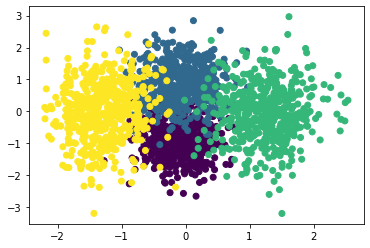

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline


data = Variable(torch.from_numpy(x), requires_grad=False)
model.train()
zs = model.get_z(data).data.numpy()

plt.scatter(zs[:,0], zs[:, 1], c=y)

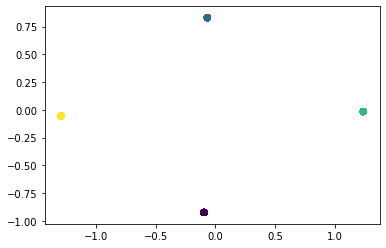

In [19]:
data = Variable(torch.from_numpy(x), requires_grad=False)
model.eval()
zs = model.get_z(data).data.numpy()

plt.scatter(zs[:,0], zs[:, 1], c=y)